# CS440/ECE448 Spring 2023
# MP11: Reinforcement Learning

The first thing you need to do is to download this file: <a href="mp11.zip">mp11.zip</a>.  If you want, you can also download <a href="mp11_extra.zip">mp11_extra.zip</a>, the extra credit assignment.  `mp11.zip` has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp11_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `pong.py`: This is a program that plays Pong.  If called interactively, it will call the module `pong_display.py` to create a display, so that you can play.  If told to use a Q-learner, it will call your `submitted.py` to do Q-learning.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp11_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Playing Pong</a>
1. <a href="#section2">Creating a Q-Learner Object</a>
1. <a href="#section3">Epsilon-First Exploration</a>
1. <a href="#section4">Q-Learning</a>
1. <a href="#section5">Saving and Loading Your Q and N Tables</a>
1. <a href="#section6">Exploitation</a>
1. <a href="#section7">Acting</a>
1. <a href="#section8">Training</a>
1. <a href="#section9">Extra Credit</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>

## Playing Pong

Pong was the <a href="https://en.wikipedia.org/wiki/Pong">first video game produced by Atari.</a>  It is a simple game, based on table tennis.  Here is a two-person version of the game: https://commons.wikimedia.org/wiki/File:Pong_Game_Test2.gif

We will be playing a one-person version of the game:

* When the ball hits the top, bottom, or left wall of the playing field, it bounces.
* The right end of the playing field is open, except for the paddle.  If the ball hits the paddle, it bounces, and the player's score increments by one.  If the ball hits the open space, the game is over; the score resets to zero, and a new game begins.

The game is pretty simple, but in order to get a better feeling for it, you may want to try playing it yourself.  Use the up arrow to move the paddle upward, and the down arrow to move the paddle downward.  See how high you can make your score:


In [2]:
!python pong.py

pygame 2.1.3 (SDL 2.0.22, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
Completed 0 games, 3 rewards, 416 frames, score 2, max score 2
Completed 1 games, 5 rewards, 821 frames, score 1, max score 2
Completed 2 games, 7 rewards, 1483 frames, score 1, max score 2
Completed 3 games, 8 rewards, 1737 frames, score 0, max score 2
Completed 4 games, 18 rewards, 3385 frames, score 9, max score 9
Completed 5 games, 19 rewards, 3566 frames, score 0, max score 9


Once you figure out how to use the arrow keys to control your paddle, we hope you will find that the game is not too hard for a human to play.  However, for a computer, it's difficult to know: where should the paddle be moved at each time step?  In order to see how difficult it is for a computer to play, let's ask the "random" player to play the game.

**WARNING:** The following line will open a pygame window.  The pygame window will be hidden by this window -- in order to see it, you will need to minimize this window.  The pygame window will consume a lot of CPU time just waiting for the processor, so in order to kill it, you will need to come back to this window, click on the block below, then click the Jupyter "stop" button (the square button at the top of this window) in order to stop processing.

In [1]:
!python pong.py --player random

<a id='section2'></a>

## Creating a Q-Learner Object

The first thing you will do is to create a `q_learner` object that can store your learned Q table and your N table (table of exploration counts).  

Like any other object-oriented language, python permits you to create new object classes in order to store data that will be needed from time to time.  If you are not already very, very familiar with python classes, you might want to study the python class tutorial: https://docs.python.org/3/tutorial/classes.html

Like any other object in python, a `q_learner` object is created by calling its name as a function, e.g., `my_q_learner=submitted.q_learner()`.  Doing so calls the function `submitted.q_learner.__init__()`.  Let's look at the docstring to see what it should do.

In [1]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.q_learner.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a Q table and an N table.
    Q[...state..., ...action...] = expected utility of state/action pair.
    N[...state..., ...action...] = # times state/action has been explored.
    Both are initialized to all zeros.
    Up to you: how will you encode the state and action in order to
    define these two lookup tables?  The state will be a list of 5 integers,
    such that 0 <= state[i] < state_cardinality[i] for 0 <= i < 5.
    The action will be either -1, 0, or 1.
    It is up to you to decide how to convert an input state and action
    into indices that you can use to access your stored Q and N tables.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of takin

Write your `__init__` function to meet the requirements specified in the docstring.  Once you have completed it, the following code should run without errors:

In [2]:
importlib.reload(submitted)

q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])

print(q_learner)


<a id='section3'></a>

## Epsilon-First Exploration

In order to manage the exploration/exploitation tradeoff, we will be using both "epsilon-first" and "epsilon-greedy" (https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).  

The epsilon-first strategy explores every state/action pair at least `nfirst` times before it ever starts to exploit any strategy.  Your `q_learner` should have a table to keep track of how many times it has explored a state/action pair prior to the start of any exploitation.  The method for storing that table is up to you; in order to have some standardized API, therefore, you need to write a method called `report_exploration_counts` that returns a list of the three exploration counts for a given state. 

In [8]:
importlib.reload(submitted)
help(submitted.q_learner.report_exploration_counts)

Help on function report_exploration_counts in module submitted:

report_exploration_counts(self, state)
    Check to see how many times each action has been explored in this state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    explored_count (array of 3 ints): 
      number of times that each action has been explored from this state.
      The mapping from actions to integers is up to you, but there must be three of them.



Write `report_exploration_counts` so that it returns a list or array for any given state.  Test your code with the following:

In [9]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('This is how many times state [0,0,0,0,0] has been explored so far:')
print(q_learner.report_exploration_counts([0,0,0,0,0]))
print('This is how many times state [9,9,1,1,9] has been explored so far:')
print(q_learner.report_exploration_counts([9,9,1,1,9]))

This is how many times state [0,0,0,0,0] has been explored so far:
[0, 0, 0]
This is how many times state [9,9,1,1,9] has been explored so far:
[0, 0, 0]


When your learner first starts learning, it will call the function `choose_unexplored_action` to choose an unexplored action.  This function should choose a function uniformly at random from the set of unexplored actions in a given state, if there are any:

In [10]:
importlib.reload(submitted)
help(submitted.q_learner.choose_unexplored_action)

Help on function choose_unexplored_action in module submitted:

choose_unexplored_action(self, state)
    Choose an action that has been explored less than nfirst times.
    If many actions are underexplored, you should choose uniformly
    from among those actions; don't just choose the first one all
    the time.
    
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar): either -1, or 0, or 1, or None
      If all actions have been explored at least n_explore times, return None.
      Otherwise, choose one uniformly at random from those w/count less than n_explore.
      When you choose an action, you should increment its count in your counter table.



If this has been written correctly, the following block should generate a random sequence of actions.  If the next block produces the same action 5 times in a row, that is the wrong result, and the result would be that your code does not pass the autograder.

In [36]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: 0
Next action: 0
Next action: -1
Next action: 0
Next action: 1


After all three actions have been explored `nfirst` times, the function `choose_unexplored_action` should return `None`, as shown here:

In [38]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,1,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: 1
Next action: 0
Next action: -1
Next action: None


<a id='section4'></a>

## Q-Learning

The reinforcement learning we are implementing is called Q-learning (https://en.wikipedia.org/wiki/Q-learning).  

Q-learning keeps a table $Q[s,a]$ that specifies the expected utility of action $a$ in state $s$.  The organization of this table is up to you.  In order to have a standard API, the first thing you should implement is a function `report_q` with the following docstring:

In [20]:
importlib.reload(submitted)
help(submitted.q_learner.report_q)

Help on function report_q in module submitted:

report_q(self, state)
    Report the current Q values for the given state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q (array of 3 floats): 
      reward plus expected future utility of each of the three actions. 
      The mapping from actions to integers is up to you, but there must be three of them.



When your `q_learner` is first initialized, the value of $Q[state,action]$ should be zero for all state/action pairs, thus the `report_q` function should return lists of zeros:

In [39]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Q[0,0,0,0,0] is now:',q_learner.report_q([0,0,0,0,0]))
print('Q[9,9,1,1,9] is now:',q_learner.report_q([9,9,1,1,9]))

Q[0,0,0,0,0] is now: [0, 0, 0]
Q[9,9,1,1,9] is now: [0, 0, 0]


There are actually many different Q-learning algorithms available, but when people refer to Q-learning with no modifier, they usually mean the time-difference (TD) algorithm.  For example, this is the algorithm that's described on the wikipedia page (https://en.wikipedia.org/wiki/Q-learning).  This is the algorithm you will implement for this MP.

In supervised machine learning, the learner tries to imitate a reference label.  In reinforcement learning, there is no reference label.  Q-learning replaces the reference label with a "local Q" value, which is the utility that was obtained by performing action $a$ in state $s$ one time.  It is usually calculated like this:

$$Q_{local}(s_t,a_t) = r_t + \gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$$

where $r_t$ is the reward that was achieved by performing action $a_t$ in state $s_t$, $s_{t+1}$ is the state into which the game transitioned, and $a_{t+1}$ is one of the actions that could be performed in that state.  $Q_{local}$ is computed by your `q_local` function, which has this docstring:  

In [22]:
importlib.reload(submitted)
help(submitted.q_learner.q_local)

Help on function q_local in module submitted:

q_local(self, reward, newstate)
    The update to Q estimated from a single step of game play:
    reward plus gamma times the max of Q[newstate, ...].
    
    @param:
    reward (scalar float): the reward achieved from the current step of game play.
    newstate (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q_local (scalar float): the local value of Q



Initially, `q_local` should just return the given reward, because initially, all Q values are 0:

In [40]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,10,10])
print('Q_local(6.25,[9,9,1,1,9]) is currently:',q_learner.q_local(6.25,[9,9,1,1,9]))

Q_local(6.25,[9,9,1,1,9]) is currently: 6.25


Now you can use `q_learner.q_local` as the target for `q_learner.learn`.  The basic algorithm is

$$Q(s,a) = Q(s,a) + \alpha (Q_{local}(s,a)-Q(s,a))$$

Here is the docstring:

In [25]:
importlib.reload(submitted)
help(submitted.q_learner.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Update the internal Q-table on the basis of an observed
    state, action, reward, newstate sequence.
    
    @params:
    state: a list of 5 numbers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle.
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 numbers, in the same format as state
    
    @return:
    None



The following block checks a sequence of Q updates:

1. First, $Q([9,9,1,1,9],-1)$ is updated.  Since all Q values start at zero, it will be updated to just have a value equal to $\alpha$ (0.05) times the given reward (6.25) for a total value of 0.3125.
1. When we print out $Q([9,9,1,1,9],:)$, we see that one of the elements has been updated.
1. Next, update $Q([9,9,1,1,8],1)$ with a given reward, and with $[9,9,1,1,9]$ as the given next state.  Since $Q([9,9,1,1,9],-1)$ is larger than zero, the next-state Q-value should be multiplied by $\gamma$ (0.99) and added to the reward (3.1), then multiplied by $\alpha$, giving a total value of 0.17046875.
1. The resulting Q-value is reported.

In [35]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
q_learner.learn([9,9,1,1,8],1,3.1,[9,9,1,1,9])
print('Q[9,9,1,1,8] is now',q_learner.report_q([9,9,1,1,8]))

Q[9,9,1,1,9] is now [0.3125, 0, 0]
Q[9,9,1,1,8] is now [0, 0, 0.17046875000000003]


<a id='section5'></a>

## Saving and Loading your Q and N Tables

After you've spent a long time training your `q_learner`, you will want to save your Q and N tables so that you can reload them later.  The format of Q and N is up to you, therefore it's also up to you to write the `save` and `load` functions.  Here are the docstrings:

In [42]:
importlib.reload(submitted)
help(submitted.q_learner.save)

Help on function save in module submitted:

save(self, filename)
    Save your Q and N tables to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.  We recommend numpy.savez,
    but you can use something else if you prefer.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [43]:
importlib.reload(submitted)
help(submitted.q_learner.load)

Help on function load in module submitted:

load(self, filename)
    Load the Q and N tables from a file.
    This should load from whatever file format your save function
    used.  We recommend numpy.load, but you can use something
    else if you prefer.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



These functions can be tested by doing one step of training one `q_learner`, then saving its results, then loading them into another `q_learner`:

In [45]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner1.choose_unexplored_action([9,9,1,1,9]))
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('N1[9,9,1,1,8] is now',q_learner1.report_exploration_counts([9,9,1,1,9]))
print('Q1[9,9,1,1,8] is now',q_learner1.report_q([9,9,1,1,9]))
q_learner1.save('test.npz')

q_learner2 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('N2[9,9,1,1,8] starts out as',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] starts out as',q_learner2.report_q([9,9,1,1,9]))
q_learner2.load('test.npz')
print('N2[9,9,1,1,8] is now',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] is now',q_learner2.report_q([9,9,1,1,9]))


Next action: 1
N1[9,9,1,1,8] is now [0, 0, 1]
Q1[9,9,1,1,8] is now [0.3125, 0, 0]
N2[9,9,1,1,8] starts out as [0, 0, 0]
Q2[9,9,1,1,8] starts out as [0, 0, 0]
N2[9,9,1,1,8] is now [0, 0, 1]
Q2[9,9,1,1,8] is now [0.3125, 0.0, 0.0]


<a id='section6'></a>

## Exploitation

A reinforcement learner always has to trade off between exploration (choosing an action at random) versus exploitation (choosing the action with the maximum expected utility).  Before we worry about that tradeoff, though, let's first make sure that exploitation works.

In [46]:
importlib.reload(submitted)
help(submitted.q_learner.exploit)

Help on function exploit in module submitted:

exploit(self, state)
    Return the action that has the highest Q-value for the current state, and its Q-value.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar int): either -1, or 0, or 1.
      The action that has the highest Q-value.  Ties can be broken any way you want.
    Q (scalar float): 
      The Q-value of the selected action



In [48]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q1[9,9,1,1,9] is now',q_learner1.report_q([9,9,1,1,9]))
print('The best action and Q from state [9,9,1,1,9] are',q_learner1.exploit([9,9,1,1,9]))

Q1[9,9,1,1,9] is now [0.3125, 0, 0]
The best action and Q from state [9,9,1,1,9] are (-1, 0.3125)


<a id='section7'></a>

## Acting

When your learner decides which action to perform, it should trade off exploration vs. exploitation using both the epsilon-first and the epsilon-greedy strategies:
1. If there is any action that has been explored fewer than `nfirst` times, then choose one of those actions at random.  Otherwise...
1. With probability `epsilon`, choose an action at random.  Otherwise...
1. Exploit.


In [49]:
importlib.reload(submitted)
help(submitted.q_learner.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    If any action has been taken less than nfirst times, then choose one of those
    actions, uniformly at random.
    Otherwise, with probability epsilon, choose an action uniformly at random.
    Otherwise, choose the action with the best Q(state,action).
    
    @params: 
    state: a list of 5 integers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In order to test all three types of action (epsilon-first exploration, epsilon-greedy exploration, and exploitation), let's create a learner with `nfirst=1` and `epsilon=0.25`, and set it so that the best action from state `[9,9,1,1,9]` is `-1`.  With these settings, a sequence of calls to `q_learner.act` should produce the following sequence of actions:

1. The first three actions should include each possible action once.
1. After the first three actions, 3/4 of the remaining actions should be `-1`.  The remaining 1/4 should be randomly chosen.

In [62]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.25,0.99,1,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('exploration_counts',q_learner.report_exploration_counts([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('exploration_counts',q_learner.report_exploration_counts([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('exploration_counts',q_learner.report_exploration_counts([9,9,1,1,9]))
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))

An epsilon-first action: 1
exploration_counts [0, 0, 1]
An epsilon-first action: -1
exploration_counts [1, 0, 1]
An epsilon-first action: 0
exploration_counts [1, 1, 1]
Q[9,9,1,1,9] is now [0.3125, 0, 0]
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1


<a id='section8'></a>

## Training

Now that all of your components work, you can try training your algorithm.  Do this by giving your `q_learner` as a player to a new `pong.PongGame` object.  Set `visibility=False` so that the `PongGame` doesn't create a new window.

In [3]:
import pong, importlib, submitted
importlib.reload(pong)
help(pong.PongGame.__init__)

Help on function __init__ in module pong:

__init__(self, ball_speed=4, paddle_speed=8, learner=None, visible=True, state_quantization=[10, 10, 2, 2, 10])
    Create a new pong game, with a specified player.
    
    @params:
    ball_speed (scalar int) - average ball speed in pixels/frame
    paddle_speed (scalar int) - paddle moves 0, +paddle_speed, or -paddle_speed
    learner - can be None if the player is human.  If not None, should be an 
      object of type random_learner, submitted.q_learner, or submitted.deep_q.
    visible (bool) - should this game have an attached pygame window?
    state_quantization (list) - if not None, state variables are quantized
      into integers of these cardinalities before being passed to the learner.



As you can see, we should set `visibility=False` so that the `PongGame` doesn't create a new window.  We should also make sure that the PongGame uses the same state quantization as the learner.

In [4]:
importlib.reload(pong)
importlib.reload(submitted)
state_quantization = [10,10,2,2,10]
q_learner=submitted.q_learner(0.05,0.05,0.99,5,state_quantization)

pong_game = pong.PongGame(learner=q_learner, visible=False, state_quantization=state_quantization)
print(pong_game)

In order to train our learner, we want it to play the game many times.  To do that we use the PongGame.run function:

In [65]:
help(pong_game.run)


Help on method run in module pong:

run(m_rewards=inf, m_games=inf, m_frames=inf, states=[]) method of pong.PongGame instance
    Run the game.
    @param
    m_frames (scalar int): maximum number of frames to be played
    m_rewards (scalar int): maximum number of rewards earned (+ or -)
    m_games (scalar int): maximum number of games
    states (list): list of states whose Q-values should be returned
       each state is a list of 5 ints: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
       and the y-position of the paddle, all quantized.
       0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
      
    @return
    scores (list): list of scores of all completed games
    
    The following will be returned only if the player is q_learning or deep_q.
    New elements will be added to these lists once/frame if m_frames is specified,
    else once/reward if m_rewards is specified, else once

In order to make sure our learner is learning, let's tell `pong_game.run` to output all 3 Q-values of all of the 4000 states in every time step.

To make sure that's not an outrageous amount of data, let's tell it to only output the Q values once/reward, and ask it to only collect 5000 rewards:


In [66]:
states = [[x,y,vx,vy,py] for x in range(10) for y in range(10) for vx in range(2) for vy in range(2) for py in range(10) ]

scores, q_achieved, q_states = pong_game.run(m_rewards=500, states=states)

print('The number of games played was',len(scores))
print('The number of rewards was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 209 frames, score 0, max score 0
Completed 1 games, 2 rewards, 390 frames, score 0, max score 0
Completed 2 games, 3 rewards, 598 frames, score 0, max score 0
Completed 3 games, 4 rewards, 779 frames, score 0, max score 0
Completed 4 games, 5 rewards, 960 frames, score 0, max score 0
Completed 5 games, 7 rewards, 1327 frames, score 1, max score 1
Completed 6 games, 9 rewards, 1878 frames, score 1, max score 1
Completed 7 games, 10 rewards, 2059 frames, score 0, max score 1
Completed 8 games, 12 rewards, 2457 frames, score 1, max score 1
Completed 9 games, 14 rewards, 2917 frames, score 1, max score 1
Completed 10 games, 16 rewards, 3507 frames, score 1, max score 1
Completed 11 games, 18 rewards, 4004 frames, score 1, max score 1
Completed 12 games, 19 rewards, 4185 frames, score 0, max score 1
Completed 13 games, 22 rewards, 4828 frames, score 2, max score 2
Completed 14 games, 24 rewards, 5430 frames, score 1, max score 2
Completed 15 games, 25 rewards, 

Completed 122 games, 192 rewards, 44072 frames, score 0, max score 6
Completed 123 games, 193 rewards, 44326 frames, score 0, max score 6
Completed 124 games, 194 rewards, 44534 frames, score 0, max score 6
Completed 125 games, 195 rewards, 44742 frames, score 0, max score 6
Completed 126 games, 196 rewards, 44996 frames, score 0, max score 6
Completed 127 games, 197 rewards, 45250 frames, score 0, max score 6
Completed 128 games, 198 rewards, 45458 frames, score 0, max score 6
Completed 129 games, 199 rewards, 45639 frames, score 0, max score 6
Completed 130 games, 200 rewards, 45847 frames, score 0, max score 6
Completed 131 games, 204 rewards, 46860 frames, score 3, max score 6
Completed 132 games, 205 rewards, 47114 frames, score 0, max score 6
Completed 133 games, 206 rewards, 47295 frames, score 0, max score 6
Completed 134 games, 207 rewards, 47476 frames, score 0, max score 6
Completed 135 games, 208 rewards, 47657 frames, score 0, max score 6
Completed 136 games, 210 rewards, 

Completed 244 games, 394 rewards, 94978 frames, score 4, max score 7
Completed 245 games, 398 rewards, 95733 frames, score 3, max score 7
Completed 246 games, 403 rewards, 96860 frames, score 4, max score 7
Completed 247 games, 405 rewards, 97616 frames, score 1, max score 7
Completed 248 games, 410 rewards, 98822 frames, score 4, max score 7
Completed 249 games, 413 rewards, 99622 frames, score 2, max score 7
Completed 250 games, 415 rewards, 100110 frames, score 1, max score 7
Completed 251 games, 416 rewards, 100291 frames, score 0, max score 7
Completed 252 games, 417 rewards, 100499 frames, score 0, max score 7
Completed 253 games, 421 rewards, 101449 frames, score 3, max score 7
Completed 254 games, 424 rewards, 102100 frames, score 2, max score 7
Completed 255 games, 426 rewards, 102634 frames, score 1, max score 7
Completed 256 games, 428 rewards, 103105 frames, score 1, max score 7
Completed 257 games, 429 rewards, 103359 frames, score 0, max score 7
Completed 258 games, 432 r

The returned value of `q_states` is a list of 4000x3 numpy arrays (20 states, 3 actions).  The list contains `m_rewards` of these. We want to convert it into something that matplotlib can plot.  

In [67]:
import numpy as np

Q = np.array([np.reshape(q,-1) for q in q_states])
print('Q is now of shape',Q.shape)
print('the max absolute value of Q is ',np.amax(abs(Q)))

Q is now of shape (500, 12000)
the max absolute value of Q is  1.8545365162984222


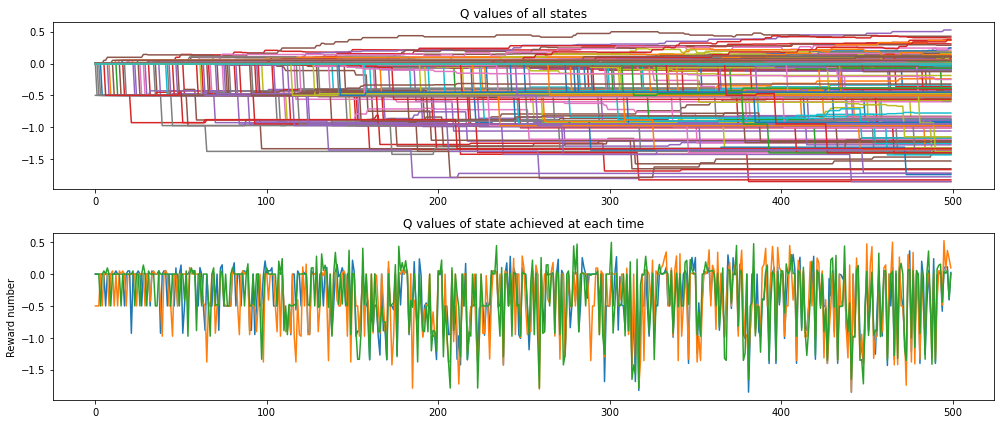

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))
ax = [fig.add_subplot(2, 1, x) for x in range(1, 3)]
ax[0].plot(np.arange(0, len(q_states)), Q)
ax[0].set_title('Q values of all states')
ax[1].plot(np.arange(0, len(q_states)), q_achieved)
ax[1].set_title('Q values of state achieved at each time')
ax[1].set_ylabel('Reward number')

plt.tight_layout()
plt.show()


OK, now let's try running it for a much longer period -- say, 5000 complete games.  We won't ask it to print out any states this time.

In [70]:
scores, q_achieved, q_states = pong_game.run(m_games=5000, states=[])

print('The number of games played was',len(scores))
print('The number of video frames was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 2 rewards, 663 frames, score 6, max score 7
Completed 1 games, 6 rewards, 1747 frames, score 3, max score 7
Completed 2 games, 7 rewards, 1928 frames, score 0, max score 7
Completed 3 games, 8 rewards, 2136 frames, score 0, max score 7
Completed 4 games, 9 rewards, 2317 frames, score 0, max score 7
Completed 5 games, 13 rewards, 3044 frames, score 3, max score 7
Completed 6 games, 14 rewards, 3298 frames, score 0, max score 7
Completed 7 games, 15 rewards, 3506 frames, score 0, max score 7
Completed 8 games, 18 rewards, 4460 frames, score 2, max score 7
Completed 9 games, 22 rewards, 5534 frames, score 3, max score 7
Completed 10 games, 25 rewards, 6225 frames, score 2, max score 7
Completed 11 games, 27 rewards, 6593 frames, score 1, max score 7
Completed 12 games, 30 rewards, 7084 frames, score 2, max score 7
Completed 13 games, 32 rewards, 8050 frames, score 1, max score 7
Completed 14 games, 33 rewards, 8258 frames, score 0, max score 7
Completed 15 games, 35 rew

Completed 124 games, 267 rewards, 63563 frames, score 6, max score 8
Completed 125 games, 268 rewards, 63744 frames, score 0, max score 8
Completed 126 games, 272 rewards, 64656 frames, score 3, max score 8
Completed 127 games, 273 rewards, 64864 frames, score 0, max score 8
Completed 128 games, 274 rewards, 65118 frames, score 0, max score 8
Completed 129 games, 281 rewards, 66461 frames, score 6, max score 8
Completed 130 games, 283 rewards, 67637 frames, score 1, max score 8
Completed 131 games, 289 rewards, 69379 frames, score 5, max score 8
Completed 132 games, 293 rewards, 70129 frames, score 3, max score 8
Completed 133 games, 295 rewards, 70600 frames, score 1, max score 8
Completed 134 games, 296 rewards, 70781 frames, score 0, max score 8
Completed 135 games, 298 rewards, 71244 frames, score 1, max score 8
Completed 136 games, 301 rewards, 71934 frames, score 2, max score 8
Completed 137 games, 302 rewards, 72188 frames, score 0, max score 8
Completed 138 games, 304 rewards, 

Completed 242 games, 531 rewards, 126847 frames, score 0, max score 13
Completed 243 games, 532 rewards, 127055 frames, score 0, max score 13
Completed 244 games, 536 rewards, 128388 frames, score 3, max score 13
Completed 245 games, 537 rewards, 128642 frames, score 0, max score 13
Completed 246 games, 542 rewards, 130157 frames, score 4, max score 13
Completed 247 games, 544 rewards, 130563 frames, score 1, max score 13
Completed 248 games, 548 rewards, 131477 frames, score 3, max score 13
Completed 249 games, 550 rewards, 132396 frames, score 1, max score 13
Completed 250 games, 556 rewards, 136453 frames, score 5, max score 13
Completed 251 games, 558 rewards, 136635 frames, score 1, max score 13
Completed 252 games, 559 rewards, 136889 frames, score 0, max score 13
Completed 253 games, 560 rewards, 137143 frames, score 0, max score 13
Completed 254 games, 565 rewards, 137969 frames, score 4, max score 13
Completed 255 games, 567 rewards, 138559 frames, score 1, max score 13
Comple

Completed 472 games, 1356 rewards, 338137 frames, score 10, max score 18
Completed 473 games, 1359 rewards, 339593 frames, score 2, max score 18
Completed 474 games, 1362 rewards, 340084 frames, score 2, max score 18
Completed 475 games, 1368 rewards, 342157 frames, score 5, max score 18
Completed 476 games, 1375 rewards, 344487 frames, score 6, max score 18
Completed 477 games, 1379 rewards, 345641 frames, score 3, max score 18
Completed 478 games, 1384 rewards, 347077 frames, score 4, max score 18
Completed 479 games, 1390 rewards, 348106 frames, score 5, max score 18
Completed 480 games, 1395 rewards, 349205 frames, score 4, max score 18
Completed 481 games, 1400 rewards, 351631 frames, score 4, max score 18
Completed 482 games, 1404 rewards, 352558 frames, score 3, max score 18
Completed 483 games, 1406 rewards, 352995 frames, score 1, max score 18
Completed 484 games, 1412 rewards, 354152 frames, score 5, max score 18
Completed 485 games, 1418 rewards, 355199 frames, score 5, max 

Completed 586 games, 1803 rewards, 452072 frames, score 3, max score 18
Completed 587 games, 1807 rewards, 452717 frames, score 3, max score 18
Completed 588 games, 1813 rewards, 453830 frames, score 5, max score 18
Completed 589 games, 1817 rewards, 455450 frames, score 3, max score 18
Completed 590 games, 1818 rewards, 455631 frames, score 0, max score 18
Completed 591 games, 1819 rewards, 455885 frames, score 0, max score 18
Completed 592 games, 1822 rewards, 456685 frames, score 2, max score 18
Completed 593 games, 1823 rewards, 456893 frames, score 0, max score 18
Completed 594 games, 1824 rewards, 457074 frames, score 0, max score 18
Completed 595 games, 1825 rewards, 457328 frames, score 0, max score 18
Completed 596 games, 1833 rewards, 460166 frames, score 7, max score 18
Completed 597 games, 1838 rewards, 461119 frames, score 4, max score 18
Completed 598 games, 1844 rewards, 463275 frames, score 5, max score 18
Completed 599 games, 1848 rewards, 464476 frames, score 3, max s

Completed 703 games, 2343 rewards, 587902 frames, score 12, max score 22
Completed 704 games, 2351 rewards, 592206 frames, score 7, max score 22
Completed 705 games, 2353 rewards, 592703 frames, score 1, max score 22
Completed 706 games, 2357 rewards, 593689 frames, score 3, max score 22
Completed 707 games, 2360 rewards, 594480 frames, score 2, max score 22
Completed 708 games, 2363 rewards, 595065 frames, score 2, max score 22
Completed 709 games, 2365 rewards, 595502 frames, score 1, max score 22
Completed 710 games, 2369 rewards, 598131 frames, score 3, max score 22
Completed 711 games, 2371 rewards, 598628 frames, score 1, max score 22
Completed 712 games, 2375 rewards, 599758 frames, score 3, max score 22
Completed 713 games, 2383 rewards, 601176 frames, score 7, max score 22
Completed 714 games, 2386 rewards, 603200 frames, score 2, max score 22
Completed 715 games, 2395 rewards, 604616 frames, score 8, max score 22
Completed 716 games, 2397 rewards, 605535 frames, score 1, max 

Completed 820 games, 2851 rewards, 724925 frames, score 2, max score 22
Completed 821 games, 2855 rewards, 726172 frames, score 3, max score 22
Completed 822 games, 2859 rewards, 726836 frames, score 3, max score 22
Completed 823 games, 2863 rewards, 727703 frames, score 3, max score 22
Completed 824 games, 2869 rewards, 728963 frames, score 5, max score 22
Completed 825 games, 2871 rewards, 729514 frames, score 1, max score 22
Completed 826 games, 2877 rewards, 731201 frames, score 5, max score 22
Completed 827 games, 2880 rewards, 732018 frames, score 2, max score 22
Completed 828 games, 2881 rewards, 732199 frames, score 0, max score 22
Completed 829 games, 2891 rewards, 734059 frames, score 9, max score 22
Completed 830 games, 2895 rewards, 735093 frames, score 3, max score 22
Completed 831 games, 2897 rewards, 735507 frames, score 1, max score 22
Completed 832 games, 2901 rewards, 736182 frames, score 3, max score 22
Completed 833 games, 2910 rewards, 737991 frames, score 8, max s

Completed 935 games, 3351 rewards, 851260 frames, score 1, max score 22
Completed 936 games, 3355 rewards, 852040 frames, score 3, max score 22
Completed 937 games, 3357 rewards, 852477 frames, score 1, max score 22
Completed 938 games, 3358 rewards, 852658 frames, score 0, max score 22
Completed 939 games, 3359 rewards, 852839 frames, score 0, max score 22
Completed 940 games, 3360 rewards, 853093 frames, score 0, max score 22
Completed 941 games, 3363 rewards, 854407 frames, score 2, max score 22
Completed 942 games, 3364 rewards, 854615 frames, score 0, max score 22
Completed 943 games, 3372 rewards, 856388 frames, score 7, max score 22
Completed 944 games, 3378 rewards, 859469 frames, score 5, max score 22
Completed 945 games, 3379 rewards, 859677 frames, score 0, max score 22
Completed 946 games, 3380 rewards, 859885 frames, score 0, max score 22
Completed 947 games, 3382 rewards, 860313 frames, score 1, max score 22
Completed 948 games, 3384 rewards, 860741 frames, score 1, max s

Completed 1051 games, 3814 rewards, 966544 frames, score 5, max score 22
Completed 1052 games, 3815 rewards, 966798 frames, score 0, max score 22
Completed 1053 games, 3816 rewards, 967006 frames, score 0, max score 22
Completed 1054 games, 3821 rewards, 968619 frames, score 4, max score 22
Completed 1055 games, 3822 rewards, 968827 frames, score 0, max score 22
Completed 1056 games, 3823 rewards, 969008 frames, score 0, max score 22
Completed 1057 games, 3826 rewards, 969596 frames, score 2, max score 22
Completed 1058 games, 3828 rewards, 970147 frames, score 1, max score 22
Completed 1059 games, 3833 rewards, 971591 frames, score 4, max score 22
Completed 1060 games, 3841 rewards, 974405 frames, score 7, max score 22
Completed 1061 games, 3843 rewards, 974837 frames, score 1, max score 22
Completed 1062 games, 3851 rewards, 976749 frames, score 7, max score 22
Completed 1063 games, 3857 rewards, 977838 frames, score 5, max score 22
Completed 1064 games, 3863 rewards, 979358 frames, 

Completed 1163 games, 4290 rewards, 1082266 frames, score 10, max score 22
Completed 1164 games, 4293 rewards, 1082820 frames, score 2, max score 22
Completed 1165 games, 4302 rewards, 1084414 frames, score 8, max score 22
Completed 1166 games, 4303 rewards, 1084668 frames, score 0, max score 22
Completed 1167 games, 4316 rewards, 1087014 frames, score 12, max score 22
Completed 1168 games, 4319 rewards, 1087949 frames, score 2, max score 22
Completed 1169 games, 4325 rewards, 1089331 frames, score 5, max score 22
Completed 1170 games, 4331 rewards, 1092098 frames, score 5, max score 22
Completed 1171 games, 4333 rewards, 1092688 frames, score 1, max score 22
Completed 1172 games, 4338 rewards, 1093523 frames, score 4, max score 22
Completed 1173 games, 4340 rewards, 1094011 frames, score 1, max score 22
Completed 1174 games, 4357 rewards, 1097621 frames, score 16, max score 22
Completed 1175 games, 4361 rewards, 1098512 frames, score 3, max score 22
Completed 1176 games, 4366 rewards,

Completed 1274 games, 4820 rewards, 1206837 frames, score 2, max score 22
Completed 1275 games, 4823 rewards, 1207711 frames, score 2, max score 22
Completed 1276 games, 4825 rewards, 1208174 frames, score 1, max score 22
Completed 1277 games, 4829 rewards, 1209062 frames, score 3, max score 22
Completed 1278 games, 4831 rewards, 1209490 frames, score 1, max score 22
Completed 1279 games, 4835 rewards, 1210214 frames, score 3, max score 22
Completed 1280 games, 4841 rewards, 1211629 frames, score 5, max score 22
Completed 1281 games, 4846 rewards, 1212669 frames, score 4, max score 22
Completed 1282 games, 4850 rewards, 1213886 frames, score 3, max score 22
Completed 1283 games, 4851 rewards, 1214140 frames, score 0, max score 22
Completed 1284 games, 4853 rewards, 1214554 frames, score 1, max score 22
Completed 1285 games, 4854 rewards, 1214808 frames, score 0, max score 22
Completed 1286 games, 4859 rewards, 1216465 frames, score 4, max score 22
Completed 1287 games, 4860 rewards, 12

Completed 1496 games, 5767 rewards, 1449265 frames, score 8, max score 22
Completed 1497 games, 5768 rewards, 1449519 frames, score 0, max score 22
Completed 1498 games, 5773 rewards, 1450368 frames, score 4, max score 22
Completed 1499 games, 5782 rewards, 1454207 frames, score 8, max score 22
Completed 1500 games, 5788 rewards, 1455335 frames, score 5, max score 22
Completed 1501 games, 5790 rewards, 1455763 frames, score 1, max score 22
Completed 1502 games, 5792 rewards, 1456168 frames, score 1, max score 22
Completed 1503 games, 5804 rewards, 1460543 frames, score 11, max score 22
Completed 1504 games, 5809 rewards, 1461576 frames, score 4, max score 22
Completed 1505 games, 5813 rewards, 1462399 frames, score 3, max score 22
Completed 1506 games, 5817 rewards, 1463263 frames, score 3, max score 22
Completed 1507 games, 5819 rewards, 1463691 frames, score 1, max score 22
Completed 1508 games, 5820 rewards, 1463872 frames, score 0, max score 22
Completed 1509 games, 5827 rewards, 1

Completed 1610 games, 6172 rewards, 1548946 frames, score 2, max score 22
Completed 1611 games, 6173 rewards, 1549127 frames, score 0, max score 22
Completed 1612 games, 6174 rewards, 1549335 frames, score 0, max score 22
Completed 1613 games, 6175 rewards, 1549516 frames, score 0, max score 22
Completed 1614 games, 6177 rewards, 1550250 frames, score 1, max score 22
Completed 1615 games, 6179 rewards, 1550747 frames, score 1, max score 22
Completed 1616 games, 6181 rewards, 1551099 frames, score 1, max score 22
Completed 1617 games, 6184 rewards, 1551653 frames, score 2, max score 22
Completed 1618 games, 6185 rewards, 1551907 frames, score 0, max score 22
Completed 1619 games, 6187 rewards, 1552395 frames, score 1, max score 22
Completed 1620 games, 6188 rewards, 1552603 frames, score 0, max score 22
Completed 1621 games, 6189 rewards, 1552784 frames, score 0, max score 22
Completed 1622 games, 6192 rewards, 1553399 frames, score 2, max score 22
Completed 1623 games, 6193 rewards, 15

Completed 1721 games, 6501 rewards, 1628909 frames, score 4, max score 22
Completed 1722 games, 6504 rewards, 1629582 frames, score 2, max score 22
Completed 1723 games, 6511 rewards, 1631219 frames, score 6, max score 22
Completed 1724 games, 6513 rewards, 1631753 frames, score 1, max score 22
Completed 1725 games, 6519 rewards, 1632782 frames, score 5, max score 22
Completed 1726 games, 6538 rewards, 1638718 frames, score 18, max score 22
Completed 1727 games, 6543 rewards, 1639785 frames, score 4, max score 22
Completed 1728 games, 6552 rewards, 1643838 frames, score 8, max score 22
Completed 1729 games, 6556 rewards, 1645059 frames, score 3, max score 22
Completed 1730 games, 6558 rewards, 1645610 frames, score 1, max score 22
Completed 1731 games, 6559 rewards, 1645818 frames, score 0, max score 22
Completed 1732 games, 6564 rewards, 1646979 frames, score 4, max score 22
Completed 1733 games, 6565 rewards, 1647233 frames, score 0, max score 22
Completed 1734 games, 6566 rewards, 1

Completed 1832 games, 6876 rewards, 1720243 frames, score 5, max score 22
Completed 1833 games, 6882 rewards, 1721796 frames, score 5, max score 22
Completed 1834 games, 6883 rewards, 1721977 frames, score 0, max score 22
Completed 1835 games, 6889 rewards, 1723184 frames, score 5, max score 22
Completed 1836 games, 6891 rewards, 1723774 frames, score 1, max score 22
Completed 1837 games, 6896 rewards, 1725548 frames, score 4, max score 22
Completed 1838 games, 6898 rewards, 1725916 frames, score 1, max score 22
Completed 1839 games, 6899 rewards, 1726097 frames, score 0, max score 22
Completed 1840 games, 6900 rewards, 1726351 frames, score 0, max score 22
Completed 1841 games, 6901 rewards, 1726605 frames, score 0, max score 22
Completed 1842 games, 6906 rewards, 1727555 frames, score 4, max score 22
Completed 1843 games, 6907 rewards, 1727809 frames, score 0, max score 22
Completed 1844 games, 6908 rewards, 1728063 frames, score 0, max score 22
Completed 1845 games, 6915 rewards, 17

Completed 1949 games, 7273 rewards, 1822736 frames, score 1, max score 22
Completed 1950 games, 7276 rewards, 1823567 frames, score 2, max score 22
Completed 1951 games, 7280 rewards, 1825051 frames, score 3, max score 22
Completed 1952 games, 7283 rewards, 1825663 frames, score 2, max score 22
Completed 1953 games, 7285 rewards, 1826100 frames, score 1, max score 22
Completed 1954 games, 7286 rewards, 1826308 frames, score 0, max score 22
Completed 1955 games, 7289 rewards, 1826855 frames, score 2, max score 22
Completed 1956 games, 7293 rewards, 1827767 frames, score 3, max score 22
Completed 1957 games, 7296 rewards, 1828663 frames, score 2, max score 22
Completed 1958 games, 7300 rewards, 1829343 frames, score 3, max score 22
Completed 1959 games, 7301 rewards, 1829524 frames, score 0, max score 22
Completed 1960 games, 7310 rewards, 1834735 frames, score 8, max score 22
Completed 1961 games, 7311 rewards, 1834989 frames, score 0, max score 22
Completed 1962 games, 7312 rewards, 18

Completed 2061 games, 7635 rewards, 1916273 frames, score 15, max score 22
Completed 2062 games, 7638 rewards, 1917340 frames, score 2, max score 22
Completed 2063 games, 7643 rewards, 1918422 frames, score 4, max score 22
Completed 2064 games, 7647 rewards, 1919416 frames, score 3, max score 22
Completed 2065 games, 7650 rewards, 1920135 frames, score 2, max score 22
Completed 2066 games, 7654 rewards, 1920875 frames, score 3, max score 22
Completed 2067 games, 7661 rewards, 1922337 frames, score 6, max score 22
Completed 2068 games, 7666 rewards, 1923279 frames, score 4, max score 22
Completed 2069 games, 7680 rewards, 1925965 frames, score 13, max score 22
Completed 2070 games, 7684 rewards, 1927072 frames, score 3, max score 22
Completed 2071 games, 7685 rewards, 1927253 frames, score 0, max score 22
Completed 2072 games, 7689 rewards, 1928284 frames, score 3, max score 22
Completed 2073 games, 7690 rewards, 1928492 frames, score 0, max score 22
Completed 2074 games, 7694 rewards, 

Completed 2174 games, 8224 rewards, 2077268 frames, score 6, max score 22
Completed 2175 games, 8230 rewards, 2078495 frames, score 5, max score 22
Completed 2176 games, 8238 rewards, 2079728 frames, score 7, max score 22
Completed 2177 games, 8240 rewards, 2080111 frames, score 1, max score 22
Completed 2178 games, 8242 rewards, 2080662 frames, score 1, max score 22
Completed 2179 games, 8246 rewards, 2081371 frames, score 3, max score 22
Completed 2180 games, 8253 rewards, 2083026 frames, score 6, max score 22
Completed 2181 games, 8255 rewards, 2083486 frames, score 1, max score 22
Completed 2182 games, 8257 rewards, 2084020 frames, score 1, max score 22
Completed 2183 games, 8260 rewards, 2084592 frames, score 2, max score 22
Completed 2184 games, 8265 rewards, 2085358 frames, score 4, max score 22
Completed 2185 games, 8272 rewards, 2086594 frames, score 6, max score 22
Completed 2186 games, 8277 rewards, 2087392 frames, score 4, max score 22
Completed 2187 games, 8286 rewards, 20

Completed 2286 games, 8817 rewards, 2223188 frames, score 10, max score 28
Completed 2287 games, 8818 rewards, 2223396 frames, score 0, max score 28
Completed 2288 games, 8821 rewards, 2224608 frames, score 2, max score 28
Completed 2289 games, 8823 rewards, 2225527 frames, score 1, max score 28
Completed 2290 games, 8824 rewards, 2225735 frames, score 0, max score 28
Completed 2291 games, 8834 rewards, 2227493 frames, score 9, max score 28
Completed 2292 games, 8836 rewards, 2228044 frames, score 1, max score 28
Completed 2293 games, 8842 rewards, 2229564 frames, score 5, max score 28
Completed 2294 games, 8846 rewards, 2230173 frames, score 3, max score 28
Completed 2295 games, 8854 rewards, 2231475 frames, score 7, max score 28
Completed 2296 games, 8857 rewards, 2232216 frames, score 2, max score 28
Completed 2297 games, 8858 rewards, 2232397 frames, score 0, max score 28
Completed 2298 games, 8862 rewards, 2233102 frames, score 3, max score 28
Completed 2299 games, 8869 rewards, 2

Completed 2403 games, 9295 rewards, 2350748 frames, score 3, max score 28
Completed 2404 games, 9299 rewards, 2351952 frames, score 3, max score 28
Completed 2405 games, 9302 rewards, 2352540 frames, score 2, max score 28
Completed 2406 games, 9308 rewards, 2355088 frames, score 5, max score 28
Completed 2407 games, 9313 rewards, 2356013 frames, score 4, max score 28
Completed 2408 games, 9321 rewards, 2358143 frames, score 7, max score 28
Completed 2409 games, 9323 rewards, 2358655 frames, score 1, max score 28
Completed 2410 games, 9328 rewards, 2359753 frames, score 4, max score 28
Completed 2411 games, 9352 rewards, 2368117 frames, score 23, max score 28
Completed 2412 games, 9355 rewards, 2369052 frames, score 2, max score 28
Completed 2413 games, 9357 rewards, 2369419 frames, score 1, max score 28
Completed 2414 games, 9365 rewards, 2371281 frames, score 7, max score 28
Completed 2415 games, 9368 rewards, 2371889 frames, score 2, max score 28
Completed 2416 games, 9369 rewards, 2

Completed 2515 games, 10084 rewards, 2572470 frames, score 1, max score 40
Completed 2516 games, 10087 rewards, 2572996 frames, score 2, max score 40
Completed 2517 games, 10090 rewards, 2573899 frames, score 2, max score 40
Completed 2518 games, 10104 rewards, 2576268 frames, score 13, max score 40
Completed 2519 games, 10112 rewards, 2577823 frames, score 7, max score 40
Completed 2520 games, 10152 rewards, 2586186 frames, score 39, max score 40
Completed 2521 games, 10153 rewards, 2586367 frames, score 0, max score 40
Completed 2522 games, 10155 rewards, 2586918 frames, score 1, max score 40
Completed 2523 games, 10167 rewards, 2589450 frames, score 11, max score 40
Completed 2524 games, 10172 rewards, 2590382 frames, score 4, max score 40
Completed 2525 games, 10183 rewards, 2592606 frames, score 10, max score 40
Completed 2526 games, 10187 rewards, 2593495 frames, score 3, max score 40
Completed 2527 games, 10188 rewards, 2593676 frames, score 0, max score 40
Completed 2528 games,

Completed 2625 games, 11383 rewards, 2855910 frames, score 45, max score 45
Completed 2626 games, 11386 rewards, 2856817 frames, score 2, max score 45
Completed 2627 games, 11388 rewards, 2857184 frames, score 1, max score 45
Completed 2628 games, 11405 rewards, 2861124 frames, score 16, max score 45
Completed 2629 games, 11410 rewards, 2861947 frames, score 4, max score 45
Completed 2630 games, 11420 rewards, 2863496 frames, score 9, max score 45
Completed 2631 games, 11430 rewards, 2865112 frames, score 9, max score 45
Completed 2632 games, 11440 rewards, 2866830 frames, score 9, max score 45
Completed 2633 games, 11453 rewards, 2871458 frames, score 12, max score 45
Completed 2634 games, 11456 rewards, 2872020 frames, score 2, max score 45
Completed 2635 games, 11473 rewards, 2874589 frames, score 16, max score 45
Completed 2636 games, 11475 rewards, 2875165 frames, score 1, max score 45
Completed 2637 games, 11487 rewards, 2877428 frames, score 11, max score 45
Completed 2638 games

Completed 2734 games, 13059 rewards, 3211881 frames, score 19, max score 64
Completed 2735 games, 13062 rewards, 3212964 frames, score 2, max score 64
Completed 2736 games, 13071 rewards, 3216050 frames, score 8, max score 64
Completed 2737 games, 13077 rewards, 3217669 frames, score 5, max score 64
Completed 2738 games, 13081 rewards, 3219377 frames, score 3, max score 64
Completed 2739 games, 13120 rewards, 3230316 frames, score 38, max score 64
Completed 2740 games, 13149 rewards, 3235256 frames, score 28, max score 64
Completed 2741 games, 13159 rewards, 3240547 frames, score 9, max score 64
Completed 2742 games, 13164 rewards, 3241359 frames, score 4, max score 64
Completed 2743 games, 13179 rewards, 3243647 frames, score 14, max score 64
Completed 2744 games, 13204 rewards, 3248402 frames, score 24, max score 64
Completed 2745 games, 13205 rewards, 3248610 frames, score 0, max score 64
Completed 2746 games, 13217 rewards, 3250756 frames, score 11, max score 64
Completed 2747 game

Completed 2844 games, 15243 rewards, 3712066 frames, score 34, max score 80
Completed 2845 games, 15299 rewards, 3725439 frames, score 55, max score 80
Completed 2846 games, 15315 rewards, 3730891 frames, score 15, max score 80
Completed 2847 games, 15361 rewards, 3744594 frames, score 45, max score 80
Completed 2848 games, 15366 rewards, 3745790 frames, score 4, max score 80
Completed 2849 games, 15381 rewards, 3748261 frames, score 14, max score 80
Completed 2850 games, 15394 rewards, 3750686 frames, score 12, max score 80
Completed 2851 games, 15423 rewards, 3754974 frames, score 28, max score 80
Completed 2852 games, 15488 rewards, 3772874 frames, score 64, max score 80
Completed 2853 games, 15519 rewards, 3777481 frames, score 30, max score 80
Completed 2854 games, 15526 rewards, 3778773 frames, score 6, max score 80
Completed 2855 games, 15544 rewards, 3781779 frames, score 17, max score 80
Completed 2856 games, 15557 rewards, 3784358 frames, score 12, max score 80
Completed 2857

Completed 2955 games, 17199 rewards, 4149854 frames, score 27, max score 98
Completed 2956 games, 17225 rewards, 4154188 frames, score 25, max score 98
Completed 2957 games, 17239 rewards, 4157153 frames, score 13, max score 98
Completed 2958 games, 17259 rewards, 4160429 frames, score 19, max score 98
Completed 2959 games, 17263 rewards, 4161194 frames, score 3, max score 98
Completed 2960 games, 17267 rewards, 4161943 frames, score 3, max score 98
Completed 2961 games, 17280 rewards, 4166245 frames, score 12, max score 98
Completed 2962 games, 17303 rewards, 4169697 frames, score 22, max score 98
Completed 2963 games, 17304 rewards, 4169951 frames, score 0, max score 98
Completed 2964 games, 17305 rewards, 4170205 frames, score 0, max score 98
Completed 2965 games, 17311 rewards, 4171583 frames, score 5, max score 98
Completed 2966 games, 17312 rewards, 4171837 frames, score 0, max score 98
Completed 2967 games, 17313 rewards, 4172091 frames, score 0, max score 98
Completed 2968 game

Completed 3064 games, 18947 rewards, 4521107 frames, score 1, max score 99
Completed 3065 games, 18950 rewards, 4521760 frames, score 2, max score 99
Completed 3066 games, 18956 rewards, 4525287 frames, score 5, max score 99
Completed 3067 games, 18962 rewards, 4526328 frames, score 5, max score 99
Completed 3068 games, 18976 rewards, 4533159 frames, score 13, max score 99
Completed 3069 games, 18977 rewards, 4533367 frames, score 0, max score 99
Completed 3070 games, 19009 rewards, 4541808 frames, score 31, max score 99
Completed 3071 games, 19014 rewards, 4543906 frames, score 4, max score 99
Completed 3072 games, 19017 rewards, 4544516 frames, score 2, max score 99
Completed 3073 games, 19023 rewards, 4548343 frames, score 5, max score 99
Completed 3074 games, 19029 rewards, 4549537 frames, score 5, max score 99
Completed 3075 games, 19044 rewards, 4551902 frames, score 14, max score 99
Completed 3076 games, 19072 rewards, 4561574 frames, score 27, max score 99
Completed 3077 games,

Completed 3173 games, 20884 rewards, 5007462 frames, score 16, max score 99
Completed 3174 games, 20908 rewards, 5013234 frames, score 23, max score 99
Completed 3175 games, 20910 rewards, 5013824 frames, score 1, max score 99
Completed 3176 games, 20929 rewards, 5017001 frames, score 18, max score 99
Completed 3177 games, 20934 rewards, 5017934 frames, score 4, max score 99
Completed 3178 games, 20941 rewards, 5019738 frames, score 6, max score 99
Completed 3179 games, 20944 rewards, 5021113 frames, score 2, max score 99
Completed 3180 games, 20952 rewards, 5022659 frames, score 7, max score 99
Completed 3181 games, 20954 rewards, 5023057 frames, score 1, max score 99
Completed 3182 games, 20956 rewards, 5023471 frames, score 1, max score 99
Completed 3183 games, 21009 rewards, 5034306 frames, score 52, max score 99
Completed 3184 games, 21031 rewards, 5039767 frames, score 21, max score 99
Completed 3185 games, 21079 rewards, 5054039 frames, score 47, max score 99
Completed 3186 game

Completed 3283 games, 22513 rewards, 5371938 frames, score 3, max score 99
Completed 3284 games, 22515 rewards, 5372489 frames, score 1, max score 99
Completed 3285 games, 22535 rewards, 5380536 frames, score 19, max score 99
Completed 3286 games, 22556 rewards, 5386658 frames, score 20, max score 99
Completed 3287 games, 22560 rewards, 5387418 frames, score 3, max score 99
Completed 3288 games, 22574 rewards, 5389668 frames, score 13, max score 99
Completed 3289 games, 22583 rewards, 5394915 frames, score 8, max score 99
Completed 3290 games, 22619 rewards, 5402321 frames, score 35, max score 99
Completed 3291 games, 22625 rewards, 5405497 frames, score 5, max score 99
Completed 3292 games, 22632 rewards, 5406888 frames, score 6, max score 99
Completed 3293 games, 22703 rewards, 5422048 frames, score 70, max score 99
Completed 3294 games, 22708 rewards, 5424860 frames, score 4, max score 99
Completed 3295 games, 22714 rewards, 5425900 frames, score 5, max score 99
Completed 3296 games

Completed 3392 games, 25749 rewards, 6026968 frames, score 92, max score 216
Completed 3393 games, 25849 rewards, 6042490 frames, score 99, max score 216
Completed 3394 games, 25901 rewards, 6051074 frames, score 51, max score 216
Completed 3395 games, 25926 rewards, 6054971 frames, score 24, max score 216
Completed 3396 games, 25949 rewards, 6058837 frames, score 22, max score 216
Completed 3397 games, 26205 rewards, 6109373 frames, score 255, max score 255
Completed 3398 games, 26317 rewards, 6130477 frames, score 111, max score 255
Completed 3399 games, 26349 rewards, 6135173 frames, score 31, max score 255
Completed 3400 games, 26351 rewards, 6135540 frames, score 1, max score 255
Completed 3401 games, 26527 rewards, 6162408 frames, score 175, max score 255
Completed 3402 games, 26625 rewards, 6182334 frames, score 97, max score 255
Completed 3403 games, 26661 rewards, 6187882 frames, score 35, max score 255
Completed 3404 games, 26740 rewards, 6199876 frames, score 78, max score 2

Completed 3499 games, 30470 rewards, 6928552 frames, score 20, max score 255
Completed 3500 games, 30492 rewards, 6932122 frames, score 21, max score 255
Completed 3501 games, 30517 rewards, 6936071 frames, score 24, max score 255
Completed 3502 games, 30548 rewards, 6940976 frames, score 30, max score 255
Completed 3503 games, 30602 rewards, 6959637 frames, score 53, max score 255
Completed 3504 games, 30611 rewards, 6961098 frames, score 8, max score 255
Completed 3505 games, 30632 rewards, 6965487 frames, score 20, max score 255
Completed 3506 games, 30644 rewards, 6967330 frames, score 11, max score 255
Completed 3507 games, 30672 rewards, 6971425 frames, score 27, max score 255
Completed 3508 games, 30681 rewards, 6973394 frames, score 8, max score 255
Completed 3509 games, 30708 rewards, 6979176 frames, score 26, max score 255
Completed 3510 games, 30730 rewards, 6982532 frames, score 21, max score 255
Completed 3511 games, 30787 rewards, 6991387 frames, score 56, max score 255
C

Completed 3607 games, 34400 rewards, 7789044 frames, score 29, max score 255
Completed 3608 games, 34419 rewards, 7792184 frames, score 18, max score 255
Completed 3609 games, 34450 rewards, 7803822 frames, score 30, max score 255
Completed 3610 games, 34480 rewards, 7811272 frames, score 29, max score 255
Completed 3611 games, 34501 rewards, 7814974 frames, score 20, max score 255
Completed 3612 games, 34530 rewards, 7820414 frames, score 28, max score 255
Completed 3613 games, 34557 rewards, 7824881 frames, score 26, max score 255
Completed 3614 games, 34560 rewards, 7825991 frames, score 2, max score 255
Completed 3615 games, 34563 rewards, 7826621 frames, score 2, max score 255
Completed 3616 games, 34625 rewards, 7836995 frames, score 61, max score 255
Completed 3617 games, 34629 rewards, 7837771 frames, score 3, max score 255
Completed 3618 games, 34637 rewards, 7839006 frames, score 7, max score 255
Completed 3619 games, 34662 rewards, 7853275 frames, score 24, max score 255
Com

Completed 3714 games, 36127 rewards, 8170123 frames, score 7, max score 255
Completed 3715 games, 36138 rewards, 8171863 frames, score 10, max score 255
Completed 3716 games, 36144 rewards, 8173026 frames, score 5, max score 255
Completed 3717 games, 36149 rewards, 8173981 frames, score 4, max score 255
Completed 3718 games, 36154 rewards, 8175243 frames, score 4, max score 255
Completed 3719 games, 36165 rewards, 8177074 frames, score 10, max score 255
Completed 3720 games, 36175 rewards, 8179580 frames, score 9, max score 255
Completed 3721 games, 36191 rewards, 8182121 frames, score 15, max score 255
Completed 3722 games, 36214 rewards, 8185531 frames, score 22, max score 255
Completed 3723 games, 36218 rewards, 8186333 frames, score 3, max score 255
Completed 3724 games, 36221 rewards, 8187789 frames, score 2, max score 255
Completed 3725 games, 36222 rewards, 8188043 frames, score 0, max score 255
Completed 3726 games, 36265 rewards, 8199921 frames, score 42, max score 255
Complet

Completed 3825 games, 37302 rewards, 8459992 frames, score 13, max score 255
Completed 3826 games, 37304 rewards, 8460406 frames, score 1, max score 255
Completed 3827 games, 37323 rewards, 8465035 frames, score 18, max score 255
Completed 3828 games, 37336 rewards, 8467405 frames, score 12, max score 255
Completed 3829 games, 37348 rewards, 8469649 frames, score 11, max score 255
Completed 3830 games, 37351 rewards, 8470240 frames, score 2, max score 255
Completed 3831 games, 37369 rewards, 8473476 frames, score 17, max score 255
Completed 3832 games, 37372 rewards, 8474262 frames, score 2, max score 255
Completed 3833 games, 37380 rewards, 8475953 frames, score 7, max score 255
Completed 3834 games, 37390 rewards, 8478109 frames, score 9, max score 255
Completed 3835 games, 37408 rewards, 8482774 frames, score 17, max score 255
Completed 3836 games, 37418 rewards, 8484818 frames, score 9, max score 255
Completed 3837 games, 37421 rewards, 8485298 frames, score 2, max score 255
Comple

Completed 3933 games, 38343 rewards, 8733552 frames, score 17, max score 255
Completed 3934 games, 38377 rewards, 8748772 frames, score 33, max score 255
Completed 3935 games, 38378 rewards, 8748980 frames, score 0, max score 255
Completed 3936 games, 38387 rewards, 8750447 frames, score 8, max score 255
Completed 3937 games, 38394 rewards, 8751683 frames, score 6, max score 255
Completed 3938 games, 38434 rewards, 8758455 frames, score 39, max score 255
Completed 3939 games, 38435 rewards, 8758636 frames, score 0, max score 255
Completed 3940 games, 38436 rewards, 8758844 frames, score 0, max score 255
Completed 3941 games, 38437 rewards, 8759098 frames, score 0, max score 255
Completed 3942 games, 38438 rewards, 8759306 frames, score 0, max score 255
Completed 3943 games, 38439 rewards, 8759487 frames, score 0, max score 255
Completed 3944 games, 38473 rewards, 8770133 frames, score 33, max score 255
Completed 3945 games, 38476 rewards, 8770703 frames, score 2, max score 255
Complete

Completed 4041 games, 39236 rewards, 8982359 frames, score 11, max score 255
Completed 4042 games, 39245 rewards, 8984088 frames, score 8, max score 255
Completed 4043 games, 39251 rewards, 8985287 frames, score 5, max score 255
Completed 4044 games, 39255 rewards, 8986060 frames, score 3, max score 255
Completed 4045 games, 39267 rewards, 8988575 frames, score 11, max score 255
Completed 4046 games, 39268 rewards, 8988783 frames, score 0, max score 255
Completed 4047 games, 39295 rewards, 8995203 frames, score 26, max score 255
Completed 4048 games, 39305 rewards, 8999698 frames, score 9, max score 255
Completed 4049 games, 39324 rewards, 9005547 frames, score 18, max score 255
Completed 4050 games, 39334 rewards, 9008830 frames, score 9, max score 255
Completed 4051 games, 39341 rewards, 9010533 frames, score 6, max score 255
Completed 4052 games, 39345 rewards, 9011221 frames, score 3, max score 255
Completed 4053 games, 39346 rewards, 9011429 frames, score 0, max score 255
Complete

Completed 4151 games, 40399 rewards, 9259284 frames, score 17, max score 255
Completed 4152 games, 40415 rewards, 9264523 frames, score 15, max score 255
Completed 4153 games, 40436 rewards, 9271123 frames, score 20, max score 255
Completed 4154 games, 40448 rewards, 9273340 frames, score 11, max score 255
Completed 4155 games, 40489 rewards, 9290707 frames, score 40, max score 255
Completed 4156 games, 40504 rewards, 9293091 frames, score 14, max score 255
Completed 4157 games, 40557 rewards, 9306388 frames, score 52, max score 255
Completed 4158 games, 40577 rewards, 9314440 frames, score 19, max score 255
Completed 4159 games, 40599 rewards, 9317854 frames, score 21, max score 255
Completed 4160 games, 40602 rewards, 9318377 frames, score 2, max score 255
Completed 4161 games, 40605 rewards, 9318857 frames, score 2, max score 255
Completed 4162 games, 40608 rewards, 9319383 frames, score 2, max score 255
Completed 4163 games, 40619 rewards, 9321532 frames, score 10, max score 255
Co

Completed 4261 games, 41698 rewards, 9576723 frames, score 3, max score 255
Completed 4262 games, 41699 rewards, 9576904 frames, score 0, max score 255
Completed 4263 games, 41701 rewards, 9577302 frames, score 1, max score 255
Completed 4264 games, 41722 rewards, 9581062 frames, score 20, max score 255
Completed 4265 games, 41724 rewards, 9581981 frames, score 1, max score 255
Completed 4266 games, 41736 rewards, 9584194 frames, score 11, max score 255
Completed 4267 games, 41739 rewards, 9585569 frames, score 2, max score 255
Completed 4268 games, 41760 rewards, 9594483 frames, score 20, max score 255
Completed 4269 games, 41774 rewards, 9601507 frames, score 13, max score 255
Completed 4270 games, 41777 rewards, 9602169 frames, score 2, max score 255
Completed 4271 games, 41801 rewards, 9606082 frames, score 23, max score 255
Completed 4272 games, 41829 rewards, 9612192 frames, score 27, max score 255
Completed 4273 games, 41851 rewards, 9616587 frames, score 21, max score 255
Compl

Completed 4371 games, 43271 rewards, 9940329 frames, score 114, max score 255
Completed 4372 games, 43276 rewards, 9941323 frames, score 4, max score 255
Completed 4373 games, 43294 rewards, 9944689 frames, score 17, max score 255
Completed 4374 games, 43300 rewards, 9947597 frames, score 5, max score 255
Completed 4375 games, 43307 rewards, 9949184 frames, score 6, max score 255
Completed 4376 games, 43322 rewards, 9951565 frames, score 14, max score 255
Completed 4377 games, 43349 rewards, 9956235 frames, score 26, max score 255
Completed 4378 games, 43382 rewards, 9961047 frames, score 32, max score 255
Completed 4379 games, 43432 rewards, 9971912 frames, score 49, max score 255
Completed 4380 games, 43522 rewards, 9986982 frames, score 89, max score 255
Completed 4381 games, 43540 rewards, 9989914 frames, score 17, max score 255
Completed 4382 games, 43631 rewards, 10011354 frames, score 90, max score 255
Completed 4383 games, 43636 rewards, 10012962 frames, score 4, max score 255


Completed 4479 games, 46318 rewards, 10546626 frames, score 17, max score 255
Completed 4480 games, 46327 rewards, 10548412 frames, score 8, max score 255
Completed 4481 games, 46329 rewards, 10548779 frames, score 1, max score 255
Completed 4482 games, 46330 rewards, 10549033 frames, score 0, max score 255
Completed 4483 games, 46359 rewards, 10553363 frames, score 28, max score 255
Completed 4484 games, 46384 rewards, 10557294 frames, score 24, max score 255
Completed 4485 games, 46413 rewards, 10561575 frames, score 28, max score 255
Completed 4486 games, 46416 rewards, 10562163 frames, score 2, max score 255
Completed 4487 games, 46431 rewards, 10564663 frames, score 14, max score 255
Completed 4488 games, 46448 rewards, 10568243 frames, score 16, max score 255
Completed 4489 games, 46451 rewards, 10569034 frames, score 2, max score 255
Completed 4490 games, 46456 rewards, 10571505 frames, score 4, max score 255
Completed 4491 games, 46463 rewards, 10574434 frames, score 6, max sco

Completed 4585 games, 48876 rewards, 11055272 frames, score 104, max score 255
Completed 4586 games, 48887 rewards, 11058105 frames, score 10, max score 255
Completed 4587 games, 48917 rewards, 11062863 frames, score 29, max score 255
Completed 4588 games, 48929 rewards, 11066149 frames, score 11, max score 255
Completed 4589 games, 49057 rewards, 11085528 frames, score 127, max score 255
Completed 4590 games, 49063 rewards, 11086645 frames, score 5, max score 255
Completed 4591 games, 49107 rewards, 11093692 frames, score 43, max score 255
Completed 4592 games, 49249 rewards, 11117664 frames, score 141, max score 255
Completed 4593 games, 49329 rewards, 11130446 frames, score 79, max score 255
Completed 4594 games, 49342 rewards, 11133832 frames, score 12, max score 255
Completed 4595 games, 49512 rewards, 11165816 frames, score 169, max score 255
Completed 4596 games, 49517 rewards, 11166583 frames, score 4, max score 255
Completed 4597 games, 49558 rewards, 11173173 frames, score 40

Completed 4691 games, 53164 rewards, 11873523 frames, score 47, max score 255
Completed 4692 games, 53171 rewards, 11874682 frames, score 6, max score 255
Completed 4693 games, 53194 rewards, 11878480 frames, score 22, max score 255
Completed 4694 games, 53211 rewards, 11881246 frames, score 16, max score 255
Completed 4695 games, 53237 rewards, 11892756 frames, score 25, max score 255
Completed 4696 games, 53250 rewards, 11895473 frames, score 12, max score 255
Completed 4697 games, 53273 rewards, 11900238 frames, score 22, max score 255
Completed 4698 games, 53276 rewards, 11900840 frames, score 2, max score 255
Completed 4699 games, 53352 rewards, 11912232 frames, score 75, max score 255
Completed 4700 games, 53362 rewards, 11914062 frames, score 9, max score 255
Completed 4701 games, 53368 rewards, 11915322 frames, score 5, max score 255
Completed 4702 games, 53374 rewards, 11916325 frames, score 5, max score 255
Completed 4703 games, 53379 rewards, 11917113 frames, score 4, max sc

Completed 4799 games, 55734 rewards, 12432927 frames, score 0, max score 255
Completed 4800 games, 55748 rewards, 12436863 frames, score 13, max score 255
Completed 4801 games, 55753 rewards, 12437952 frames, score 4, max score 255
Completed 4802 games, 55780 rewards, 12443421 frames, score 26, max score 255
Completed 4803 games, 55792 rewards, 12445834 frames, score 11, max score 255
Completed 4804 games, 55803 rewards, 12448342 frames, score 10, max score 255
Completed 4805 games, 55829 rewards, 12457524 frames, score 25, max score 255
Completed 4806 games, 55849 rewards, 12462733 frames, score 19, max score 255
Completed 4807 games, 55868 rewards, 12470039 frames, score 18, max score 255
Completed 4808 games, 55879 rewards, 12471738 frames, score 10, max score 255
Completed 4809 games, 55886 rewards, 12474162 frames, score 6, max score 255
Completed 4810 games, 55944 rewards, 12492620 frames, score 57, max score 255
Completed 4811 games, 55989 rewards, 12501249 frames, score 44, max

Completed 4907 games, 57445 rewards, 12874772 frames, score 11, max score 255
Completed 4908 games, 57448 rewards, 12875445 frames, score 2, max score 255
Completed 4909 games, 57455 rewards, 12876996 frames, score 6, max score 255
Completed 4910 games, 57473 rewards, 12880261 frames, score 17, max score 255
Completed 4911 games, 57474 rewards, 12880469 frames, score 0, max score 255
Completed 4912 games, 57482 rewards, 12882761 frames, score 7, max score 255
Completed 4913 games, 57484 rewards, 12883258 frames, score 1, max score 255
Completed 4914 games, 57487 rewards, 12883859 frames, score 2, max score 255
Completed 4915 games, 57504 rewards, 12886491 frames, score 16, max score 255
Completed 4916 games, 57507 rewards, 12887387 frames, score 2, max score 255
Completed 4917 games, 57518 rewards, 12889800 frames, score 10, max score 255
Completed 4918 games, 57523 rewards, 12890958 frames, score 4, max score 255
Completed 4919 games, 57526 rewards, 12891588 frames, score 2, max score

Now let's plot the score, to see if it improved over time.  We will also plot the local average, averaged over 10 consecutive games, to see if that has improved.  Notice that we can use `np.convolve` to compute the local average.

These numbers are really noisy, with a really large maximum.  We will plot `np.log10(1+x)`, rather than x, so that we can better see the average numbers, and ignore the very large noisy spikes.

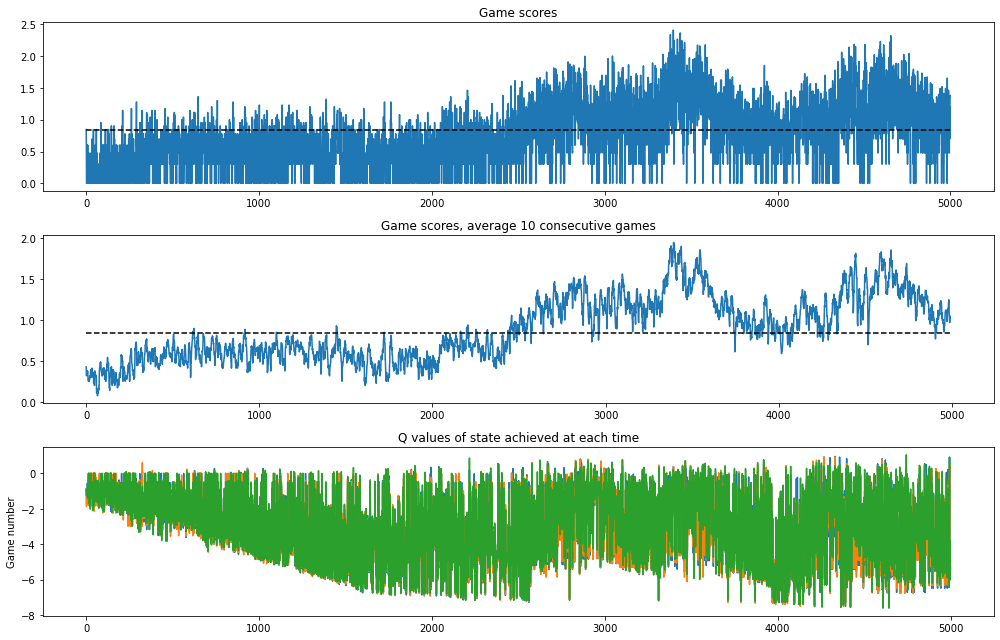

In [72]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 9))
ax = [fig.add_subplot(3, 1, x) for x in range(1, 4)]
ax[0].plot(np.arange(0, len(scores)), np.log10(1 + np.array(scores)))
ax[0].plot([0, 5000], np.log10([7, 7]), 'k--')
ax[0].set_title('Game scores')
ax[1].plot(np.arange(4991), np.log10(1 + np.convolve(np.ones(10) / 10, scores, mode='valid')))
ax[1].plot([0, 4991], np.log10([7, 7]), 'k--')
ax[1].set_title('Game scores, average 10 consecutive games')
ax[2].plot(np.arange(0, len(q_achieved)), q_achieved)
ax[2].set_title('Q values of state achieved at each time')
ax[2].set_ylabel('Game number')

plt.tight_layout()
plt.show()


Hooray, it has learned!  If you are getting a ten-game average score of better than 6, then you are ready to submit your model for grading.   In order to do that, you need to save the model:

In [73]:
q_learner.save('trained_model.npz')

<a id='section9'></a>

## Extra Credit

For extra credit, download the file <a href="mp11_extra.zip">mp11_extra.zip</a>.  The only important file in this package is:
* `tests/test_extra.py`: this contains extra tests that will evaluate your pre-trained `deep_q` learner, which should be in a file called `trained_model.pkl`.  For full credit, your model should achieve an average score of greater than 20, averaged over 10 consecutive games. 

With a quantized lookup table, it's probably not possible to achieve an average score of 20.  With a deep-Q learner, however, it is eminently possible.  In order to do the extra credit, therefore, you should just fill in the part of `submitted.py` that implements the `deep_q` learner, using pytorch to define a model structure, train it, save it, load it, and act on it.  This learner only needs to have five methods: `__init__`, `act`, `learn`, `save`, and `load`:

In [5]:
importlib.reload(submitted)
help(submitted.deep_q.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst)
    Create a new deep_q learner.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a deep learning model that will accept
    (state,action) as input, and estimate Q as the output.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of taking a random action
    gamma (scalar) - discount factor
    nfirst (scalar) - exploring each state/action pair nfirst times before exploiting
    @return:
    None



In [6]:
help(submitted.deep_q.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    You are free to determine your own exploration/exploitation policy -- 
    you don't need to use the epsilon and nfirst provided to you.
    
    @params: 
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In [5]:
help(submitted.deep_q.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Perform one iteration of training on a deep-Q model.
    
    @params:
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 floats, in the same format as state
    
    @return:
    None



In [50]:
help(submitted.deep_q.save)

Help on function save in module submitted:

save(self, filename)
    Save your trained deep-Q model to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [6]:
help(submitted.deep_q.load)

Help on function load in module submitted:

load(self, filename)
    Load your deep-Q model from a file.
    This should load from whatever file format your save function
    used.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



In [4]:
import numpy as np
import submitted, importlib
import pong, importlib, submitted
importlib.reload(pong)
importlib.reload(submitted)
help(submitted.q_learner.__init__)

# Create a deep_q instance
deep_q_learner = submitted.deep_q(alpha=0.001, epsilon=0.1, gamma=0.99, nfirst=10)

# Test act function
state = [0.5, 0.5, 0.1, 0.1, 0.5]
action = deep_q_learner.act(state)
assert action in [-1, 0, 1], "act function should return -1, 0, or 1"

# Test learn function
new_state = [0.6, 0.6, 0.1, 0.1, 0.5]
deep_q_learner.learn(state, action, 1, new_state)  # No return value, just checking for errors

# Test save function
deep_q_learner.save("test_model.pth")  # No return value, just checking for errors

# Test load function
deep_q_learner.load("test_model.pth")  # No return value, just checking for errors

# Test report_q function
q_values = deep_q_learner.report_q(state)
assert len(q_values) == 3, "report_q function should return a list of 3 Q-values"
assert isinstance(q_values[0], float), "Q-values should be floats"

print("All tests passed!")

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a Q table and an N table.
    Q[...state..., ...action...] = expected utility of state/action pair.
    N[...state..., ...action...] = # times state/action has been explored.
    Both are initialized to all zeros.
    Up to you: how will you encode the state and action in order to
    define these two lookup tables?  The state will be a list of 5 integers,
    such that 0 <= state[i] < state_cardinality[i] for 0 <= i < 5.
    The action will be either -1, 0, or 1.
    It is up to you to decide how to convert an input state and action
    into indices that you can use to access your stored Q and N tables.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of takin

AttributeError: 'deep_q' object has no attribute 'alpha'

In [ ]:
# Import the necessary modules
import numpy as np
import pong, importlib, submitted
importlib.reload(pong)
importlib.reload(submitted)


# Create a deep_q instance
#epsilon and nfirst is unused here. And alphs is reused as learning rate
deep_q_learner = submitted.deep_q(alpha=0.005, epsilon=0.1, gamma=0.99, nfirst=5)

# Instantiate the PongGame with the deep Q-learner
pong_game = pong.PongGame(learner=deep_q_learner, visible=False,state_quantization=None)

# Run the game and train the deep Q-learner
scores, q_achieved, q_states = pong_game.run(m_rewards=100_00, states=[])

print('The number of games played was', len(scores))
print('The number of rewards was', len(q_achieved))
print('The size of each returned Q-matrix was', q_states[0].shape)

Completed 0 games, 2 rewards, 438 frames, score 1, max score 1
Completed 1 games, 3 rewards, 692 frames, score 0, max score 1
Completed 2 games, 4 rewards, 873 frames, score 0, max score 1
Completed 3 games, 5 rewards, 1127 frames, score 0, max score 1
Completed 4 games, 6 rewards, 1335 frames, score 0, max score 1
Completed 5 games, 7 rewards, 1543 frames, score 0, max score 1
Completed 6 games, 8 rewards, 1724 frames, score 0, max score 1
Completed 7 games, 9 rewards, 1932 frames, score 0, max score 1
Completed 8 games, 10 rewards, 2140 frames, score 0, max score 1
Completed 9 games, 12 rewards, 2658 frames, score 1, max score 1
Completed 10 games, 14 rewards, 3146 frames, score 1, max score 1
Completed 11 games, 15 rewards, 3354 frames, score 0, max score 1
Completed 12 games, 16 rewards, 3608 frames, score 0, max score 1
Completed 13 games, 18 rewards, 4105 frames, score 1, max score 1
Completed 14 games, 19 rewards, 4359 frames, score 0, max score 1
Completed 15 games, 20 rewards,

Completed 123 games, 167 rewards, 38161 frames, score 1, max score 4
Completed 124 games, 168 rewards, 38415 frames, score 0, max score 4
Completed 125 games, 169 rewards, 38669 frames, score 0, max score 4
Completed 126 games, 170 rewards, 38850 frames, score 0, max score 4
Completed 127 games, 172 rewards, 39256 frames, score 1, max score 4
Completed 128 games, 173 rewards, 39464 frames, score 0, max score 4
Completed 129 games, 174 rewards, 39718 frames, score 0, max score 4
Completed 130 games, 175 rewards, 39899 frames, score 0, max score 4
Completed 131 games, 177 rewards, 40267 frames, score 1, max score 4
Completed 132 games, 178 rewards, 40521 frames, score 0, max score 4
Completed 133 games, 179 rewards, 40702 frames, score 0, max score 4
Completed 134 games, 181 rewards, 41253 frames, score 1, max score 4
Completed 135 games, 183 rewards, 41636 frames, score 1, max score 4
Completed 136 games, 184 rewards, 41817 frames, score 0, max score 4
Completed 137 games, 185 rewards, 

Completed 242 games, 316 rewards, 70053 frames, score 0, max score 4
Completed 243 games, 317 rewards, 70261 frames, score 0, max score 4
Completed 244 games, 318 rewards, 70469 frames, score 0, max score 4
Completed 245 games, 320 rewards, 70837 frames, score 1, max score 4
Completed 246 games, 321 rewards, 71018 frames, score 0, max score 4
Completed 247 games, 322 rewards, 71272 frames, score 0, max score 4
Completed 248 games, 323 rewards, 71480 frames, score 0, max score 4
Completed 249 games, 324 rewards, 71661 frames, score 0, max score 4
Completed 250 games, 326 rewards, 72212 frames, score 1, max score 4
Completed 251 games, 327 rewards, 72420 frames, score 0, max score 4
Completed 252 games, 329 rewards, 73010 frames, score 1, max score 4
Completed 253 games, 330 rewards, 73191 frames, score 0, max score 4
Completed 254 games, 331 rewards, 73372 frames, score 0, max score 4
Completed 255 games, 333 rewards, 73877 frames, score 1, max score 4
Completed 256 games, 334 rewards, 

Completed 361 games, 473 rewards, 106233 frames, score 0, max score 4
Completed 362 games, 474 rewards, 106487 frames, score 0, max score 4
Completed 363 games, 477 rewards, 107512 frames, score 2, max score 4
Completed 364 games, 478 rewards, 107766 frames, score 0, max score 4
Completed 365 games, 479 rewards, 107947 frames, score 0, max score 4
Completed 366 games, 480 rewards, 108128 frames, score 0, max score 4
Completed 367 games, 481 rewards, 108336 frames, score 0, max score 4
Completed 368 games, 483 rewards, 108807 frames, score 1, max score 4
Completed 369 games, 484 rewards, 109015 frames, score 0, max score 4
Completed 370 games, 485 rewards, 109196 frames, score 0, max score 4
Completed 371 games, 486 rewards, 109404 frames, score 0, max score 4
Completed 372 games, 488 rewards, 109883 frames, score 1, max score 4
Completed 373 games, 489 rewards, 110064 frames, score 0, max score 4
Completed 374 games, 491 rewards, 110726 frames, score 1, max score 4
Completed 375 games,

Completed 479 games, 629 rewards, 141285 frames, score 0, max score 4
Completed 480 games, 630 rewards, 141466 frames, score 0, max score 4
Completed 481 games, 631 rewards, 141720 frames, score 0, max score 4
Completed 482 games, 632 rewards, 141928 frames, score 0, max score 4
Completed 483 games, 633 rewards, 142109 frames, score 0, max score 4
Completed 484 games, 634 rewards, 142290 frames, score 0, max score 4
Completed 485 games, 635 rewards, 142544 frames, score 0, max score 4
Completed 486 games, 637 rewards, 143041 frames, score 1, max score 4
Completed 487 games, 639 rewards, 143512 frames, score 1, max score 4
Completed 488 games, 640 rewards, 143693 frames, score 0, max score 4
Completed 489 games, 642 rewards, 144227 frames, score 1, max score 4
Completed 490 games, 643 rewards, 144435 frames, score 0, max score 4
Completed 491 games, 646 rewards, 145033 frames, score 2, max score 4
Completed 492 games, 647 rewards, 145287 frames, score 0, max score 4
Completed 493 games,

Completed 597 games, 780 rewards, 176086 frames, score 1, max score 4
Completed 598 games, 781 rewards, 176340 frames, score 0, max score 4
Completed 599 games, 782 rewards, 176521 frames, score 0, max score 4
Completed 600 games, 783 rewards, 176775 frames, score 0, max score 4
Completed 601 games, 785 rewards, 177365 frames, score 1, max score 4
Completed 602 games, 787 rewards, 177825 frames, score 1, max score 4
Completed 603 games, 788 rewards, 178033 frames, score 0, max score 4
Completed 604 games, 789 rewards, 178241 frames, score 0, max score 4
Completed 605 games, 790 rewards, 178449 frames, score 0, max score 4
Completed 606 games, 792 rewards, 179111 frames, score 1, max score 4
Completed 607 games, 794 rewards, 179478 frames, score 1, max score 4
Completed 608 games, 795 rewards, 179686 frames, score 0, max score 4
Completed 609 games, 796 rewards, 179894 frames, score 0, max score 4
Completed 610 games, 798 rewards, 180261 frames, score 1, max score 4
Completed 611 games,

Completed 716 games, 933 rewards, 210456 frames, score 0, max score 4
Completed 717 games, 935 rewards, 210823 frames, score 1, max score 4
Completed 718 games, 936 rewards, 211077 frames, score 0, max score 4
Completed 719 games, 937 rewards, 211285 frames, score 0, max score 4
Completed 720 games, 938 rewards, 211493 frames, score 0, max score 4
Completed 721 games, 939 rewards, 211674 frames, score 0, max score 4
Completed 722 games, 941 rewards, 212102 frames, score 1, max score 4
Completed 723 games, 942 rewards, 212356 frames, score 0, max score 4
Completed 724 games, 943 rewards, 212537 frames, score 0, max score 4
Completed 725 games, 944 rewards, 212791 frames, score 0, max score 4
Completed 726 games, 945 rewards, 212972 frames, score 0, max score 4
Completed 727 games, 946 rewards, 213226 frames, score 0, max score 4
Completed 728 games, 947 rewards, 213480 frames, score 0, max score 4
Completed 729 games, 949 rewards, 213848 frames, score 1, max score 4
Completed 730 games,

Completed 833 games, 1085 rewards, 244191 frames, score 0, max score 4
Completed 834 games, 1086 rewards, 244372 frames, score 0, max score 4
Completed 835 games, 1087 rewards, 244626 frames, score 0, max score 4
Completed 836 games, 1088 rewards, 244834 frames, score 0, max score 4
Completed 837 games, 1089 rewards, 245015 frames, score 0, max score 4
Completed 838 games, 1090 rewards, 245223 frames, score 0, max score 4
Completed 839 games, 1091 rewards, 245431 frames, score 0, max score 4
Completed 840 games, 1092 rewards, 245639 frames, score 0, max score 4
Completed 841 games, 1093 rewards, 245820 frames, score 0, max score 4
Completed 842 games, 1094 rewards, 246001 frames, score 0, max score 4
Completed 843 games, 1095 rewards, 246209 frames, score 0, max score 4
Completed 844 games, 1096 rewards, 246463 frames, score 0, max score 4
Completed 845 games, 1097 rewards, 246644 frames, score 0, max score 4
Completed 846 games, 1098 rewards, 246852 frames, score 0, max score 4
Comple

Completed 949 games, 1230 rewards, 275638 frames, score 1, max score 5
Completed 950 games, 1231 rewards, 275846 frames, score 0, max score 5
Completed 951 games, 1232 rewards, 276054 frames, score 0, max score 5
Completed 952 games, 1233 rewards, 276308 frames, score 0, max score 5
Completed 953 games, 1234 rewards, 276489 frames, score 0, max score 5
Completed 954 games, 1235 rewards, 276670 frames, score 0, max score 5
Completed 955 games, 1236 rewards, 276878 frames, score 0, max score 5
Completed 956 games, 1237 rewards, 277132 frames, score 0, max score 5
Completed 957 games, 1239 rewards, 277595 frames, score 1, max score 5
Completed 958 games, 1240 rewards, 277776 frames, score 0, max score 5
Completed 959 games, 1242 rewards, 278294 frames, score 1, max score 5
Completed 960 games, 1244 rewards, 278476 frames, score 1, max score 5
Completed 961 games, 1245 rewards, 278730 frames, score 0, max score 5
Completed 962 games, 1246 rewards, 278911 frames, score 0, max score 5
Comple

Completed 1064 games, 1379 rewards, 309658 frames, score 0, max score 5
Completed 1065 games, 1380 rewards, 309866 frames, score 0, max score 5
Completed 1066 games, 1382 rewards, 310345 frames, score 1, max score 5
Completed 1067 games, 1383 rewards, 310526 frames, score 0, max score 5
Completed 1068 games, 1384 rewards, 310780 frames, score 0, max score 5
Completed 1069 games, 1385 rewards, 310988 frames, score 0, max score 5
Completed 1070 games, 1386 rewards, 311169 frames, score 0, max score 5
Completed 1071 games, 1387 rewards, 311377 frames, score 0, max score 5
Completed 1072 games, 1388 rewards, 311585 frames, score 0, max score 5
Completed 1073 games, 1389 rewards, 311766 frames, score 0, max score 5
Completed 1074 games, 1391 rewards, 312134 frames, score 1, max score 5
Completed 1075 games, 1395 rewards, 312830 frames, score 3, max score 5
Completed 1076 games, 1396 rewards, 313038 frames, score 0, max score 5
Completed 1077 games, 1397 rewards, 313292 frames, score 0, max 

Completed 1179 games, 1535 rewards, 345780 frames, score 0, max score 5
Completed 1180 games, 1536 rewards, 345988 frames, score 0, max score 5
Completed 1181 games, 1537 rewards, 346242 frames, score 0, max score 5
Completed 1182 games, 1538 rewards, 346450 frames, score 0, max score 5
Completed 1183 games, 1539 rewards, 346704 frames, score 0, max score 5
Completed 1184 games, 1540 rewards, 346912 frames, score 0, max score 5
Completed 1185 games, 1542 rewards, 347409 frames, score 1, max score 5
Completed 1186 games, 1544 rewards, 347875 frames, score 1, max score 5
Completed 1187 games, 1545 rewards, 348056 frames, score 0, max score 5
Completed 1188 games, 1546 rewards, 348264 frames, score 0, max score 5
Completed 1189 games, 1547 rewards, 348472 frames, score 0, max score 5
Completed 1190 games, 1549 rewards, 349062 frames, score 1, max score 5
Completed 1191 games, 1550 rewards, 349270 frames, score 0, max score 5
Completed 1192 games, 1551 rewards, 349524 frames, score 0, max 

Completed 1293 games, 1675 rewards, 376971 frames, score 0, max score 5
Completed 1294 games, 1676 rewards, 377179 frames, score 0, max score 5
Completed 1295 games, 1677 rewards, 377433 frames, score 0, max score 5
Completed 1296 games, 1678 rewards, 377614 frames, score 0, max score 5
Completed 1297 games, 1679 rewards, 377795 frames, score 0, max score 5
Completed 1298 games, 1680 rewards, 378049 frames, score 0, max score 5
Completed 1299 games, 1681 rewards, 378257 frames, score 0, max score 5
Completed 1300 games, 1682 rewards, 378465 frames, score 0, max score 5
Completed 1301 games, 1683 rewards, 378646 frames, score 0, max score 5
Completed 1302 games, 1685 rewards, 379060 frames, score 1, max score 5
Completed 1303 games, 1686 rewards, 379268 frames, score 0, max score 5
Completed 1304 games, 1687 rewards, 379522 frames, score 0, max score 5
Completed 1305 games, 1689 rewards, 379889 frames, score 1, max score 5
Completed 1306 games, 1690 rewards, 380097 frames, score 0, max 

Completed 1407 games, 1813 rewards, 406833 frames, score 0, max score 5
Completed 1408 games, 1814 rewards, 407041 frames, score 0, max score 5
Completed 1409 games, 1815 rewards, 407222 frames, score 0, max score 5
Completed 1410 games, 1817 rewards, 407719 frames, score 1, max score 5
Completed 1411 games, 1819 rewards, 408638 frames, score 1, max score 5
Completed 1412 games, 1820 rewards, 408892 frames, score 0, max score 5
Completed 1413 games, 1821 rewards, 409100 frames, score 0, max score 5
Completed 1414 games, 1822 rewards, 409281 frames, score 0, max score 5
Completed 1415 games, 1824 rewards, 409664 frames, score 1, max score 5
Completed 1416 games, 1825 rewards, 409918 frames, score 0, max score 5
Completed 1417 games, 1826 rewards, 410126 frames, score 0, max score 5
Completed 1418 games, 1827 rewards, 410380 frames, score 0, max score 5
Completed 1419 games, 1828 rewards, 410588 frames, score 0, max score 5
Completed 1420 games, 1829 rewards, 410769 frames, score 0, max 

Completed 1521 games, 1963 rewards, 440956 frames, score 1, max score 5
Completed 1522 games, 1964 rewards, 441210 frames, score 0, max score 5
Completed 1523 games, 1967 rewards, 441579 frames, score 2, max score 5
Completed 1524 games, 1968 rewards, 441787 frames, score 0, max score 5
Completed 1525 games, 1969 rewards, 442041 frames, score 0, max score 5
Completed 1526 games, 1970 rewards, 442295 frames, score 0, max score 5
Completed 1527 games, 1971 rewards, 442549 frames, score 0, max score 5
Completed 1528 games, 1972 rewards, 442757 frames, score 0, max score 5
Completed 1529 games, 1974 rewards, 443220 frames, score 1, max score 5
Completed 1530 games, 1975 rewards, 443474 frames, score 0, max score 5
Completed 1531 games, 1976 rewards, 443655 frames, score 0, max score 5
Completed 1532 games, 1977 rewards, 443863 frames, score 0, max score 5
Completed 1533 games, 1979 rewards, 444045 frames, score 1, max score 5
Completed 1534 games, 1980 rewards, 444299 frames, score 0, max 

Completed 1635 games, 2109 rewards, 472536 frames, score 2, max score 5
Completed 1636 games, 2112 rewards, 473076 frames, score 2, max score 5
Completed 1637 games, 2113 rewards, 473257 frames, score 0, max score 5
Completed 1638 games, 2114 rewards, 473511 frames, score 0, max score 5
Completed 1639 games, 2115 rewards, 473692 frames, score 0, max score 5
Completed 1640 games, 2116 rewards, 473900 frames, score 0, max score 5
Completed 1641 games, 2117 rewards, 474108 frames, score 0, max score 5
Completed 1642 games, 2118 rewards, 474316 frames, score 0, max score 5
Completed 1643 games, 2120 rewards, 474779 frames, score 1, max score 5
Completed 1644 games, 2121 rewards, 475033 frames, score 0, max score 5
Completed 1645 games, 2122 rewards, 475241 frames, score 0, max score 5
Completed 1646 games, 2123 rewards, 475422 frames, score 0, max score 5
Completed 1647 games, 2124 rewards, 475630 frames, score 0, max score 5
Completed 1648 games, 2126 rewards, 476549 frames, score 1, max 

Completed 1750 games, 2274 rewards, 511839 frames, score 0, max score 5
Completed 1751 games, 2275 rewards, 512047 frames, score 0, max score 5
Completed 1752 games, 2277 rewards, 512781 frames, score 1, max score 5
Completed 1753 games, 2278 rewards, 513035 frames, score 0, max score 5
Completed 1754 games, 2279 rewards, 513243 frames, score 0, max score 5
Completed 1755 games, 2280 rewards, 513451 frames, score 0, max score 5
Completed 1756 games, 2281 rewards, 513632 frames, score 0, max score 5
Completed 1757 games, 2282 rewards, 513813 frames, score 0, max score 5
Completed 1758 games, 2283 rewards, 514067 frames, score 0, max score 5
Completed 1759 games, 2284 rewards, 514275 frames, score 0, max score 5
Completed 1760 games, 2285 rewards, 514456 frames, score 0, max score 5
Completed 1761 games, 2286 rewards, 514710 frames, score 0, max score 5
Completed 1762 games, 2287 rewards, 514891 frames, score 0, max score 5
Completed 1763 games, 2288 rewards, 515145 frames, score 0, max 

Completed 1864 games, 2430 rewards, 547730 frames, score 0, max score 5
Completed 1865 games, 2438 rewards, 551513 frames, score 7, max score 7
Completed 1866 games, 2439 rewards, 551694 frames, score 0, max score 7
Completed 1867 games, 2442 rewards, 552670 frames, score 2, max score 7
Completed 1868 games, 2443 rewards, 552851 frames, score 0, max score 7
Completed 1869 games, 2444 rewards, 553105 frames, score 0, max score 7
Completed 1870 games, 2445 rewards, 553313 frames, score 0, max score 7
Completed 1871 games, 2446 rewards, 553521 frames, score 0, max score 7
Completed 1872 games, 2447 rewards, 553702 frames, score 0, max score 7
Completed 1873 games, 2448 rewards, 553956 frames, score 0, max score 7
Completed 1874 games, 2449 rewards, 554210 frames, score 0, max score 7
Completed 1875 games, 2450 rewards, 554418 frames, score 0, max score 7
Completed 1876 games, 2451 rewards, 554672 frames, score 0, max score 7
Completed 1877 games, 2453 rewards, 555132 frames, score 1, max 

Completed 1979 games, 2589 rewards, 586674 frames, score 0, max score 7
Completed 1980 games, 2592 rewards, 587347 frames, score 2, max score 7
Completed 1981 games, 2593 rewards, 587555 frames, score 0, max score 7
Completed 1982 games, 2594 rewards, 587763 frames, score 0, max score 7
Completed 1983 games, 2595 rewards, 588017 frames, score 0, max score 7
Completed 1984 games, 2596 rewards, 588225 frames, score 0, max score 7
Completed 1985 games, 2598 rewards, 588623 frames, score 1, max score 7
Completed 1986 games, 2599 rewards, 588877 frames, score 0, max score 7
Completed 1987 games, 2600 rewards, 589131 frames, score 0, max score 7
Completed 1988 games, 2601 rewards, 589339 frames, score 0, max score 7
Completed 1989 games, 2602 rewards, 589547 frames, score 0, max score 7
Completed 1990 games, 2603 rewards, 589728 frames, score 0, max score 7
Completed 1991 games, 2604 rewards, 589936 frames, score 0, max score 7
Completed 1992 games, 2607 rewards, 590119 frames, score 2, max 

Completed 2093 games, 2738 rewards, 621212 frames, score 0, max score 7
Completed 2094 games, 2739 rewards, 621420 frames, score 0, max score 7
Completed 2095 games, 2740 rewards, 621628 frames, score 0, max score 7
Completed 2096 games, 2741 rewards, 621836 frames, score 0, max score 7
Completed 2097 games, 2742 rewards, 622090 frames, score 0, max score 7
Completed 2098 games, 2743 rewards, 622271 frames, score 0, max score 7
Completed 2099 games, 2744 rewards, 622452 frames, score 0, max score 7
Completed 2100 games, 2746 rewards, 623628 frames, score 1, max score 7
Completed 2101 games, 2747 rewards, 623882 frames, score 0, max score 7
Completed 2102 games, 2748 rewards, 624090 frames, score 0, max score 7
Completed 2103 games, 2749 rewards, 624344 frames, score 0, max score 7
Completed 2104 games, 2751 rewards, 624832 frames, score 1, max score 7
Completed 2105 games, 2752 rewards, 625040 frames, score 0, max score 7
Completed 2106 games, 2753 rewards, 625248 frames, score 0, max 

Completed 2208 games, 2885 rewards, 655504 frames, score 0, max score 7
Completed 2209 games, 2886 rewards, 655685 frames, score 0, max score 7
Completed 2210 games, 2887 rewards, 655893 frames, score 0, max score 7
Completed 2211 games, 2888 rewards, 656074 frames, score 0, max score 7
Completed 2212 games, 2889 rewards, 656282 frames, score 0, max score 7
Completed 2213 games, 2891 rewards, 656858 frames, score 1, max score 7
Completed 2214 games, 2893 rewards, 657226 frames, score 1, max score 7
Completed 2215 games, 2894 rewards, 657434 frames, score 0, max score 7
Completed 2216 games, 2895 rewards, 657615 frames, score 0, max score 7
Completed 2217 games, 2896 rewards, 657869 frames, score 0, max score 7
Completed 2218 games, 2898 rewards, 658471 frames, score 1, max score 7
Completed 2219 games, 2899 rewards, 658725 frames, score 0, max score 7
Completed 2220 games, 2900 rewards, 658906 frames, score 0, max score 7
Completed 2221 games, 2901 rewards, 659087 frames, score 0, max 

Completed 2322 games, 3032 rewards, 687557 frames, score 0, max score 7
Completed 2323 games, 3033 rewards, 687811 frames, score 0, max score 7
Completed 2324 games, 3035 rewards, 688216 frames, score 1, max score 7
Completed 2325 games, 3036 rewards, 688424 frames, score 0, max score 7
Completed 2326 games, 3037 rewards, 688678 frames, score 0, max score 7
Completed 2327 games, 3038 rewards, 688932 frames, score 0, max score 7
Completed 2328 games, 3041 rewards, 689749 frames, score 2, max score 7
Completed 2329 games, 3042 rewards, 690003 frames, score 0, max score 7
Completed 2330 games, 3043 rewards, 690184 frames, score 0, max score 7
Completed 2331 games, 3045 rewards, 690846 frames, score 1, max score 7
Completed 2332 games, 3046 rewards, 691100 frames, score 0, max score 7
Completed 2333 games, 3047 rewards, 691281 frames, score 0, max score 7
Completed 2334 games, 3048 rewards, 691489 frames, score 0, max score 7
Completed 2335 games, 3049 rewards, 691743 frames, score 0, max 

Completed 2436 games, 3188 rewards, 726854 frames, score 0, max score 7
Completed 2437 games, 3190 rewards, 727516 frames, score 1, max score 7
Completed 2438 games, 3191 rewards, 727724 frames, score 0, max score 7
Completed 2439 games, 3192 rewards, 727932 frames, score 0, max score 7
Completed 2440 games, 3193 rewards, 728140 frames, score 0, max score 7
Completed 2441 games, 3194 rewards, 728348 frames, score 0, max score 7
Completed 2442 games, 3195 rewards, 728529 frames, score 0, max score 7
Completed 2443 games, 3196 rewards, 728783 frames, score 0, max score 7
Completed 2444 games, 3197 rewards, 728991 frames, score 0, max score 7
Completed 2445 games, 3198 rewards, 729199 frames, score 0, max score 7
Completed 2446 games, 3199 rewards, 729453 frames, score 0, max score 7
Completed 2447 games, 3201 rewards, 730055 frames, score 1, max score 7
Completed 2448 games, 3203 rewards, 730928 frames, score 1, max score 7
Completed 2449 games, 3206 rewards, 731575 frames, score 2, max 

Completed 2550 games, 3342 rewards, 762640 frames, score 1, max score 7
Completed 2551 games, 3344 rewards, 762981 frames, score 1, max score 7
Completed 2552 games, 3345 rewards, 763162 frames, score 0, max score 7
Completed 2553 games, 3347 rewards, 763599 frames, score 1, max score 7
Completed 2554 games, 3348 rewards, 763807 frames, score 0, max score 7
Completed 2555 games, 3349 rewards, 764061 frames, score 0, max score 7
Completed 2556 games, 3350 rewards, 764269 frames, score 0, max score 7
Completed 2557 games, 3351 rewards, 764523 frames, score 0, max score 7
Completed 2558 games, 3352 rewards, 764704 frames, score 0, max score 7
Completed 2559 games, 3353 rewards, 764885 frames, score 0, max score 7
Completed 2560 games, 3354 rewards, 765139 frames, score 0, max score 7
Completed 2561 games, 3356 rewards, 765321 frames, score 1, max score 7
Completed 2562 games, 3359 rewards, 765835 frames, score 2, max score 7
Completed 2563 games, 3361 rewards, 766754 frames, score 1, max 

Completed 2665 games, 3483 rewards, 794245 frames, score 0, max score 7
Completed 2666 games, 3484 rewards, 794499 frames, score 0, max score 7
Completed 2667 games, 3486 rewards, 794936 frames, score 1, max score 7
Completed 2668 games, 3487 rewards, 795190 frames, score 0, max score 7
Completed 2669 games, 3488 rewards, 795398 frames, score 0, max score 7
Completed 2670 games, 3489 rewards, 795606 frames, score 0, max score 7
Completed 2671 games, 3490 rewards, 795787 frames, score 0, max score 7
Completed 2672 games, 3491 rewards, 795995 frames, score 0, max score 7
Completed 2673 games, 3493 rewards, 796461 frames, score 1, max score 7
Completed 2674 games, 3494 rewards, 796715 frames, score 0, max score 7
Completed 2675 games, 3495 rewards, 796969 frames, score 0, max score 7
Completed 2676 games, 3496 rewards, 797150 frames, score 0, max score 7
Completed 2677 games, 3498 rewards, 797740 frames, score 1, max score 7
Completed 2678 games, 3499 rewards, 797948 frames, score 0, max 

Completed 2779 games, 3638 rewards, 830053 frames, score 1, max score 7
Completed 2780 games, 3639 rewards, 830261 frames, score 0, max score 7
Completed 2781 games, 3640 rewards, 830442 frames, score 0, max score 7
Completed 2782 games, 3641 rewards, 830623 frames, score 0, max score 7
Completed 2783 games, 3642 rewards, 830877 frames, score 0, max score 7
Completed 2784 games, 3643 rewards, 831131 frames, score 0, max score 7
Completed 2785 games, 3644 rewards, 831385 frames, score 0, max score 7
Completed 2786 games, 3645 rewards, 831639 frames, score 0, max score 7
Completed 2787 games, 3646 rewards, 831820 frames, score 0, max score 7
Completed 2788 games, 3648 rewards, 832257 frames, score 1, max score 7
Completed 2789 games, 3649 rewards, 832511 frames, score 0, max score 7
Completed 2790 games, 3650 rewards, 832719 frames, score 0, max score 7
Completed 2791 games, 3653 rewards, 833294 frames, score 2, max score 7
Completed 2792 games, 3657 rewards, 834015 frames, score 3, max 

Completed 2893 games, 3797 rewards, 864643 frames, score 0, max score 7
Completed 2894 games, 3798 rewards, 864897 frames, score 0, max score 7
Completed 2895 games, 3799 rewards, 865078 frames, score 0, max score 7
Completed 2896 games, 3801 rewards, 865492 frames, score 1, max score 7
Completed 2897 games, 3802 rewards, 865746 frames, score 0, max score 7
Completed 2898 games, 3804 rewards, 866162 frames, score 1, max score 7
Completed 2899 games, 3805 rewards, 866370 frames, score 0, max score 7
Completed 2900 games, 3806 rewards, 866624 frames, score 0, max score 7
Completed 2901 games, 3807 rewards, 866878 frames, score 0, max score 7
Completed 2902 games, 3808 rewards, 867132 frames, score 0, max score 7
Completed 2903 games, 3810 rewards, 867515 frames, score 1, max score 7
Completed 2904 games, 3812 rewards, 867882 frames, score 1, max score 7
Completed 2905 games, 3813 rewards, 868063 frames, score 0, max score 7
Completed 2906 games, 3814 rewards, 868244 frames, score 0, max 

Completed 3007 games, 3941 rewards, 896789 frames, score 1, max score 7
Completed 3008 games, 3942 rewards, 896997 frames, score 0, max score 7
Completed 3009 games, 3944 rewards, 897599 frames, score 1, max score 7
Completed 3010 games, 3945 rewards, 897853 frames, score 0, max score 7
Completed 3011 games, 3946 rewards, 898034 frames, score 0, max score 7
Completed 3012 games, 3949 rewards, 898645 frames, score 2, max score 7
Completed 3013 games, 3950 rewards, 898853 frames, score 0, max score 7
Completed 3014 games, 3951 rewards, 899107 frames, score 0, max score 7
Completed 3015 games, 3952 rewards, 899361 frames, score 0, max score 7
Completed 3016 games, 3953 rewards, 899615 frames, score 0, max score 7
Completed 3017 games, 3954 rewards, 899869 frames, score 0, max score 7
Completed 3018 games, 3955 rewards, 900050 frames, score 0, max score 7
Completed 3019 games, 3956 rewards, 900231 frames, score 0, max score 7
Completed 3020 games, 3957 rewards, 900485 frames, score 0, max 

Completed 3121 games, 4090 rewards, 929824 frames, score 0, max score 7
Completed 3122 games, 4092 rewards, 930252 frames, score 1, max score 7
Completed 3123 games, 4093 rewards, 930433 frames, score 0, max score 7
Completed 3124 games, 4094 rewards, 930687 frames, score 0, max score 7
Completed 3125 games, 4096 rewards, 931303 frames, score 1, max score 7
Completed 3126 games, 4098 rewards, 931740 frames, score 1, max score 7
Completed 3127 games, 4100 rewards, 932108 frames, score 1, max score 7
Completed 3128 games, 4101 rewards, 932362 frames, score 0, max score 7
Completed 3129 games, 4103 rewards, 932841 frames, score 1, max score 7
Completed 3130 games, 4104 rewards, 933022 frames, score 0, max score 7
Completed 3131 games, 4105 rewards, 933203 frames, score 0, max score 7
Completed 3132 games, 4106 rewards, 933384 frames, score 0, max score 7
Completed 3133 games, 4108 rewards, 933566 frames, score 1, max score 7
Completed 3134 games, 4109 rewards, 933747 frames, score 0, max 

Completed 3236 games, 4249 rewards, 965773 frames, score 0, max score 7
Completed 3237 games, 4250 rewards, 965981 frames, score 0, max score 7
Completed 3238 games, 4251 rewards, 966189 frames, score 0, max score 7
Completed 3239 games, 4253 rewards, 966686 frames, score 1, max score 7
Completed 3240 games, 4254 rewards, 966867 frames, score 0, max score 7
Completed 3241 games, 4257 rewards, 967730 frames, score 2, max score 7
Completed 3242 games, 4258 rewards, 967911 frames, score 0, max score 7
Completed 3243 games, 4259 rewards, 968165 frames, score 0, max score 7
Completed 3244 games, 4260 rewards, 968346 frames, score 0, max score 7
Completed 3245 games, 4262 rewards, 968858 frames, score 1, max score 7
Completed 3246 games, 4263 rewards, 969112 frames, score 0, max score 7
Completed 3247 games, 4267 rewards, 969921 frames, score 3, max score 7
Completed 3248 games, 4268 rewards, 970102 frames, score 0, max score 7
Completed 3249 games, 4270 rewards, 970489 frames, score 1, max 

Completed 3351 games, 4407 rewards, 1000233 frames, score 0, max score 7
Completed 3352 games, 4408 rewards, 1000487 frames, score 0, max score 7
Completed 3353 games, 4409 rewards, 1000668 frames, score 0, max score 7
Completed 3354 games, 4410 rewards, 1000922 frames, score 0, max score 7
Completed 3355 games, 4412 rewards, 1001419 frames, score 1, max score 7
Completed 3356 games, 4414 rewards, 1001898 frames, score 1, max score 7
Completed 3357 games, 4415 rewards, 1002106 frames, score 0, max score 7
Completed 3358 games, 4416 rewards, 1002287 frames, score 0, max score 7
Completed 3359 games, 4420 rewards, 1003063 frames, score 3, max score 7
Completed 3360 games, 4422 rewards, 1003523 frames, score 1, max score 7
Completed 3361 games, 4423 rewards, 1003731 frames, score 0, max score 7
Completed 3362 games, 4424 rewards, 1003985 frames, score 0, max score 7
Completed 3363 games, 4425 rewards, 1004193 frames, score 0, max score 7
Completed 3364 games, 4426 rewards, 1004447 frames,

Completed 3465 games, 4568 rewards, 1036357 frames, score 0, max score 7
Completed 3466 games, 4569 rewards, 1036538 frames, score 0, max score 7
Completed 3467 games, 4575 rewards, 1038423 frames, score 5, max score 7
Completed 3468 games, 4576 rewards, 1038604 frames, score 0, max score 7
Completed 3469 games, 4578 rewards, 1039044 frames, score 1, max score 7
Completed 3470 games, 4580 rewards, 1039415 frames, score 1, max score 7
Completed 3471 games, 4581 rewards, 1039669 frames, score 0, max score 7
Completed 3472 games, 4583 rewards, 1040047 frames, score 1, max score 7
Completed 3473 games, 4585 rewards, 1040399 frames, score 1, max score 7
Completed 3474 games, 4586 rewards, 1040580 frames, score 0, max score 7
Completed 3475 games, 4588 rewards, 1041077 frames, score 1, max score 7
Completed 3476 games, 4590 rewards, 1041556 frames, score 1, max score 7
Completed 3477 games, 4591 rewards, 1041737 frames, score 0, max score 7
Completed 3478 games, 4592 rewards, 1041918 frames,

Completed 3578 games, 4724 rewards, 1074822 frames, score 1, max score 7
Completed 3579 games, 4725 rewards, 1075003 frames, score 0, max score 7
Completed 3580 games, 4726 rewards, 1075211 frames, score 0, max score 7
Completed 3581 games, 4727 rewards, 1075419 frames, score 0, max score 7
Completed 3582 games, 4728 rewards, 1075673 frames, score 0, max score 7
Completed 3583 games, 4730 rewards, 1076083 frames, score 1, max score 7
Completed 3584 games, 4731 rewards, 1076291 frames, score 0, max score 7
Completed 3585 games, 4732 rewards, 1076545 frames, score 0, max score 7
Completed 3586 games, 4733 rewards, 1076799 frames, score 0, max score 7
Completed 3587 games, 4734 rewards, 1077053 frames, score 0, max score 7
Completed 3588 games, 4735 rewards, 1077261 frames, score 0, max score 7
Completed 3589 games, 4736 rewards, 1077442 frames, score 0, max score 7
Completed 3590 games, 4737 rewards, 1077696 frames, score 0, max score 7
Completed 3591 games, 4741 rewards, 1078515 frames,

Completed 3691 games, 4871 rewards, 1107508 frames, score 1, max score 7
Completed 3692 games, 4872 rewards, 1107716 frames, score 0, max score 7
Completed 3693 games, 4873 rewards, 1107897 frames, score 0, max score 7
Completed 3694 games, 4874 rewards, 1108105 frames, score 0, max score 7
Completed 3695 games, 4875 rewards, 1108313 frames, score 0, max score 7
Completed 3696 games, 4876 rewards, 1108521 frames, score 0, max score 7
Completed 3697 games, 4877 rewards, 1108775 frames, score 0, max score 7
Completed 3698 games, 4878 rewards, 1109029 frames, score 0, max score 7
Completed 3699 games, 4879 rewards, 1109283 frames, score 0, max score 7
Completed 3700 games, 4882 rewards, 1109782 frames, score 2, max score 7
Completed 3701 games, 4883 rewards, 1110036 frames, score 0, max score 7
Completed 3702 games, 4884 rewards, 1110217 frames, score 0, max score 7
Completed 3703 games, 4885 rewards, 1110398 frames, score 0, max score 7
Completed 3704 games, 4886 rewards, 1110606 frames,

Completed 3804 games, 5032 rewards, 1144628 frames, score 0, max score 7
Completed 3805 games, 5033 rewards, 1144836 frames, score 0, max score 7
Completed 3806 games, 5034 rewards, 1145044 frames, score 0, max score 7
Completed 3807 games, 5035 rewards, 1145252 frames, score 0, max score 7
Completed 3808 games, 5037 rewards, 1145749 frames, score 1, max score 7
Completed 3809 games, 5039 rewards, 1146186 frames, score 1, max score 7
Completed 3810 games, 5040 rewards, 1146394 frames, score 0, max score 7
Completed 3811 games, 5042 rewards, 1146576 frames, score 1, max score 7
Completed 3812 games, 5043 rewards, 1146784 frames, score 0, max score 7
Completed 3813 games, 5044 rewards, 1146992 frames, score 0, max score 7
Completed 3814 games, 5045 rewards, 1147200 frames, score 0, max score 7
Completed 3815 games, 5048 rewards, 1147723 frames, score 2, max score 7
Completed 3816 games, 5050 rewards, 1148235 frames, score 1, max score 7
Completed 3817 games, 5051 rewards, 1148416 frames,

Completed 3917 games, 5187 rewards, 1182026 frames, score 1, max score 7
Completed 3918 games, 5189 rewards, 1182523 frames, score 1, max score 7
Completed 3919 games, 5190 rewards, 1182777 frames, score 0, max score 7
Completed 3920 games, 5193 rewards, 1183666 frames, score 2, max score 7
Completed 3921 games, 5194 rewards, 1183847 frames, score 0, max score 7
Completed 3922 games, 5197 rewards, 1184823 frames, score 2, max score 7
Completed 3923 games, 5198 rewards, 1185077 frames, score 0, max score 7
Completed 3924 games, 5200 rewards, 1185259 frames, score 1, max score 7
Completed 3925 games, 5204 rewards, 1185990 frames, score 3, max score 7
Completed 3926 games, 5205 rewards, 1186171 frames, score 0, max score 7
Completed 3927 games, 5207 rewards, 1186554 frames, score 1, max score 7
Completed 3928 games, 5208 rewards, 1186735 frames, score 0, max score 7
Completed 3929 games, 5209 rewards, 1186916 frames, score 0, max score 7
Completed 3930 games, 5210 rewards, 1187097 frames,

Completed 4031 games, 5333 rewards, 1214780 frames, score 0, max score 7
Completed 4032 games, 5334 rewards, 1214988 frames, score 0, max score 7
Completed 4033 games, 5336 rewards, 1215578 frames, score 1, max score 7
Completed 4034 games, 5337 rewards, 1215786 frames, score 0, max score 7
Completed 4035 games, 5338 rewards, 1215967 frames, score 0, max score 7
Completed 4036 games, 5339 rewards, 1216221 frames, score 0, max score 7
Completed 4037 games, 5340 rewards, 1216429 frames, score 0, max score 7
Completed 4038 games, 5341 rewards, 1216637 frames, score 0, max score 7
Completed 4039 games, 5342 rewards, 1216845 frames, score 0, max score 7
Completed 4040 games, 5343 rewards, 1217099 frames, score 0, max score 7
Completed 4041 games, 5345 rewards, 1217527 frames, score 1, max score 7
Completed 4042 games, 5347 rewards, 1218039 frames, score 1, max score 7
Completed 4043 games, 5348 rewards, 1218293 frames, score 0, max score 7
Completed 4044 games, 5349 rewards, 1218547 frames,

Completed 4145 games, 5481 rewards, 1246849 frames, score 1, max score 7
Completed 4146 games, 5482 rewards, 1247103 frames, score 0, max score 7
Completed 4147 games, 5483 rewards, 1247284 frames, score 0, max score 7
Completed 4148 games, 5484 rewards, 1247538 frames, score 0, max score 7
Completed 4149 games, 5486 rewards, 1248457 frames, score 1, max score 7
Completed 4150 games, 5487 rewards, 1248711 frames, score 0, max score 7
Completed 4151 games, 5491 rewards, 1249902 frames, score 3, max score 7
Completed 4152 games, 5493 rewards, 1250084 frames, score 1, max score 7
Completed 4153 games, 5494 rewards, 1250338 frames, score 0, max score 7
Completed 4154 games, 5495 rewards, 1250546 frames, score 0, max score 7
Completed 4155 games, 5496 rewards, 1250754 frames, score 0, max score 7
Completed 4156 games, 5497 rewards, 1250935 frames, score 0, max score 7
Completed 4157 games, 5498 rewards, 1251143 frames, score 0, max score 7
Completed 4158 games, 5499 rewards, 1251397 frames,

Completed 4258 games, 5627 rewards, 1280438 frames, score 0, max score 7
Completed 4259 games, 5628 rewards, 1280692 frames, score 0, max score 7
Completed 4260 games, 5629 rewards, 1280873 frames, score 0, max score 7
Completed 4261 games, 5631 rewards, 1281373 frames, score 1, max score 7
Completed 4262 games, 5632 rewards, 1281554 frames, score 0, max score 7
Completed 4263 games, 5633 rewards, 1281762 frames, score 0, max score 7
Completed 4264 games, 5634 rewards, 1282016 frames, score 0, max score 7
Completed 4265 games, 5635 rewards, 1282197 frames, score 0, max score 7
Completed 4266 games, 5636 rewards, 1282451 frames, score 0, max score 7
Completed 4267 games, 5639 rewards, 1283319 frames, score 2, max score 7
Completed 4268 games, 5640 rewards, 1283527 frames, score 0, max score 7
Completed 4269 games, 5641 rewards, 1283781 frames, score 0, max score 7
Completed 4270 games, 5642 rewards, 1283962 frames, score 0, max score 7
Completed 4271 games, 5643 rewards, 1284143 frames,

Completed 4371 games, 5768 rewards, 1311562 frames, score 0, max score 7
Completed 4372 games, 5769 rewards, 1311770 frames, score 0, max score 7
Completed 4373 games, 5771 rewards, 1312137 frames, score 1, max score 7
Completed 4374 games, 5772 rewards, 1312391 frames, score 0, max score 7
Completed 4375 games, 5773 rewards, 1312645 frames, score 0, max score 7
Completed 4376 games, 5774 rewards, 1312899 frames, score 0, max score 7
Completed 4377 games, 5775 rewards, 1313080 frames, score 0, max score 7
Completed 4378 games, 5776 rewards, 1313334 frames, score 0, max score 7
Completed 4379 games, 5779 rewards, 1313987 frames, score 2, max score 7
Completed 4380 games, 5781 rewards, 1314333 frames, score 1, max score 7
Completed 4381 games, 5782 rewards, 1314587 frames, score 0, max score 7
Completed 4382 games, 5783 rewards, 1314795 frames, score 0, max score 7
Completed 4383 games, 5784 rewards, 1315049 frames, score 0, max score 7
Completed 4384 games, 5785 rewards, 1315257 frames,

Completed 4484 games, 5936 rewards, 1349847 frames, score 1, max score 7
Completed 4485 games, 5937 rewards, 1350055 frames, score 0, max score 7
Completed 4486 games, 5938 rewards, 1350309 frames, score 0, max score 7
Completed 4487 games, 5939 rewards, 1350517 frames, score 0, max score 7
Completed 4488 games, 5940 rewards, 1350725 frames, score 0, max score 7
Completed 4489 games, 5941 rewards, 1350979 frames, score 0, max score 7
Completed 4490 games, 5943 rewards, 1351569 frames, score 1, max score 7
Completed 4491 games, 5944 rewards, 1351777 frames, score 0, max score 7
Completed 4492 games, 5945 rewards, 1352031 frames, score 0, max score 7
Completed 4493 games, 5946 rewards, 1352285 frames, score 0, max score 7
Completed 4494 games, 5948 rewards, 1352887 frames, score 1, max score 7
Completed 4495 games, 5949 rewards, 1353068 frames, score 0, max score 7
Completed 4496 games, 5950 rewards, 1353322 frames, score 0, max score 7
Completed 4497 games, 5952 rewards, 1353834 frames,

Completed 4597 games, 6085 rewards, 1386301 frames, score 1, max score 7
Completed 4598 games, 6089 rewards, 1387237 frames, score 3, max score 7
Completed 4599 games, 6091 rewards, 1387788 frames, score 1, max score 7
Completed 4600 games, 6092 rewards, 1387996 frames, score 0, max score 7
Completed 4601 games, 6093 rewards, 1388177 frames, score 0, max score 7
Completed 4602 games, 6094 rewards, 1388385 frames, score 0, max score 7
Completed 4603 games, 6095 rewards, 1388566 frames, score 0, max score 7
Completed 4604 games, 6096 rewards, 1388774 frames, score 0, max score 7
Completed 4605 games, 6097 rewards, 1388982 frames, score 0, max score 7
Completed 4606 games, 6101 rewards, 1389619 frames, score 3, max score 7
Completed 4607 games, 6104 rewards, 1390133 frames, score 2, max score 7
Completed 4608 games, 6106 rewards, 1390723 frames, score 1, max score 7
Completed 4609 games, 6107 rewards, 1390977 frames, score 0, max score 7
Completed 4610 games, 6108 rewards, 1391231 frames,

Completed 4710 games, 6247 rewards, 1422796 frames, score 0, max score 7
Completed 4711 games, 6248 rewards, 1422977 frames, score 0, max score 7
Completed 4712 games, 6249 rewards, 1423185 frames, score 0, max score 7
Completed 4713 games, 6251 rewards, 1423622 frames, score 1, max score 7
Completed 4714 games, 6252 rewards, 1423830 frames, score 0, max score 7
Completed 4715 games, 6253 rewards, 1424084 frames, score 0, max score 7
Completed 4716 games, 6254 rewards, 1424265 frames, score 0, max score 7
Completed 4717 games, 6255 rewards, 1424446 frames, score 0, max score 7
Completed 4718 games, 6257 rewards, 1425134 frames, score 1, max score 7
Completed 4719 games, 6259 rewards, 1425646 frames, score 1, max score 7
Completed 4720 games, 6261 rewards, 1426308 frames, score 1, max score 7
Completed 4721 games, 6262 rewards, 1426489 frames, score 0, max score 7
Completed 4722 games, 6264 rewards, 1426830 frames, score 1, max score 7
Completed 4723 games, 6265 rewards, 1427038 frames,

Completed 4823 games, 6393 rewards, 1454502 frames, score 1, max score 7
Completed 4824 games, 6394 rewards, 1454710 frames, score 0, max score 7
Completed 4825 games, 6395 rewards, 1454964 frames, score 0, max score 7
Completed 4826 games, 6396 rewards, 1455172 frames, score 0, max score 7
Completed 4827 games, 6397 rewards, 1455353 frames, score 0, max score 7
Completed 4828 games, 6398 rewards, 1455534 frames, score 0, max score 7
Completed 4829 games, 6399 rewards, 1455788 frames, score 0, max score 7
Completed 4830 games, 6401 rewards, 1456202 frames, score 1, max score 7
Completed 4831 games, 6402 rewards, 1456456 frames, score 0, max score 7
Completed 4832 games, 6403 rewards, 1456710 frames, score 0, max score 7
Completed 4833 games, 6404 rewards, 1456891 frames, score 0, max score 7
Completed 4834 games, 6405 rewards, 1457145 frames, score 0, max score 7
Completed 4835 games, 6406 rewards, 1457353 frames, score 0, max score 7
Completed 4836 games, 6407 rewards, 1457534 frames,

Completed 4936 games, 6549 rewards, 1489133 frames, score 0, max score 7
Completed 4937 games, 6550 rewards, 1489387 frames, score 0, max score 7
Completed 4938 games, 6551 rewards, 1489595 frames, score 0, max score 7
Completed 4939 games, 6552 rewards, 1489803 frames, score 0, max score 7
Completed 4940 games, 6554 rewards, 1490311 frames, score 1, max score 7
Completed 4941 games, 6555 rewards, 1490519 frames, score 0, max score 7
Completed 4942 games, 6556 rewards, 1490700 frames, score 0, max score 7
Completed 4943 games, 6557 rewards, 1490954 frames, score 0, max score 7
Completed 4944 games, 6558 rewards, 1491162 frames, score 0, max score 7
Completed 4945 games, 6560 rewards, 1491667 frames, score 1, max score 7
Completed 4946 games, 6561 rewards, 1491875 frames, score 0, max score 7
Completed 4947 games, 6562 rewards, 1492129 frames, score 0, max score 7
Completed 4948 games, 6563 rewards, 1492337 frames, score 0, max score 7
Completed 4949 games, 6564 rewards, 1492591 frames,

Completed 5050 games, 6709 rewards, 1527099 frames, score 3, max score 7
Completed 5051 games, 6710 rewards, 1527280 frames, score 0, max score 7
Completed 5052 games, 6711 rewards, 1527488 frames, score 0, max score 7
Completed 5053 games, 6712 rewards, 1527696 frames, score 0, max score 7
Completed 5054 games, 6713 rewards, 1527877 frames, score 0, max score 7
Completed 5055 games, 6714 rewards, 1528058 frames, score 0, max score 7
Completed 5056 games, 6715 rewards, 1528312 frames, score 0, max score 7
Completed 5057 games, 6717 rewards, 1528717 frames, score 1, max score 7
Completed 5058 games, 6718 rewards, 1528971 frames, score 0, max score 7
Completed 5059 games, 6720 rewards, 1529479 frames, score 1, max score 7
Completed 5060 games, 6721 rewards, 1529733 frames, score 0, max score 7
Completed 5061 games, 6722 rewards, 1529987 frames, score 0, max score 7
Completed 5062 games, 6723 rewards, 1530195 frames, score 0, max score 7
Completed 5063 games, 6724 rewards, 1530449 frames,

Completed 5164 games, 6853 rewards, 1559434 frames, score 0, max score 7
Completed 5165 games, 6854 rewards, 1559615 frames, score 0, max score 7
Completed 5166 games, 6855 rewards, 1559823 frames, score 0, max score 7
Completed 5167 games, 6856 rewards, 1560004 frames, score 0, max score 7
Completed 5168 games, 6858 rewards, 1560428 frames, score 1, max score 7
Completed 5169 games, 6859 rewards, 1560609 frames, score 0, max score 7
Completed 5170 games, 6860 rewards, 1560817 frames, score 0, max score 7
Completed 5171 games, 6862 rewards, 1561551 frames, score 1, max score 7
Completed 5172 games, 6863 rewards, 1561759 frames, score 0, max score 7
Completed 5173 games, 6864 rewards, 1562013 frames, score 0, max score 7
Completed 5174 games, 6866 rewards, 1562525 frames, score 1, max score 7
Completed 5175 games, 6867 rewards, 1562733 frames, score 0, max score 7
Completed 5176 games, 6868 rewards, 1562941 frames, score 0, max score 7
Completed 5177 games, 6869 rewards, 1563149 frames,

Completed 5277 games, 7011 rewards, 1595153 frames, score 1, max score 7
Completed 5278 games, 7012 rewards, 1595361 frames, score 0, max score 7
Completed 5279 games, 7013 rewards, 1595569 frames, score 0, max score 7
Completed 5280 games, 7015 rewards, 1595751 frames, score 1, max score 7
Completed 5281 games, 7016 rewards, 1596005 frames, score 0, max score 7
Completed 5282 games, 7017 rewards, 1596259 frames, score 0, max score 7
Completed 5283 games, 7018 rewards, 1596440 frames, score 0, max score 7
Completed 5284 games, 7019 rewards, 1596694 frames, score 0, max score 7
Completed 5285 games, 7021 rewards, 1597182 frames, score 1, max score 7
Completed 5286 games, 7022 rewards, 1597390 frames, score 0, max score 7
Completed 5287 games, 7024 rewards, 1597992 frames, score 1, max score 7
Completed 5288 games, 7025 rewards, 1598200 frames, score 0, max score 7
Completed 5289 games, 7026 rewards, 1598381 frames, score 0, max score 7
Completed 5290 games, 7027 rewards, 1598635 frames,

Completed 5390 games, 7160 rewards, 1628756 frames, score 0, max score 7
Completed 5391 games, 7161 rewards, 1628964 frames, score 0, max score 7
Completed 5392 games, 7163 rewards, 1629566 frames, score 1, max score 7
Completed 5393 games, 7164 rewards, 1629747 frames, score 0, max score 7
Completed 5394 games, 7165 rewards, 1629955 frames, score 0, max score 7
Completed 5395 games, 7166 rewards, 1630163 frames, score 0, max score 7
Completed 5396 games, 7167 rewards, 1630344 frames, score 0, max score 7
Completed 5397 games, 7169 rewards, 1631263 frames, score 1, max score 7
Completed 5398 games, 7170 rewards, 1631471 frames, score 0, max score 7
Completed 5399 games, 7171 rewards, 1631679 frames, score 0, max score 7
Completed 5400 games, 7172 rewards, 1631887 frames, score 0, max score 7
Completed 5401 games, 7173 rewards, 1632095 frames, score 0, max score 7
Completed 5402 games, 7174 rewards, 1632349 frames, score 0, max score 7
Completed 5403 games, 7175 rewards, 1632557 frames,

Completed 5504 games, 7309 rewards, 1663008 frames, score 1, max score 7
Completed 5505 games, 7310 rewards, 1663262 frames, score 0, max score 7
Completed 5506 games, 7311 rewards, 1663443 frames, score 0, max score 7
Completed 5507 games, 7312 rewards, 1663624 frames, score 0, max score 7
Completed 5508 games, 7313 rewards, 1663805 frames, score 0, max score 7
Completed 5509 games, 7314 rewards, 1664013 frames, score 0, max score 7
Completed 5510 games, 7315 rewards, 1664221 frames, score 0, max score 7
Completed 5511 games, 7316 rewards, 1664402 frames, score 0, max score 7
Completed 5512 games, 7317 rewards, 1664583 frames, score 0, max score 7
Completed 5513 games, 7318 rewards, 1664837 frames, score 0, max score 7
Completed 5514 games, 7319 rewards, 1665091 frames, score 0, max score 7
Completed 5515 games, 7321 rewards, 1665273 frames, score 1, max score 7
Completed 5516 games, 7322 rewards, 1665454 frames, score 0, max score 7
Completed 5517 games, 7325 rewards, 1666225 frames,

Completed 5616 games, 7450 rewards, 1693321 frames, score 0, max score 7
Completed 5617 games, 7451 rewards, 1693502 frames, score 0, max score 7
Completed 5618 games, 7453 rewards, 1694036 frames, score 1, max score 7
Completed 5619 games, 7454 rewards, 1694217 frames, score 0, max score 7
Completed 5620 games, 7455 rewards, 1694425 frames, score 0, max score 7
Completed 5621 games, 7456 rewards, 1694633 frames, score 0, max score 7
Completed 5622 games, 7457 rewards, 1694841 frames, score 0, max score 7
Completed 5623 games, 7458 rewards, 1695022 frames, score 0, max score 7
Completed 5624 games, 7459 rewards, 1695230 frames, score 0, max score 7
Completed 5625 games, 7460 rewards, 1695484 frames, score 0, max score 7
Completed 5626 games, 7462 rewards, 1695836 frames, score 1, max score 7
Completed 5627 games, 7463 rewards, 1696090 frames, score 0, max score 7
Completed 5628 games, 7464 rewards, 1696298 frames, score 0, max score 7
Completed 5629 games, 7466 rewards, 1696761 frames,

Completed 5730 games, 7599 rewards, 1725841 frames, score 0, max score 7
Completed 5731 games, 7600 rewards, 1726049 frames, score 0, max score 7
Completed 5732 games, 7603 rewards, 1726690 frames, score 2, max score 7
Completed 5733 games, 7604 rewards, 1726871 frames, score 0, max score 7
Completed 5734 games, 7606 rewards, 1727334 frames, score 1, max score 7
Completed 5735 games, 7607 rewards, 1727542 frames, score 0, max score 7
Completed 5736 games, 7608 rewards, 1727723 frames, score 0, max score 7
Completed 5737 games, 7609 rewards, 1727931 frames, score 0, max score 7
Completed 5738 games, 7610 rewards, 1728139 frames, score 0, max score 7
Completed 5739 games, 7612 rewards, 1728321 frames, score 1, max score 7
Completed 5740 games, 7613 rewards, 1728529 frames, score 0, max score 7
Completed 5741 games, 7614 rewards, 1728710 frames, score 0, max score 7
Completed 5742 games, 7615 rewards, 1728918 frames, score 0, max score 7
Completed 5743 games, 7616 rewards, 1729099 frames,

Completed 5843 games, 7749 rewards, 1759337 frames, score 1, max score 7
Completed 5844 games, 7750 rewards, 1759545 frames, score 0, max score 7
Completed 5845 games, 7751 rewards, 1759753 frames, score 0, max score 7
Completed 5846 games, 7752 rewards, 1759961 frames, score 0, max score 7
Completed 5847 games, 7753 rewards, 1760142 frames, score 0, max score 7
Completed 5848 games, 7754 rewards, 1760396 frames, score 0, max score 7
Completed 5849 games, 7755 rewards, 1760577 frames, score 0, max score 7
Completed 5850 games, 7756 rewards, 1760758 frames, score 0, max score 7
Completed 5851 games, 7757 rewards, 1760966 frames, score 0, max score 7
Completed 5852 games, 7758 rewards, 1761147 frames, score 0, max score 7
Completed 5853 games, 7760 rewards, 1761553 frames, score 1, max score 7
Completed 5854 games, 7763 rewards, 1762128 frames, score 2, max score 7
Completed 5855 games, 7765 rewards, 1763001 frames, score 1, max score 7
Completed 5856 games, 7766 rewards, 1763182 frames,

Completed 5956 games, 7911 rewards, 1795672 frames, score 0, max score 7
Completed 5957 games, 7912 rewards, 1795853 frames, score 0, max score 7
Completed 5958 games, 7914 rewards, 1796443 frames, score 1, max score 7
Completed 5959 games, 7915 rewards, 1796651 frames, score 0, max score 7
Completed 5960 games, 7916 rewards, 1796905 frames, score 0, max score 7
Completed 5961 games, 7917 rewards, 1797086 frames, score 0, max score 7
Completed 5962 games, 7918 rewards, 1797267 frames, score 0, max score 7
Completed 5963 games, 7919 rewards, 1797475 frames, score 0, max score 7
Completed 5964 games, 7920 rewards, 1797656 frames, score 0, max score 7
Completed 5965 games, 7923 rewards, 1799358 frames, score 2, max score 7
Completed 5966 games, 7925 rewards, 1799829 frames, score 1, max score 7
Completed 5967 games, 7927 rewards, 1800292 frames, score 1, max score 7
Completed 5968 games, 7930 rewards, 1800965 frames, score 2, max score 7
Completed 5969 games, 7931 rewards, 1801219 frames,

Completed 6069 games, 8051 rewards, 1828468 frames, score 0, max score 7
Completed 6070 games, 8052 rewards, 1828722 frames, score 0, max score 7
Completed 6071 games, 8053 rewards, 1828976 frames, score 0, max score 7
Completed 6072 games, 8056 rewards, 1829611 frames, score 2, max score 7
Completed 6073 games, 8057 rewards, 1829792 frames, score 0, max score 7
Completed 6074 games, 8059 rewards, 1830229 frames, score 1, max score 7
Completed 6075 games, 8061 rewards, 1830726 frames, score 1, max score 7
Completed 6076 games, 8062 rewards, 1830980 frames, score 0, max score 7
Completed 6077 games, 8063 rewards, 1831161 frames, score 0, max score 7
Completed 6078 games, 8065 rewards, 1831695 frames, score 1, max score 7
Completed 6079 games, 8068 rewards, 1833719 frames, score 2, max score 7
Completed 6080 games, 8069 rewards, 1833927 frames, score 0, max score 7
Completed 6081 games, 8071 rewards, 1834333 frames, score 1, max score 7
Completed 6082 games, 8072 rewards, 1834514 frames,

the first 8192
the first 8192
Completed 6179 games, 8205 rewards, 1865192 frames, score 2, max score 7
the first 8192
Completed 6180 games, 8206 rewards, 1865446 frames, score 0, max score 7
the first 8192
Completed 6181 games, 8207 rewards, 1865654 frames, score 0, max score 7
the first 8192
Completed 6182 games, 8208 rewards, 1865862 frames, score 0, max score 7
the first 8192
Completed 6183 games, 8209 rewards, 1866070 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6184 games, 8211 rewards, 1866732 frames, score 1, max score 7
the first 8192
Completed 6185 games, 8212 rewards, 1866986 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6186 games, 8214 rewards, 1867338 frames, score 1, max score 7
the first 8192
Completed 6187 games, 8215 rewards, 1867519 frames, score 0, max score 7
the first 8192
Completed 6188 games, 8216 rewards, 1867773 frames, score 0, max score 7
the first 8192
Completed 6189 games, 8217 rewards, 1867981 frames, score 0,

the first 8192
Completed 6210 games, 8244 rewards, 1873752 frames, score 1, max score 7
the first 8192
Completed 6211 games, 8245 rewards, 1874006 frames, score 0, max score 7
the first 8192
Completed 6212 games, 8246 rewards, 1874260 frames, score 0, max score 7
the first 8192
Completed 6213 games, 8247 rewards, 1874514 frames, score 0, max score 7
the first 8192
Completed 6214 games, 8248 rewards, 1874768 frames, score 0, max score 7
the first 8192
Completed 6215 games, 8249 rewards, 1874949 frames, score 0, max score 7
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6216 games, 8254 rewards, 1876266 frames, score 4, max score 7
the first 8192
Completed 6217 games, 8255 rewards, 1876474 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6218 games, 8257 rewards, 1876934 frames, score 1, max score 7
the first 8192
the first 8192
Completed 6219 games, 8259 rewards, 1877524 frames, score 1, max score 7
the first 8192
Completed 6220 

the first 8192
Completed 6250 games, 8294 rewards, 1885372 frames, score 1, max score 7
the first 8192
Completed 6251 games, 8295 rewards, 1885580 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6252 games, 8297 rewards, 1886114 frames, score 1, max score 7
the first 8192
the first 8192
Completed 6253 games, 8299 rewards, 1886574 frames, score 1, max score 7
the first 8192
Completed 6254 games, 8300 rewards, 1886782 frames, score 0, max score 7
the first 8192
Completed 6255 games, 8301 rewards, 1886990 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6256 games, 8303 rewards, 1887427 frames, score 1, max score 7
the first 8192
Completed 6257 games, 8304 rewards, 1887608 frames, score 0, max score 7
the first 8192
Completed 6258 games, 8305 rewards, 1887816 frames, score 0, max score 7
the first 8192
Completed 6259 games, 8306 rewards, 1888070 frames, score 0, max score 7
the first 8192
Completed 6260 games, 8307 rewards, 1888278 frames, score 0,

the first 8192
Completed 6286 games, 8344 rewards, 1897365 frames, score 1, max score 7
the first 8192
Completed 6287 games, 8345 rewards, 1897546 frames, score 0, max score 7
the first 8192
Completed 6288 games, 8346 rewards, 1897754 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6289 games, 8348 rewards, 1898260 frames, score 1, max score 7
the first 8192
the first 8192
Completed 6290 games, 8350 rewards, 1898731 frames, score 1, max score 7
the first 8192
Completed 6291 games, 8351 rewards, 1898912 frames, score 0, max score 7
the first 8192
Completed 6292 games, 8352 rewards, 1899120 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6293 games, 8354 rewards, 1899854 frames, score 1, max score 7
the first 8192
Completed 6294 games, 8355 rewards, 1900062 frames, score 0, max score 7
the first 8192
Completed 6295 games, 8356 rewards, 1900316 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6296 games, 8358 rewards, 1900779 f

Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
Step: 200, Epsilon updated to: 0.982
S

Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, Epsilon updated to: 0.9775
Step: 250, E

Completed 6391 games, 8486 rewards, 1928912 frames, score 1, max score 7
the first 8192
the first 8192
Completed 6392 games, 8488 rewards, 1929400 frames, score 1, max score 7
the first 8192
Completed 6393 games, 8489 rewards, 1929654 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6394 games, 8491 rewards, 1930573 frames, score 1, max score 7
the first 8192
Step: 300, Critic loss: 10.406886100769043
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon updated to: 0.973
Step: 300, Epsilon u

Completed 6396 games, 8494 rewards, 1931383 frames, score 1, max score 7
the first 8192
Completed 6397 games, 8495 rewards, 1931637 frames, score 0, max score 7
the first 8192
Completed 6398 games, 8496 rewards, 1931845 frames, score 0, max score 7
the first 8192
Completed 6399 games, 8497 rewards, 1932053 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6400 games, 8499 rewards, 1932972 frames, score 1, max score 7
the first 8192
Completed 6401 games, 8500 rewards, 1933153 frames, score 0, max score 7
the first 8192
Completed 6402 games, 8501 rewards, 1933334 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6403 games, 8503 rewards, 1933705 frames, score 1, max score 7
the first 8192
the first 8192
Completed 6404 games, 8505 rewards, 1934119 frames, score 1, max score 7
the first 8192
Completed 6405 games, 8506 rewards, 1934327 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6406 games, 8508 rewards, 1934732 frames, score 1,

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6427 games, 8548 rewards, 1943687 frames, score 7, max score 7
the first 8192
Completed 6428 games, 8549 rewards, 1943941 frames, score 0, max score 7
the first 8192
Completed 6429 games, 8550 rewards, 1944195 frames, score 0, max score 7
the first 8192
the first 8192
Completed 6430 games, 8552 rewards, 1945114 frames, score 1, max score 7
the first 8192
the first 8192
the first 8192
Completed 6431 games, 8555 rewards, 1945871 frames, score 2, max score 7
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6432 games, 8559 rewards, 1946960 frames, score 3, max score 7
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the fir

Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
Step: 400, Epsilon updated to: 0.964
S

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 500, Critic loss: 13.150747299194336
Step: 500, Epsilon updated to: 0.955
Step: 500, Epsilon updated to: 0.955
Step: 500, Epsilon updated to: 0.955
Step: 500, Epsilon updated to: 0.955
Step: 500, Epsilon updated to: 0.955
Step: 500, Epsilon updated to: 0.955


Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, E

Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
Step: 550, Epsilon updated to: 0.9505
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
th

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 650, Critic loss: 3.006992816925049
Step: 650, Epsilon updated to: 0.9415
Step: 650, Epsilon updated to: 0.9415
Step: 650, Epsilon updated to: 0.9415
Step: 650, Epsilon updated to: 0.9415
Step: 650, Epsilon updated to: 0.9415
Step: 650, Epsilon updated to: 0.

Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
Step: 700, Epsilon updated to: 0.937
S

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 800, Critic loss: 3.80991268157959
Step: 800, Epsilon updated to: 0.9279999999999999
Step: 800, Epsilon updated to: 0.9279999999999999
Step: 800, Epsilon updated to: 0.9279999999999999
Step: 800, Epsilon updated to: 0.9279999999999999
Step: 800, Epsilon updat

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 850, Critic loss: 3.6926779747009277
Step: 850, Epsilon updated to: 0.9235
Step: 850, Epsilon updated to: 0.9235
Step: 850, Epsilon updated to: 0.9235
Step: 850, Epsilon updated to: 0.9235
Step: 850, Epsilon updated to: 0.9235
Step: 850, Epsilon updated to: 0

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 950, Critic loss: 5.17697286605835
Step: 950, Epsilon updated to: 0.9145
Step: 950, Epsilon updated to: 0.9145
Step: 950, Epsilon updated to: 0.9145
Step: 950, Epsilon updated to: 0.9145
Step: 950, Epsilon updated to: 0.9145
Step: 950, Epsilon updated to: 0.9

Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
Step: 1000, Epsilon updated to: 0.91
S

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1100, Critic loss: 3.0298733711242676
Step: 1100, Epsilon updated to: 0.901
Step: 1100, Epsilon updated to: 0.901
Step: 1100, Epsilon updated to: 0.901
Step: 1100, Epsilon updated to: 0.901
Step: 1100, Epsilon updated to: 0.901
Step: 1100, Epsilon updated to:

Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updated to: 0.8965
Step: 1150, Epsilon updat

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1250, Critic loss: 3.825517177581787
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 1250, Epsilon updated to: 0.8875
Step: 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1350, Critic loss: 9.81801700592041
Step: 1350, Epsilon updated to: 0.8785
Step: 1350, Epsilon updated to: 0.8785
Step: 1350, Epsilon updated to: 0.8785
Step: 1350, Epsilon updated to: 0.8785
Step: 1350, Epsilon updated to: 0.8785
Step: 1350, Epsilon updated 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1450, Critic loss: 3.0091850757598877
Step: 1450, Epsilon updated to: 0.8694999999999999
Step: 1450, Epsilon updated to: 0.8694999999999999
Step: 1450, Epsilon updated to: 0.8694999999999999
Step: 1450, Epsilon updated to: 0.8694999999999999
Step: 1450, Epsil

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1500, Critic loss: 1.886315107345581
Step: 1500, Epsilon updated to: 0.865
Step: 1500, Epsilon updated to: 0.865
Step: 1500, Epsilon updated to: 0.865
Step: 1500, Epsilon updated to: 0.865
Step: 1500, Epsilon updated to: 0.865
Step: 1500, Epsilon updated to: 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1600, Critic loss: 4.1333699226379395
Step: 1600, Epsilon updated to: 0.856
Step: 1600, Epsilon updated to: 0.856
Step: 1600, Epsilon updated to: 0.856
Step: 1600, Epsilon updated to: 0.856
Step: 1600, Epsilon updated to: 0.856
Step: 1600, Epsilon updated to:

Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to: 0.8514999999999999
Step: 1650, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6442 games, 9923 rewards, 2168462 frames, score 93, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1750, Critic loss: 2.231405258178711
Step: 1750, Epsilon updated to: 0.8425
Step: 1750, Epsilon updated to: 0.8425
Step: 1750, Epsilon updated to: 0.8425
Step: 1750, Epsilon updated t

Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, Epsilon updated to: 0.838
Step: 1800, 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 1900, Critic loss: 2.755208969116211
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, Epsilon updated to: 0.829
Step: 1900, 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6446 games, 10186 rewards, 2216794 frames, score 51, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2000, Critic loss: 2.916534662246704
Step: 2000, Epsilon updated to: 0.82
Step: 2000, Epsilon updated to: 0.82
Step: 2000, Epsilon updated to: 0.82
Step: 2000, Epsilon updated to: 0.

Completed 6447 games, 10243 rewards, 2227749 frames, score 56, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6448 games, 10279 rewards, 2234944 frames, score 35, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6449 games, 10288 rewards, 2236523 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2100, Critic loss: 1.53939652

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2150, Critic loss: 2.020117998123169
Step: 2150, Epsilon updated to: 0.8065
Step: 2150, Epsilon updated to: 0.8065
Step: 2150, Epsilon updated to: 0.8065
Step: 2150, Epsilon updated to: 0.8065
Step: 2150, Epsilon updated to: 0.8065
Step: 2150, Epsilon updated

Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, Epsilon updated to: 0.802
Step: 2200, 

Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updated to: 0.7975
Step: 2250, Epsilon updat

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2350, Critic loss: 11.31724739074707
Step: 2350, Epsilon updated to: 0.7885
Step: 2350, Epsilon updated to: 0.7885
Step: 2350, Epsilon updated to: 0.7885
Step: 2350, Epsilon updated to: 0.7885
Step: 2350, Epsilon updated to: 0.7885
Step: 2350, Epsilon updated to: 0.7885
Ste

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6455 games, 10569 rewards, 2289344 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2400, Critic loss: 2.1696581840515137
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon updated to: 0.784
Step: 2400, Epsilon 

Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updated to: 0.7795
Step: 2450, Epsilon updat

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2550, Critic loss: 12.26684284210205
Step: 2550, Epsilon updated to: 0.7705
Step: 2550, Epsilon updated to: 0.7705
Step: 2550, Epsilon updated to: 0.7705
Step: 2550, Epsilon updated to: 0.7705
Step: 2550, Epsilon updated to: 0.7705
Step: 2550, Epsilon updated to: 0.7705
Ste

Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, Epsilon updated to: 0.766
Step: 2600, 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2700, Critic loss: 1.7606346607208252
Step: 2700, Epsilon updated to: 0.757
Step: 2700, Epsilon updated to: 0.757
Step: 2700, Epsilon updated to: 0.757
Step: 2700, Epsilon updated to: 0.757
Step: 2700, Epsilon updated to: 0.757
Step: 2700, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2800, Critic loss: 8.35389232635498
Step: 2800, Epsilon updated to: 0.748
Step: 2800, Epsilon updated to: 0.748
Step: 2800, Epsilon updated to: 0.748
Step: 2800, Epsilon updated to: 0.748
Step: 2800, Epsilon updated to: 0.748
Step: 2800, Epsilon updated to: 0

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 2900, Critic loss: 5.6786274909973145
Step: 2900, Epsilon updated to: 0.739
Step: 2900, Epsilon updated to: 0.739
Step: 2900, Epsilon updated to: 0.739
Step: 2900, Epsilon updated to: 0.739
Step: 2900, Epsilon updated to: 0.739
Step: 2900, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6461 games, 11150 rewards, 2392820 frames, score 134, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3000, Critic loss: 11.27964973449707
Step: 3000, Epsilon updated to: 0.73
Step: 3000, Epsilon updated to: 0.73
Step: 3000, Epsilon updated to: 0.73
Step: 3000, Epsilon updated to: 0

Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updated to: 0.7255
Step: 3050, Epsilon updat

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3150, Critic loss: 4.917983055114746
Step: 3150, Epsilon updated to: 0.7164999999999999
Step: 3150, Epsilon updated to: 0.7164999999999999
Step: 3150, Epsilon updated to: 0.7164999999999999
Step: 3150, Epsilon updated to: 0.7164999999999999
Ste

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6465 games, 11373 rewards, 2435858 frames, score 80, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3200, Critic loss: 2.4869890213012695
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3

Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, 

Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
Step: 3200, Epsilon updated to: 0.712
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6466 games, 11422 rewards, 2446812 frames, score 48, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 81

Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updated to: 0.7075
Step: 3250, Epsilon updat

the first 8192
the first 8192
Completed 6468 games, 11545 rewards, 2465801 frames, score 19, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3400, Critic loss: 10.43344783782959
Step: 3400, Epsilon updated to: 0.694
Step: 3400, Epsilon updated to: 0.694
Step: 3400, Epsilon updated to: 0.694
Step: 3400, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3500, Critic loss: 8.144266128540039
Step: 3500, Epsilon updated to: 0.685
Step: 3500, Epsilon updated to: 0.685
Step: 3500, Epsilon updated to: 0.685
Step: 3500, Epsilon updated to: 0.685
Step: 3500, Epsilon updated to: 0.685
Step: 3500, Epsilon updated to: 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6471 games, 11761 rewards, 2513958 frames, score 37, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3600, Critic loss: 4.428958892822266
Step: 3600, Epsilon updated to: 0.6759999999999999
Step: 3600, Epsilon updated to: 0.6759999999999999
Step: 3600, Epsilon updated to: 0.675999999

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3650, Critic loss: 3.6721644401550293
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Epsilon updated to: 0.6715
Step: 3650, Ep

Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, Epsilon updated to: 0.667
Step: 3700, 

Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updated to: 0.6625
Step: 3750, Epsilon updat

Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to:

Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to:

Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to:

Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to:

Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to: 0.6579999999999999
Step: 3800, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3850, Critic loss: 3.011244773864746
Step: 3850, Epsilon updated to: 0.6535
Step: 3850, Epsilon updated to: 0.6535
Step: 3850, Epsilon updated to: 0.6535
Step: 3850, Epsilon updated to: 0.6535
Step: 3850, Epsilon updated to: 0.6535
Step: 3850, Epsilon updated

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 3950, Critic loss: 16.742855072021484
Step: 3950, Epsilon updated to: 0.6445
Step: 3950, Epsilon updated to: 0.6445
Step: 3950, Epsilon updated to: 0.6445
Step: 3950, Epsilon updated to: 0.6445
Step: 3950, Epsilon updated to: 0.6445
Step: 3950, Epsilon update

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6482 games, 12199 rewards, 2599874 frames, score 16, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4050, Critic loss: 4.742420196533203
Step: 4050, Epsilon updated to: 0.6355
Step: 4050, Epsilon updated to: 0.6355
Step: 4050, Epsilon updated to: 0.6355
Step: 4050, Epsilon updated 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6483 games, 12264 rewards, 2610536 frames, score 64, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6484 games, 12272 rewards, 2611935 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6485 games, 12290 rewards, 2616096 frames, score 17, max score 482
the first 8192
the first 8192
Step: 4100, Critic loss: 18.67534828186035
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated

Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
Step: 4100, Epsilon updated to: 0.631
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4200, Critic loss: 4.183709144592285
Step: 4200, Epsilon updated to: 0.622
Step: 4200, Epsilon updated to: 0.622
Step: 4200, Epsilon updated to: 0.622
Step: 4200, Epsilon updated to: 0.622
Step: 4200, Epsilon updated to: 0.622
Step: 4200, Epsilon updated to: 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6488 games, 12483 rewards, 2649318 frames, score 50, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4300, Critic loss: 19.856407165527344
Step: 4300, Epsilon updated to: 0.613
Step: 4300, Epsilon updated to: 0.613
Step: 4300, Epsilon updated to: 0.613
Step: 4300, Epsilon updated to

Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updated to: 0.6085
Step: 4350, Epsilon updat

Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, Epsilon updated to: 0.604
Step: 4400, 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6497 games, 12654 rewards, 2699547 frames, score 11, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6498 games, 12667 rewards, 2702321 frames, score 12, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6499 games, 12672 rewards, 2704090 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6500 games, 12685 rewards, 2706050 frames, score 12, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4550, Critic loss: 7.142611503601074
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, Epsilon updated to: 0.5905
Step: 4550, 

Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, Epsilon updated to: 0.586
Step: 4600, 

the first 8192
the first 8192
the first 8192
the first 8192
Completed 6509 games, 12847 rewards, 2750600 frames, score 22, max score 482
the first 8192
Completed 6510 games, 12848 rewards, 2750781 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6511 games, 12869 rewards, 2759070 frames, score 20, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6512 games, 12891 rewards, 2763181 frame

the first 8192
the first 8192
the first 8192
the first 8192
Completed 6513 games, 12898 rewards, 2764522 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6514 games, 12911 rewards, 2767085 frames, score 12, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6515 games, 12916 rewards, 2768610 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6516 games, 12920 rewards, 2769670 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6517 games, 12933 rewards, 2772357 frames, score 12, max score 482
the first 8192
Completed 6518 gam

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6520 games, 12967 rewards, 2779333 frames, score 30, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6521 games, 12979 rewards, 2781498 frames, score 11, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6522 games, 12984 rewards, 2782533 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4800, Critic loss: 22.7087478

the first 8192
the first 8192
the first 8192
the first 8192
Completed 6526 games, 13023 rewards, 2790299 frames, score 10, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4850, Critic loss: 17.094921112060547
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon updated to: 0.5634999999999999
Step: 4850, Epsilon upda

Completed 6527 games, 13043 rewards, 2795291 frames, score 19, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6528 games, 13047 rewards, 2796186 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6529 games, 13087 rewards, 2805293 frames, score 39, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4900, Critic loss: 15.3862533

the first 8192
Completed 6530 games, 13095 rewards, 2806627 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6531 games, 13106 rewards, 2808784 frames, score 10, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6532 games, 13138 rewards, 2821075 frames, score 31, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Step: 4950, Critic loss: 39.59974670410156
Step: 4

Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
S

Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
S

Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
Step: 5000, Epsilon updated to: 0.55
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192


Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
Step: 5100, Epsilon updated to: 0.5409999999999999
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6544 games, 13297 rewards, 2865888 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6545 games, 13301 rewards, 2868176 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6546 games, 1

Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updat

Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updat

Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updated to: 0.5365
Step: 5150, Epsilon updat

Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, Epsilon updated to: 0.532
Step: 5200, 

Completed 6558 games, 13493 rewards, 2920663 frames, score 15, max score 482
the first 8192
Completed 6559 games, 13494 rewards, 2920871 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6560 games, 13500 rewards, 2921833 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 6561 games, 13503 rewards, 2922429 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6562 games, 13511 rewards, 2923816 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
Completed 6563 games, 13514 rewards, 2924381 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6564 games, 13520 rewards, 2925618 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
th

Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updated to: 0.5185
Step: 5350, Epsilon updat

Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, 

Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, Epsilon updated to: 0.514
Step: 5400, 

Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updat

Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updated to: 0.5095
Step: 5450, Epsilon updat

Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to: 0.5049999999999999
Step: 5500, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6589 games, 13748 rewards, 2995481 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6590 games, 13753 rewards, 2996265 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6591 games, 13763 rewards, 2998557 frames, score 9, max score 482
the first 8192
the first 8192
Completed 6592 games, 13765 rewards, 2998985 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6593 games, 13775 rewards, 3000933 frames, score 9, max score 482
the first 8192
the first 8192
Completed 6594 games, 13777 rewards, 3001667 frames, score 1, max score 482
the first 8192
the first 8192
the 

Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, Epsilon updated to: 0.49149999999999994
Step: 5650, 

Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, Epsilon updated to: 0.487
Step: 5700, 

Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, Epsilon updated to: 0.48249999999999993
Step: 5750, 

the first 8192
the first 8192
the first 8192
Completed 6611 games, 13996 rewards, 3057859 frames, score 56, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6612 games, 14001 rewards, 3059209 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6613 games, 14016 rewards, 3063518 frames, score 14, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6614 games, 14022 rewards, 3064694 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 6615 games, 14025 rewards, 3065936 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6617 games, 14049 rewards, 3069880 frames, score 11, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6618 games, 14054 rewards, 3070831 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6619 games, 14062 rewards, 3076129 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6620 games, 14070 rewards, 3078083 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6621 games, 14083 rewards, 3080873 frames, score 12, max score 482
the first 8192
the

Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, Epsilon updated to: 0.469
Step: 5900, 

Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to:

Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to: 0.4644999999999999
Step: 5950, Epsilon updated to:

Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, Epsilon updated to: 0.45999999999999996
Step: 6000, 

Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updat

Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updated to: 0.4555
Step: 6050, Epsilon updat

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6633 games, 14253 rewards, 3140377 frames, score 38, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6634 games, 14265 rewards, 3144763 frames, score 11, max score 482
the first 8192
the first 8192
the first 8192
Completed 6635 games, 14268 rewards, 3145310 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6636 games, 14276 rewards, 3146459 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
Completed 6637 games, 14279 rewards, 3147400 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6638 games, 14302 rewards, 3151474 frames, score 22, max score 482
the first 8192
the first 8192
the first 8192
Completed 6639 games, 14305 rewards, 3152220 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6640 games, 14319 rewards, 3158727 frames, score 13, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6641 games, 14324 rewards, 3162248 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6642 games, 14333 rewards, 3163759 frames, score 8, max score 482
the first 8192
the

Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updated to: 0.4465
Step: 6150, Epsilon updat

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6649 games, 14401 rewards, 3181205 frames, score 11, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6650 games, 14405 rewards, 3181892 frames, score 3, max score 482
the first 8192
the first 8192
Completed 6651 games, 14407 rewards, 3182380 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6652 games, 14418 rewards, 3184919 frames, score 10, max score 482
the first 8192
the first 8192
Completed 6653 games, 14420 rewards, 3185453 frames, score 1, max score 482
the first 8192
the first 8192
Completed 6654 games, 14422 rewards, 3186372 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
th

Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, Epsilon updated to: 0.43299999999999994
Step: 6300, 

Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updated to: 0.4285
Step: 6350, Epsilon updat

Completed 6670 games, 14593 rewards, 3234026 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 6671 games, 14596 rewards, 3234725 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6672 games, 14600 rewards, 3235686 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6673 games, 14607 rewards, 3236916 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6674 games, 14618 rewards, 3238597 frames, score 10, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6675 games, 14625 rewards, 3240940 frames, score 6, max score 482
the first 8192
Completed 6676 games, 14626 rewards, 3241194 fra

Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updated to: 0.4195
Step: 6450, Epsilon updat

Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updated to: 0.4105
Step: 6550, Epsilon updat

Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to: 0.4059999999999999
Step: 6600, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6702 games, 14832 rewards, 3298111 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 6650, Critic loss: 241.63539123535156
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.40149999999999997
Step: 6650, Epsilon updated to: 0.4014

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6706 games, 14882 rewards, 3306682 frames, score 21, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 6700, Critic loss: 709.4179077148438
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700, Epsilon updated to: 0.3969999999999999
Step: 6700

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 6750, Critic loss: 1434.380615234375
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750

Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, 

Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, 

Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, 

Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, Epsilon updated to: 0.39249999999999996
Step: 6750, 

Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, Epsilon updated to: 0.388
Step: 6800, 

Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, 

Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, Epsilon updated to: 0.38349999999999995
Step: 6850, 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6722 games, 15050 rewards, 3355918 frames, score 15, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6723 games, 15076 rewards, 3360189 frames, score 25, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6724 games, 15081 rewards, 3362552 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 6900, Critic loss: 583.167175

Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, Epsilon updated to: 0.37449999999999994
Step: 6950, 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6739 games, 15217 rewards, 3395987 frames, score 34, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6740 games, 15222 rewards, 3396767 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6741 games, 15226 rewards, 3397759 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6742 games, 15236 rewards, 3399521 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 7050, Critic loss: 722.4949951171875
Step: 7050, Epsilon updated to: 0.36549999999999994


the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6744 games, 15251 rewards, 3402677 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
Completed 6745 games, 15254 rewards, 3403168 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 6746 games, 15257 rewards, 3403794 frames, score 2, max score 482
the first 8192
the first 8192
Completed 6747 games, 15259 rewards, 3404302 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 6748 games, 15262 rewards, 3405498 frames, score 2, max score 482
the first 8192
the first 8192
Completed 6749 games, 15264 rewards, 3405866 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6750 games, 15276 rewards, 3412148 frames, score 11, m

the first 8192
Completed 6754 games, 15295 rewards, 3416022 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6755 games, 15299 rewards, 3416793 frames, score 3, max score 482
the first 8192
Completed 6756 games, 15300 rewards, 3417001 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6757 games, 15318 rewards, 3420970 frames, score 17, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6758 games, 15331 rewards, 3425706 frames, score 12, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the

the first 8192
Completed 6759 games, 15345 rewards, 3428128 frames, score 13, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6760 games, 15360 rewards, 3433136 frames, score 14, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6761 games, 15375 rewards, 3436054 frames, score 14, max score 482
the first 8192
the first 8192
the first 8192
Completed 6762 games, 15378 rewards, 3436935 frames, score 2, max score 482
the first 8192
Completed 6763 games, 15379 rewards, 3437189 frames, score 0, max score 482
the first 8192
Completed 6764 games, 15380 rewards, 3437397 frames, score 0, max score 482
t

Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, Epsilon updated to: 0.352
Step: 7200, 

the first 8192
Completed 6772 games, 15404 rewards, 3444568 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6773 games, 15417 rewards, 3446604 frames, score 12, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6774 games, 15421 rewards, 3447695 frames, score 3, max score 482
the first 8192
Completed 6775 games, 15422 rewards, 3447876 frames, score 0, max score 482
the first 8192
the first 8192
Completed 6776 games, 15424 rewards, 3448313 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 6777 games, 15427 rewards, 3449285 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the

the first 8192
the first 8192
the first 8192
Completed 6778 games, 15446 rewards, 3453287 frames, score 18, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6779 games, 15451 rewards, 3454769 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6780 games, 15458 rewards, 3458322 frames, score 6, max score 482
the first 8192
the first 8192
Completed 6781 games, 15460 rewards, 3458856 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 6782 games, 15463 rewards, 3459565 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6783 games, 15467 rewards, 3460587 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 6784 games, 15470 rewards, 3461203 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Co

Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, Epsilon updated to: 0.34299999999999997
Step: 7300, 

the first 8192
the first 8192
Completed 6808 games, 15545 rewards, 3479997 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6809 games, 15552 rewards, 3481655 frames, score 6, max score 482
the first 8192
the first 8192
Completed 6810 games, 15554 rewards, 3482152 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 6811 games, 15557 rewards, 3482871 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6812 games, 15564 rewards, 3484145 frames, score 6, max score 482
the first 8192
Completed 6813 games, 15565 rewards, 3484399 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6814 games, 15573 rewards, 3486879 frames, score 7, max score 482
the first 8192
the

the first 8192
the first 8192
the first 8192
Completed 6816 games, 15596 rewards, 3498775 frames, score 6, max score 482
the first 8192
the first 8192
Completed 6817 games, 15598 rewards, 3499181 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6818 games, 15618 rewards, 3502848 frames, score 19, max score 482
the first 8192
the first 8192
the first 8192
Completed 6819 games, 15621 rewards, 3503459 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 6820 games, 15624 rewards, 3503939 frames, score 2, max score 482
the first 8192
the first 8192
Completed 6821 games, 15626 rewards, 3504436 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the

Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to:

Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to: 0.3294999999999999
Step: 7450, Epsilon updated to:

Completed 6834 games, 15693 rewards, 3522067 frames, score 7, max score 482
the first 8192
the first 8192
Completed 6835 games, 15695 rewards, 3522986 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 6836 games, 15698 rewards, 3523722 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6837 games, 15703 rewards, 3524506 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 6838 games, 15706 rewards, 3525142 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 6839 games, 15709 rewards, 3525622 frames, score 2, max score 482
the first 8192
Completed 6840 games, 15710 rewards, 3525830 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6841 games, 15716 rewards, 3527901 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
th

Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updat

Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
Step: 7550, Epsilon updated to: 0.3205
the first 8192
the first 

Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, 

Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
Step: 7600, Epsilon updated to: 0.31599999999999995
the first 8192
the first 8192
the first 8192
Completed 6857 games, 15795 rewards, 3550227 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6858 games, 15800 rewards, 3551337 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192

the first 8192
Completed 6867 games, 15844 rewards, 3563904 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 6868 games, 15847 rewards, 3564922 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6869 games, 15851 rewards, 3565727 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6870 games, 15863 rewards, 3568110 frames, score 11, max score 482
the first 8192
the first 8192
Completed 6871 games, 15865 rewards, 3568570 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6872 games, 15874 rewards, 3570197 frames, score 8, max score 482
the first 8192
the first 8192
Completed 6873 games, 15876 rewards, 3570631 fra

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6879 games, 15909 rewards, 3579294 frames, score 15, max score 482
the first 8192
the first 8192
the first 8192
Completed 6880 games, 15912 rewards, 3579848 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 6881 games, 15915 rewards, 3580438 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6882 games, 15919 rewards, 3581190 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6883 games, 15931 rewards, 3583446 frames, score 11, max score 482
the first 8192
the first 8192
Completed 6884 games, 15933 rewar

Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
Step: 7750, Epsilon updated to: 0.3025
the first 8192
Completed 6888 games, 15943 rewards, 3586308 frames, score 2, max score 482
the first 8192
Completed 6889 games, 15944 rewards, 3586516 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 6890 games, 15947 rewards, 3587127 frames, score 2, max score 482
the first 8192
Completed 6891 games, 15948 rewards, 3587308 frames, score 0, max score 482
the first 8192
Completed 6892 games, 15949 rewards, 3587562 

Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updat

Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updat

Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updat

Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updat

Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updated to: 0.2935
Step: 7850, Epsilon updat

Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to:

Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to:

Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to: 0.2889999999999999
Step: 7900, Epsilon updated to:

the first 8192
the first 8192
Completed 6947 games, 16139 rewards, 3636191 frames, score 3, max score 482
the first 8192
the first 8192
Completed 6948 games, 16141 rewards, 3636654 frames, score 1, max score 482
the first 8192
Step: 7950, Critic loss: 2480.876708984375
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated to: 0.2845
Step: 7950, Epsilon updated 

the first 8192
the first 8192
Completed 6950 games, 16145 rewards, 3637540 frames, score 1, max score 482
the first 8192
Completed 6951 games, 16146 rewards, 3637748 frames, score 0, max score 482
the first 8192
Completed 6952 games, 16147 rewards, 3638002 frames, score 0, max score 482
the first 8192
Completed 6953 games, 16148 rewards, 3638256 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6954 games, 16164 rewards, 3640879 frames, score 15, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6955 games, 16173 rewards, 3642733 frames, score 8, max score 482
the first 8192
the first 8192
Completed 6956 games, 16175 rewards, 3643284 frames, score 1, m

the first 8192
Completed 6965 games, 16194 rewards, 3648327 frames, score 5, max score 482
the first 8192
Completed 6966 games, 16195 rewards, 3648535 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6967 games, 16200 rewards, 3649493 frames, score 4, max score 482
the first 8192
the first 8192
Completed 6968 games, 16202 rewards, 3650412 frames, score 1, max score 482
the first 8192
the first 8192
Completed 6969 games, 16204 rewards, 3651014 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6970 games, 16208 rewards, 3652175 frames, score 3, max score 482
the first 8192
the first 8192
Completed 6971 games, 16210 rewards, 3652726 frames, score 1, max score 482
the first 8192
the first 8192
Completed 6972 games, 16212 rewards, 3653316 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 6973 games, 16215 rewards, 3654094 frames, score 2, 

Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, Epsilon updated to: 0.27549999999999997
Step: 8050, 

Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to: 0.2709999999999999
Step: 8100, Epsilon updated to:

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6988 games, 16312 rewards, 3681896 frames, score 12, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6989 games, 16316 rewards, 3682906 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 6990 games, 16319 rewards, 3683847 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6991 games, 16323 rewards, 3684465 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6992 games, 16328 rewards, 3687012 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 6993 games, 16335 rewards, 3688366 frames, score 6, max score 482
the first 8192
the first 8192
Completed 6994 games, 16337 rewards, 3688794 fra

Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, Epsilon updated to: 0.26649999999999996
Step: 8150, 

Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to: 0.2619999999999999
Step: 8200, Epsilon updated to:

Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, 

Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, 

Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, 

Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, Epsilon updated to: 0.25749999999999995
Step: 8250, 

Completed 7054 games, 16493 rewards, 3729406 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7055 games, 16495 rewards, 3730140 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7056 games, 16497 rewards, 3730550 frames, score 1, max score 482
the first 8192
Completed 7057 games, 16498 rewards, 3730731 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7058 games, 16500 rewards, 3731265 frames, score 1, max score 482
the first 8192
Completed 7059 games, 16501 rewards, 3731519 frames, score 0, max score 482
the first 8192
Completed 7060 games, 16502 rewards, 3731727 frames, score 0, max score 482
the first 8192
Completed 7061 games, 16503 rewards, 3731935 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7062 games, 16505 rewards, 3732422 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7063 games, 16507 rewards, 3733341 frames, score 1, max score 482
the first 8192
Completed 7064 

the first 8192
Completed 7073 games, 16544 rewards, 3742574 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7074 games, 16546 rewards, 3743308 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7075 games, 16549 rewards, 3743885 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7076 games, 16554 rewards, 3745238 frames, score 4, max score 482
the first 8192
the first 8192
Completed 7077 games, 16556 rewards, 3745643 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7078 games, 16560 rewards, 3746696 frames, score 3, max score 482
the first 8192
Completed 7079 games, 16561 rewards, 3746950 frames, score 0, max score 482
the first 8192
Completed 7080 games, 16562 rewards, 3747204 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7081 games, 16567 rewa

Completed 7092 games, 16593 rewards, 3755205 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7093 games, 16596 rewards, 3755867 frames, score 2, max score 482
the first 8192
Completed 7094 games, 16597 rewards, 3756121 frames, score 0, max score 482
the first 8192
Completed 7095 games, 16598 rewards, 3756302 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7096 games, 16601 rewards, 3756904 frames, score 2, max score 482
the first 8192
Completed 7097 games, 16602 rewards, 3757085 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7098 games, 16604 rewards, 3757675 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7099 games, 16606 rewards, 3758163 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7100 games, 16612 rewards, 3759187 frames, score 5, max score 482
the first 8192
the first 8192
C

Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, Epsilon updated to: 0.23949999999999994
Step: 8450, 

the first 8192
Completed 7113 games, 16644 rewards, 3767241 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7114 games, 16646 rewards, 3767639 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7115 games, 16648 rewards, 3768037 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7116 games, 16651 rewards, 3769085 frames, score 2, max score 482
the first 8192
Completed 7117 games, 16652 rewards, 3769339 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7118 games, 16658 rewards, 3770330 frames, score 5, max score 482
the first 8192
the first 8192
Completed 7119 games, 16660 rewards, 3770827 frames, score 1, max score 482
the first 8192
Completed 7120 games, 16661 rewards, 3771081 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7121 games, 16664 rewards, 3772253 frames, score 2, max score 482
t

the first 8192
Completed 7135 games, 16694 rewards, 3779263 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7136 games, 16697 rewards, 3779994 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 7137 games, 16700 rewards, 3780564 frames, score 2, max score 482
the first 8192
Completed 7138 games, 16701 rewards, 3780772 frames, score 0, max score 482
the first 8192
Completed 7139 games, 16702 rewards, 3781026 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7140 games, 16704 rewards, 3781538 frames, score 1, max score 482
the first 8192
Completed 7141 games, 16705 rewards, 3781719 frames, score 0, max score 482
the first 8192
Completed 7142 games, 16706 rewards, 3781900 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7143 games, 16708 rewards, 3782337 frames, score 1, max score 482
the first 8192
Completed 7144 games, 16709 rewards, 3782591 frames, score 0, max score 482


Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, Epsilon updated to: 0.23049999999999993
Step: 8550, 

Completed 7185 games, 16793 rewards, 3803550 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7186 games, 16796 rewards, 3804120 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 7187 games, 16799 rewards, 3804607 frames, score 2, max score 482
the first 8192
Completed 7188 games, 16800 rewards, 3804861 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7189 games, 16802 rewards, 3805412 frames, score 1, max score 482
the first 8192
Completed 7190 games, 16803 rewards, 3805620 frames, score 0, max score 482
the first 8192
Completed 7191 games, 16804 rewards, 3805874 frames, score 0, max score 482
the first 8192
Completed 7192 games, 16805 rewards, 3806128 frames, score 0, max score 482
the first 8192
Completed 7193 games, 16806 rewards, 3806382 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7194 games, 16808 rewards, 3806765 frames, score 1, max score 482
the first 8192


Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, Epsilon updated to: 0.22149999999999992
Step: 8650, 

Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, Epsilon updated to: 0.21699999999999997
Step: 8700, 

Completed 7231 games, 16897 rewards, 3827432 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7232 games, 16899 rewards, 3827784 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7233 games, 16902 rewards, 3828291 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7234 games, 16904 rewards, 3829210 frames, score 1, max score 482
the first 8192
Completed 7235 games, 16905 rewards, 3829391 frames, score 0, max score 482
the first 8192
Completed 7236 games, 16906 rewards, 3829599 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7237 games, 16909 rewards, 3830149 frames, score 2, max score 482
the first 8192
Completed 7238 games, 16910 rewards, 3830330 frames, score 0, max score 482
the first 8192
Completed 7239 games, 16911 rewards, 3830538 frames, score 0, max score 482
the first 8192
Completed 7240 games, 16912 rewards, 3830719 frames, score 0, max score 482
the first 8192


the first 8192
the first 8192
the first 8192
the first 8192
Completed 7250 games, 16947 rewards, 3842499 frames, score 4, max score 482
the first 8192
Completed 7251 games, 16948 rewards, 3842753 frames, score 0, max score 482
the first 8192
Completed 7252 games, 16949 rewards, 3843007 frames, score 0, max score 482
the first 8192
Completed 7253 games, 16950 rewards, 3843261 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7254 games, 16952 rewards, 3844180 frames, score 1, max score 482
the first 8192
Completed 7255 games, 16953 rewards, 3844388 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7256 games, 16956 rewards, 3845145 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7257 games, 16958 rewards, 3845605 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7258 games, 16960 rewards, 3846010 frames, score 1, max score 482
the first 8192
Completed 7259 games, 16961 rewards, 3846264 f

the first 8192
Completed 7274 games, 16994 rewards, 3853493 frames, score 1, max score 482
the first 8192
Completed 7275 games, 16995 rewards, 3853747 frames, score 0, max score 482
the first 8192
Completed 7276 games, 16996 rewards, 3853928 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7277 games, 16998 rewards, 3854311 frames, score 1, max score 482
the first 8192
Completed 7278 games, 16999 rewards, 3854565 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7279 games, 17001 rewards, 3854971 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7280 games, 17003 rewards, 3855505 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7281 games, 17006 rewards, 3856254 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7282 games, 17008 rewards, 3856682 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7283 games, 17010 rewards, 3857344 frames, score 1,

the first 8192
Completed 7298 games, 17044 rewards, 3864221 frames, score 3, max score 482
the first 8192
Completed 7299 games, 17045 rewards, 3864475 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7300 games, 17047 rewards, 3864816 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7301 games, 17050 rewards, 3865478 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7302 games, 17052 rewards, 3866080 frames, score 1, max score 482
the first 8192
Completed 7303 games, 17053 rewards, 3866288 frames, score 0, max score 482
the first 8192
Completed 7304 games, 17054 rewards, 3866496 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7305 games, 17056 rewards, 3866959 frames, score 1, max score 482
the first 8192
Completed 7306 games, 17057 rewards, 3867167 frames, score 0, max score 482
the first 8192
Completed 7307 games, 17058 rewards, 3867348 frames, score 0, max score 482
the first 8192


Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, Epsilon updated to: 0.19899999999999995
Step: 8900, 

Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to: 0.1944999999999999
Step: 8950, Epsilon updated to:

Completed 7340 games, 17143 rewards, 3892905 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7341 games, 17145 rewards, 3893824 frames, score 1, max score 482
the first 8192
Completed 7342 games, 17146 rewards, 3894078 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7343 games, 17148 rewards, 3894446 frames, score 1, max score 482
the first 8192
Completed 7344 games, 17149 rewards, 3894654 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7345 games, 17151 rewards, 3895068 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7346 games, 17155 rewards, 3895708 frames, score 3, max score 482
the first 8192
Completed 7347 games, 17156 rewards, 3895962 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7348 games, 17158 rewards, 3896425 frames, score 1, max score 482
the first 8192
Completed 7349 games, 17159 rewards, 3896679 frames, score 0, max score 482


the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7363 games, 17198 rewards, 3905851 frames, score 5, max score 482
the first 8192
the first 8192
Completed 7364 games, 17200 rewards, 3906257 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7365 games, 17202 rewards, 3906791 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7366 games, 17204 rewards, 3907303 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7367 games, 17206 rewards, 3907800 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7368 games, 17208 rewards, 3908390 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7369 games, 17210 rewards, 3908827 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7370 games, 17212 rewards, 3909324 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7371 games, 17214 rewards, 3909738 frames, score 1, max score 482
t

the first 8192
Completed 7382 games, 17244 rewards, 3916846 frames, score 2, max score 482
the first 8192
Completed 7383 games, 17245 rewards, 3917100 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7384 games, 17247 rewards, 3917514 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7385 games, 17249 rewards, 3917855 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7386 games, 17255 rewards, 3918879 frames, score 5, max score 482
the first 8192
Completed 7387 games, 17256 rewards, 3919133 frames, score 0, max score 482
the first 8192
Completed 7388 games, 17257 rewards, 3919387 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7389 games, 17259 rewards, 3920049 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7390 games, 17261 rewards, 3920639 frames, score 1, max score 482
the first 8192
Completed 7391 games, 17262 rew

Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, Epsilon updated to: 0.18099999999999994
Step: 9100, 

Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updated to: 0.1765
Step: 9150, Epsilon updat

Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, 

Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, Epsilon updated to: 0.17199999999999993
Step: 9200, 

Completed 7471 games, 17443 rewards, 3969022 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7472 games, 17445 rewards, 3969450 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7473 games, 17447 rewards, 3969887 frames, score 1, max score 482
the first 8192
Completed 7474 games, 17448 rewards, 3970095 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7475 games, 17450 rewards, 3970558 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7476 games, 17453 rewards, 3971215 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7477 games, 17457 rewards, 3972118 frames, score 3, max score 482
the first 8192
Completed 7478 games, 17458 rewards, 3972372 frames, score 0, max score 482
the first 8192
Completed 7479 games, 17459 rewards, 3972626 frames, score 0, max score 482
the first 8192
Completed 7480 games, 17460 rewards, 3972880 frames, score 0,

Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, Epsilon updated to: 0.16299999999999992
Step: 9300, 

Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, Epsilon updated to: 0.15849999999999997
Step: 9350, 

the first 8192
the first 8192
Completed 7538 games, 17595 rewards, 4004578 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 7539 games, 17598 rewards, 4005119 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7540 games, 17603 rewards, 4006597 frames, score 4, max score 482
the first 8192
Completed 7541 games, 17604 rewards, 4006805 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7542 games, 17606 rewards, 4007203 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7543 games, 17609 rewards, 4008088 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7544 games, 17611 rewards, 4008471 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7545 games, 17615 rewards, 4009566 frames, score 3, max score 482
the first 8192
the first 8192
Completed 7546 games, 17617 rewa

the first 8192
the first 8192
Completed 7559 games, 17645 rewards, 4015798 frames, score 2, max score 482
the first 8192
Completed 7560 games, 17646 rewards, 4016052 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7561 games, 17648 rewards, 4016549 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7562 games, 17650 rewards, 4016986 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7563 games, 17654 rewards, 4017815 frames, score 3, max score 482
the first 8192
Completed 7564 games, 17655 rewards, 4018069 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7565 games, 17658 rewards, 4019281 frames, score 2, max score 482
the first 8192
Completed 7566 games, 17659 rewards, 4019535 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7567 games, 17661 rewards, 4019946 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
C

Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to: 0.1449999999999999
Step: 9500, Epsilon updated to:

the first 8192
Completed 7591 games, 17716 rewards, 4035293 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7592 games, 17718 rewards, 4035645 frames, score 1, max score 482
the first 8192
Completed 7593 games, 17719 rewards, 4035899 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7594 games, 17722 rewards, 4036646 frames, score 2, max score 482
the first 8192
Completed 7595 games, 17723 rewards, 4036827 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7596 games, 17730 rewards, 4038563 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7597 games, 17737 rewards, 4040330 frames, score 6, max score 482
the first 8192
the first 8192
Completed 7598 games, 17739 rewards, 4040736 frames, score 1, max score 482
the first 8192
Completed 7599 ga

Completed 7600 games, 17743 rewards, 4041423 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7601 games, 17745 rewards, 4041764 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7602 games, 17747 rewards, 4042162 frames, score 1, max score 482
the first 8192
Completed 7603 games, 17748 rewards, 4042416 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7604 games, 17752 rewards, 4043160 frames, score 3, max score 482
the first 8192
the first 8192
Completed 7605 games, 17754 rewards, 4043512 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7606 games, 17756 rewards, 4043949 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7607 games, 17759 rewards, 4044564 frames, score 2, max score 482
the first 8192
Completed 7608 games, 17760 rewards, 4044818 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7609 games, 17762 rew

Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to:

Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
Step: 9600, Epsilon updated to: 0.1359999999999999
the first 8192
Completed 7623 games, 17793 rewards, 4053999 frames, score 2, max score 482
the first 8192
Completed 7624 games, 17794 rewards, 4054253 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7625 games, 17800 rewards, 4055643 frames, score 5, max score 482
the first 8192
the first 8192
Completed 7626 games, 17802 rewards, 4056194 frames, score 1, max score 482
the first 8192
Completed 7627 games, 17803 rewards, 4056402 frames, score 0, max score 482
the first 8192
Completed 7628 games, 17804 rewa

the first 8192
the first 8192
Completed 7640 games, 17846 rewards, 4064629 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7641 games, 17848 rewards, 4065035 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7642 games, 17850 rewards, 4065402 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7643 games, 17853 rewards, 4066133 frames, score 2, max score 482
the first 8192
Completed 7644 games, 17854 rewards, 4066314 frames, score 0, max score 482
the first 8192
Completed 7645 games, 17855 rewards, 4066522 frames, score 0, max score 482
the first 8192
Completed 7646 games, 17856 rewards, 4066730 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7647 games, 17858 rewards, 4067193 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7648 games, 17860 rewards, 4067809 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7649 games, 17863 rew

the first 8192
Completed 7660 games, 17894 rewards, 4075092 frames, score 1, max score 482
the first 8192
Completed 7661 games, 17895 rewards, 4075346 frames, score 0, max score 482
the first 8192
Completed 7662 games, 17896 rewards, 4075527 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7663 games, 17898 rewards, 4075932 frames, score 1, max score 482
the first 8192
Completed 7664 games, 17899 rewards, 4076113 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7665 games, 17901 rewards, 4076550 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7666 games, 17903 rewards, 4077013 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7667 games, 17905 rewards, 4077396 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7668 games, 17908 rewards, 4078153 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 7669 games, 17911 rewards, 4078823 f

Completed 7681 games, 17943 rewards, 4084774 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7682 games, 17945 rewards, 4085126 frames, score 1, max score 482
the first 8192
Completed 7683 games, 17946 rewards, 4085380 frames, score 0, max score 482
the first 8192
Completed 7684 games, 17947 rewards, 4085634 frames, score 0, max score 482
the first 8192
Completed 7685 games, 17948 rewards, 4085888 frames, score 0, max score 482
the first 8192
Completed 7686 games, 17949 rewards, 4086069 frames, score 0, max score 482
the first 8192
Completed 7687 games, 17950 rewards, 4086277 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7688 games, 17952 rewards, 4086879 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7689 games, 17954 rewards, 4087277 frames, score 1, max score 482
the first 8192
Completed 7690 games, 17955 rewards, 4087485 frames, score 0, max score 482
the first 8192
Completed 7691 games, 17956 rewards, 4087666 

the first 8192
Completed 7705 games, 17994 rewards, 4096846 frames, score 6, max score 482
the first 8192
Completed 7706 games, 17995 rewards, 4097100 frames, score 0, max score 482
the first 8192
Completed 7707 games, 17996 rewards, 4097281 frames, score 0, max score 482
the first 8192
Completed 7708 games, 17997 rewards, 4097462 frames, score 0, max score 482
the first 8192
Completed 7709 games, 17998 rewards, 4097716 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7710 games, 18001 rewards, 4098384 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 7711 games, 18004 rewards, 4098864 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7712 games, 18006 rewards, 4099270 frames, score 1, max score 482
the first 8192
Completed 7713 games, 18007 rewards, 4099478 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7714 games, 18009 rewards, 4099918 frames, score 1, max score 482


the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7730 games, 18051 rewards, 4108611 frames, score 12, max score 482
the first 8192
Completed 7731 games, 18052 rewards, 4108819 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7732 games, 18054 rewards, 4109370 frames, score 1, max score 482
the first 8192
Completed 7733 games, 18055 rewards, 4109551 frames, score 0, max score 482
the first 8192
Completed 7734 games, 18056 rewards, 4109759 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7735 games, 18058 rewards, 4110173 frames, score 1, max score 482
the first 8192
Completed 7736 games, 18059 rewards, 4110381 frames, score 0, max score 482
the first 8192
Completed 7737 games, 18060 rewards, 4110589 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7738 games, 18062 rewards, 4111026 frames, score 1, max score 482
the first 8192
the first 8192


Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, Epsilon updated to: 0.10899999999999999
Step: 9900, 

the first 8192
the first 8192
Completed 7763 games, 18145 rewards, 4132814 frames, score 3, max score 482
the first 8192
Completed 7764 games, 18146 rewards, 4132995 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7765 games, 18149 rewards, 4133642 frames, score 2, max score 482
the first 8192
Completed 7766 games, 18150 rewards, 4133850 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7767 games, 18152 rewards, 4134264 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7768 games, 18154 rewards, 4134632 frames, score 1, max score 482
the first 8192
Completed 7769 games, 18155 rewards, 4134840 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7770 games, 18157 rewards, 4135337 frames, score 1, max score 482
the first 8192
Completed 7771 games, 18158 rewards, 4135591 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7772 games, 18160 rewards, 4135997 frames, score 1,

Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
Step: 10000, Epsilon updated to: 0.1
the first 8192
Completed 7785 games, 18193 rewards, 4143689 frames, score 2, max score 482
the first 8192
Completed 7786 games, 18194 rewards, 4143897 frames, score 0, max score 482
the first 8192
Completed 7787 games, 1819

Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Step: 10050, Epsilon updated to: 0.0998875
Completed 7806 games, 18242 rewards, 4157733 frames, score 1, max score 482
the first 8192
Completed 7807 games, 18243 rewards, 4157914 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7808

Completed 7836 games, 18293 rewards, 4169486 frames, score 1, max score 482
the first 8192
Completed 7837 games, 18294 rewards, 4169667 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7838 games, 18297 rewards, 4170365 frames, score 2, max score 482
the first 8192
Completed 7839 games, 18298 rewards, 4170619 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7840 games, 18301 rewards, 4171504 frames, score 2, max score 482
the first 8192
Completed 7841 games, 18302 rewards, 4171712 frames, score 0, max score 482
the first 8192
Completed 7842 games, 18303 rewards, 4171966 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7843 games, 18305 rewards, 4172463 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7844 games, 18308 rewards, 4173404 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7845 games, 18310 rewards, 4173772 frames, score 1,

Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150, Epsilon updated to: 0.0996625
Step: 10150

Step: 10200, Epsilon updated to: 0.09955
Step: 10200, Epsilon updated to: 0.09955
Step: 10200, Epsilon updated to: 0.09955
Step: 10200, Epsilon updated to: 0.09955
Step: 10200, Epsilon updated to: 0.09955
Step: 10200, Epsilon updated to: 0.09955
Step: 10200, Epsilon updated to: 0.09955
Completed 7885 games, 18392 rewards, 4193016 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7886 games, 18394 rewards, 4193453 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7887 games, 18396 rewards, 4194115 frames, score 1, max score 482
the first 8192
Completed 7888 games, 18397 rewards, 4194369 frames, score 0, max score 482
the first 8192
Completed 7889 games, 18398 rewards, 4194550 frames, score 0, max score 482
the first 8192
Completed 7890 games, 18399 rewards, 4194758 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7891 games, 18401 rewards, 4195126 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7892 g

Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Step: 10250, Epsilon updated to: 0.09943750000000001
Completed 7910 games, 18442 rewards, 4204653 frames, score 2, max score 482
the first 8192
Completed 7911 games, 18443 rewards, 4204907 frames, score 0,

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7933 games, 18499 rewards, 4217614 frames, score 7, max score 482
the first 8192
the first 8192
Completed 7934 games, 18501 rewards, 4218533 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7935 games, 18506 rewards, 4220805 frames, score 4, max score 482
the first 8192
the first 8192
Completed 7936 games, 18508 rewards, 4221302 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7937 games, 18511 rewards, 4222119 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7938 games, 18516 rewards, 4223331 frames, score 4, max score 482
the first 8192
Completed 7939 games, 18517 rewards, 4223585 frames, score 0, max score 482
the first 8192
the first 8192
Completed 7940 games, 18519 rewards, 4223990 frames, score 1, max score 482
th

Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000000001
Step: 10350, Epsilon updated to: 0.09921250000

Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000000001
Step: 10400, Epsilon updated to: 0.09910000000

the first 8192
the first 8192
Completed 7981 games, 18620 rewards, 4247768 frames, score 2, max score 482
the first 8192
the first 8192
Completed 7982 games, 18622 rewards, 4248182 frames, score 1, max score 482
the first 8192
Completed 7983 games, 18623 rewards, 4248436 frames, score 0, max score 482
the first 8192
Completed 7984 games, 18624 rewards, 4248644 frames, score 0, max score 482
the first 8192
Completed 7985 games, 18625 rewards, 4248898 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 7986 games, 18628 rewards, 4249534 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7987 games, 18636 rewards, 4253857 frames, score 7, max score 482
the first 8192
Completed 7988 games, 18637 rewards, 4254065 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7989 games, 18641 rewards, 4254879 fr

Completed 7990 games, 18643 rewards, 4255285 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7991 games, 18645 rewards, 4255947 frames, score 1, max score 482
the first 8192
the first 8192
Completed 7992 games, 18647 rewards, 4256352 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 7993 games, 18650 rewards, 4257727 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 7994 games, 18653 rewards, 4258214 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7995 games, 18658 rewards, 4259127 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 7996 games, 18662 rewards, 4260196 frames, score 3, max score 482
the first 8192
Completed 7997 games, 18663 rewards, 4260450 frames, score 0, max score 482
the first 8192
Completed 7998 games, 18664 rewards, 4260704 frames, score 0, max score 482
t

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8009 games, 18699 rewards, 4267787 frames, score 9, max score 482
the first 8192
the first 8192
Completed 8010 games, 18701 rewards, 4268321 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8011 games, 18705 rewards, 4269177 frames, score 3, max score 482
the first 8192
Completed 8012 games, 18706 rewards, 4269431 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8013 games, 18708 rewards, 4269783 frames, score 1, max score 482
the first 8192
Completed 8014 games, 18709 rewards, 4270037 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8015 games, 18711 rewards, 4270420 frames, score 1, max score 482
the first 8192
Completed 8016 games, 18712 rewards, 4270674 frames, score 0, max score 482
the first 8192
Completed 8017 games, 18713 rewards, 4270928 frames, score 0, max score 482
the first 8192
t

Completed 8032 games, 18744 rewards, 4279093 frames, score 0, max score 482
the first 8192
Completed 8033 games, 18745 rewards, 4279274 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8034 games, 18748 rewards, 4279889 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8035 games, 18753 rewards, 4280970 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8036 games, 18757 rewards, 4282257 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 8037 games, 18760 rewards, 4282964 frames, score 2, max score 482
the first 8192
Completed 8038 games, 18761 rewards, 4283218 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8039 games, 18767 rewards, 4284783 frames, score 5, max score 482
the first 8192
the first 8192
Completed 8040 ga

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8052 games, 18814 rewards, 4296426 frames, score 10, max score 482
the first 8192
the first 8192
Completed 8053 games, 18816 rewards, 4296960 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8054 games, 18821 rewards, 4298345 frames, score 4, max score 482
the first 8192
the first 8192
Completed 8055 games, 18823 rewards, 4298743 frames, score 1, max score 482
the first 8192
Completed 8056 games, 18824 rewards, 4298951 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8057 games, 18826 rewards, 4299292 frames, score 1, max score 482
the first 8192
Completed 8058 games, 18827 rewards, 4299500 frames, score 0, max score 482
the first 8192
Completed 8059 games, 18828 rewards, 4299708 frames, score 0, max score 482
the first 8192
the first 8192
C

Step: 10650, Epsilon updated to: 0.0985375
Step: 10650, Epsilon updated to: 0.0985375
Step: 10650, Epsilon updated to: 0.0985375
Step: 10650, Epsilon updated to: 0.0985375
Step: 10650, Epsilon updated to: 0.0985375
Step: 10650, Epsilon updated to: 0.0985375
the first 8192
the first 8192
the first 8192
Completed 8063 games, 18845 rewards, 4304664 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 8064 games, 18848 rewards, 4305245 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8065 games, 18853 rewards, 4306239 frames, score 4, max score 482
the first 8192
the first 8192
Completed 8066 games, 18855 rewards, 4306736 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8067 games, 18858 rewards, 4307250 frames, score 2, max score 482
the first 8192
Completed 8068 games, 18859 rewards, 4307504 frames, score 0, max score 482
the first 8192
Completed 8069 g

the first 8192
Completed 8076 games, 18894 rewards, 4314925 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
Completed 8077 games, 18897 rewards, 4315448 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8078 games, 18899 rewards, 4316110 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8079 games, 18901 rewards, 4316661 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8080 games, 18903 rewards, 4317059 frames, score 1, max score 482
the first 8192
Completed 8081 games, 18904 rewards, 4317313 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8082 games, 18906 rewards, 4317810 frames, score 1, max score 482
the first 8192
Completed 8083 games, 18907 rewards, 4318018 frames, score 0, max score 482
the first 8192
Completed 8084 games, 18908 rewards, 4318226 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8085 games, 18910 rewards, 4318689 frames, score 1,

Completed 8097 games, 18943 rewards, 4327835 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8098 games, 18945 rewards, 4328263 frames, score 1, max score 482
the first 8192
Completed 8099 games, 18946 rewards, 4328517 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8100 games, 18949 rewards, 4329185 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 8101 games, 18952 rewards, 4329916 frames, score 2, max score 482
the first 8192
Completed 8102 games, 18953 rewards, 4330170 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8103 games, 18957 rewards, 4330892 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 8104 games, 18960 rewards, 4331525 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8105 games, 18965 rewards, 4332500 frames, score 4, 

Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000

Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000000001
Step: 10800, Epsilon updated to: 0.09820000000

the first 8192
the first 8192
the first 8192
the first 8192
Completed 8131 games, 19047 rewards, 4356138 frames, score 8, max score 482
the first 8192
Completed 8132 games, 19048 rewards, 4356392 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8133 games, 19050 rewards, 4356943 frames, score 1, max score 482
the first 8192
Completed 8134 games, 19051 rewards, 4357151 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8135 games, 19055 rewards, 4358456 frames, score 3, max score 482
the first 8192
Completed 8136 games, 19056 rewards, 4358710 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8137 games, 19062 rewards, 4360053 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 8138 games, 19065 rewards, 4361361 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
th

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8148 games, 19121 rewards, 4372234 frames, score 5, max score 482
the first 8192
Completed 8149 games, 19122 rewards, 4372442 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8150 games, 19124 rewards, 4372794 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8151 games, 19130 rewards, 4374967 frames, score 5, max score 482
the first 8192
the first 8192
Completed 8152 games, 19132 rewards, 4375404 frames, score 1, max score 482
the first 8192
Completed 8153 games, 19133 rewards, 4375612 frames, score 0, max score 482
the first 8192
Completed 8154 games, 19134 rewards, 4375866 frames, score 0, max score 482
the first 8192
Completed 8155 games, 19135 rewards, 4376047 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8156 games, 19138 rewards, 4376961 frames, score 2, 

Step: 10950, Epsilon updated to: 0.0978625
Step: 10950, Epsilon updated to: 0.0978625
Step: 10950, Epsilon updated to: 0.0978625
Step: 10950, Epsilon updated to: 0.0978625
Step: 10950, Epsilon updated to: 0.0978625
the first 8192
Completed 8157 games, 19143 rewards, 4378101 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 8158 games, 19146 rewards, 4379008 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8159 games, 19148 rewards, 4379742 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8160 games, 19152 rewards, 4380533 frames, score 3, max score 482
the first 8192
the first 8192
Completed 8161 games, 19154 rewards, 4381084 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8162 games, 19156 rewards, 4381635 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8163 games, 19159 rewards, 4382136 frames, score 2, max score 48

the first 8192
Completed 8175 games, 19208 rewards, 4396977 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8176 games, 19211 rewards, 4397588 frames, score 2, max score 482
the first 8192
Completed 8177 games, 19212 rewards, 4397842 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8178 games, 19214 rewards, 4398270 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8179 games, 19216 rewards, 4398821 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8180 games, 19218 rewards, 4399309 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8181 games, 19220 rewards, 4399661 frames, score 1, max score 482
the first 8192
Completed 8182 games, 19221 rewards, 4399842 frames, score 0, max score 482
the first 8192
Completed 8183 games, 19222 rewards, 4400050 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8184 games, 19225 rewards, 4400597 f

Completed 8192 games, 19243 rewards, 4404597 frames, score 5, max score 482
the first 8192
Completed 8193 games, 19244 rewards, 4404805 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8194 games, 19246 rewards, 4405172 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8195 games, 19249 rewards, 4405906 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8196 games, 19251 rewards, 4406568 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8197 games, 19253 rewards, 4407487 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8198 games, 19256 rewards, 4408134 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 8199 games, 19259 rewards, 4408786 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8200 games, 19264 rewards, 4409795 frames, score 4, max score 482
t

Completed 8211 games, 19294 rewards, 4416211 frames, score 0, max score 482
the first 8192
Completed 8212 games, 19295 rewards, 4416392 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8213 games, 19297 rewards, 4416798 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8214 games, 19300 rewards, 4417629 frames, score 2, max score 482
the first 8192
Completed 8215 games, 19301 rewards, 4417837 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8216 games, 19304 rewards, 4418414 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8217 games, 19308 rewards, 4419039 frames, score 3, max score 482
the first 8192
the first 8192
Completed 8218 games, 19310 rewards, 4419380 frames, score 1, max score 482
the first 8192
Completed 8219 games, 19311 rewards, 4419588 frames, score 0, max score 482
the first 8192
Completed 8220 games, 19312 rewards, 4419796 f

the first 8192
the first 8192
Completed 8235 games, 19345 rewards, 4429908 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8236 games, 19350 rewards, 4431169 frames, score 4, max score 482
the first 8192
Completed 8237 games, 19351 rewards, 4431377 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8238 games, 19353 rewards, 4431783 frames, score 1, max score 482
the first 8192
Completed 8239 games, 19354 rewards, 4432037 frames, score 0, max score 482
the first 8192
Completed 8240 games, 19355 rewards, 4432218 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8241 games, 19357 rewards, 4432655 frames, score 1, max score 482
the first 8192
Completed 8242 games, 19358 rewards, 4432909 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8243 games, 19361 rewards, 4433695 frames, score 2, max score 482
the first 8192
Completed 8244 games, 19362 rew

Completed 8258 games, 19393 rewards, 4441818 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8259 games, 19395 rewards, 4442185 frames, score 1, max score 482
the first 8192
Completed 8260 games, 19396 rewards, 4442439 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8261 games, 19399 rewards, 4443204 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8262 games, 19401 rewards, 4443632 frames, score 1, max score 482
the first 8192
Completed 8263 games, 19402 rewards, 4443840 frames, score 0, max score 482
the first 8192
Completed 8264 games, 19403 rewards, 4444094 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8265 games, 19405 rewards, 4444557 frames, score 1, max score 482
the first 8192
Completed 8266 games, 19406 rewards, 4444765 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8267 games, 19409 rewards, 4445252 frames, score 2, max score 482


Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000000001
Step: 11250, Epsilon updated to: 0.09718750000

Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000000001
Step: 11300, Epsilon updated to: 0.09707500000

Completed 8321 games, 19543 rewards, 4474741 frames, score 0, max score 482
the first 8192
Completed 8322 games, 19544 rewards, 4474995 frames, score 0, max score 482
the first 8192
Completed 8323 games, 19545 rewards, 4475249 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8324 games, 19547 rewards, 4475709 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8325 games, 19549 rewards, 4476050 frames, score 1, max score 482
the first 8192
Completed 8326 games, 19550 rewards, 4476258 frames, score 0, max score 482
the first 8192
Completed 8327 games, 19551 rewards, 4476512 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8328 games, 19553 rewards, 4476910 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8329 games, 19555 rewards, 4477373 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8330 games, 19558 rewards, 4478197 frames, score 2, max score 482
the first 8192


the first 8192
the first 8192
Completed 8338 games, 19595 rewards, 4486451 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8339 games, 19600 rewards, 4487695 frames, score 4, max score 482
the first 8192
Completed 8340 games, 19601 rewards, 4487903 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8341 games, 19608 rewards, 4489045 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
Completed 8342 games, 19611 rewards, 4489609 frames, score 2, max score 482
the first 8192
Completed 8343 games, 19612 rewards, 4489817 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8344 games, 19614 rewards, 4490330 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8345 games, 19619 rewards, 4493247 frames, score 4, max score 482
th

Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450, Epsilon updated to: 0.0967375
Step: 11450

Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0.096625
Step: 11500, Epsilon updated to: 0

the first 8192
the first 8192
the first 8192
Completed 8385 games, 19746 rewards, 4527854 frames, score 3, max score 482
the first 8192
Completed 8386 games, 19747 rewards, 4528062 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8387 games, 19749 rewards, 4528559 frames, score 1, max score 482
the first 8192
Completed 8388 games, 19750 rewards, 4528767 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8389 games, 19755 rewards, 4531521 frames, score 4, max score 482
the first 8192
Completed 8390 games, 19756 rewards, 4531775 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8391 games, 19760 rewards, 4532456 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 8392 games, 19763 rewards, 4532976 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 8393 games, 19766 rewards, 4533523 fr

the first 8192
the first 8192
the first 8192
the first 8192
Completed 8405 games, 19797 rewards, 4539420 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 8406 games, 19800 rewards, 4539992 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8407 games, 19805 rewards, 4540831 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8408 games, 19810 rewards, 4541602 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8409 games, 19814 rewards, 4542581 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 8410 games, 19817 rewards, 4543133 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8411 games, 19827 reward

Completed 8417 games, 19843 rewards, 4549076 frames, score 3, max score 482
the first 8192
the first 8192
Completed 8418 games, 19845 rewards, 4549459 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8419 games, 19847 rewards, 4549971 frames, score 1, max score 482
the first 8192
Completed 8420 games, 19848 rewards, 4550225 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8421 games, 19855 rewards, 4552170 frames, score 6, max score 482
the first 8192
Completed 8422 games, 19856 rewards, 4552424 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8423 games, 19861 rewards, 4553432 frames, score 4, max score 482
the first 8192
the first 8192
Completed 8424 games, 19863 rewards, 4553944 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8425 games, 19866 rewards, 4554663 fr

Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000

Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000

Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000

Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000000001
Step: 11700, Epsilon updated to: 0.09617500000

Step: 11750, Epsilon updated to: 0.09606250000000001
Step: 11750, Epsilon updated to: 0.09606250000000001
Step: 11750, Epsilon updated to: 0.09606250000000001
Step: 11750, Epsilon updated to: 0.09606250000000001
Step: 11750, Epsilon updated to: 0.09606250000000001
Step: 11750, Epsilon updated to: 0.09606250000000001
Step: 11750, Epsilon updated to: 0.09606250000000001
the first 8192
the first 8192
the first 8192
Completed 8455 games, 19945 rewards, 4578103 frames, score 4, max score 482
the first 8192
Completed 8456 games, 19946 rewards, 4578357 frames, score 0, max score 482
the first 8192
Completed 8457 games, 19947 rewards, 4578565 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8458 games, 19949 rewards, 4579227 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8459 games, 19951 rewards, 4579633 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first

Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000000001
Step: 11800, Epsilon updated to: 0.09595000000

Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850, Epsilon updated to: 0.0958375
Step: 11850

Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0.095725
Step: 11900, Epsilon updated to: 0

Completed 8531 games, 20143 rewards, 4625814 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8532 games, 20145 rewards, 4626476 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8533 games, 20148 rewards, 4627227 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8534 games, 20150 rewards, 4627961 frames, score 1, max score 482
the first 8192
Completed 8535 games, 20151 rewards, 4628169 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8536 games, 20155 rewards, 4629480 frames, score 3, max score 482
the first 8192
the first 8192
Completed 8537 games, 20157 rewards, 4629917 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8538 games, 20159 rewards, 4630285 frames, score 1, max score 482
the first 8192
Completed 8539 games, 20160 rewards, 4630539 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
C

Completed 8551 games, 20193 rewards, 4637936 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 8552 games, 20196 rewards, 4639037 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8553 games, 20201 rewards, 4640314 frames, score 4, max score 482
the first 8192
the first 8192
Completed 8554 games, 20203 rewards, 4640904 frames, score 1, max score 482
the first 8192
Completed 8555 games, 20204 rewards, 4641158 frames, score 0, max score 482
the first 8192
Completed 8556 games, 20205 rewards, 4641339 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8557 games, 20208 rewards, 4641982 frames, score 2, max score 482
the first 8192
Completed 8558 games, 20209 rewards, 4642163 frames, score 0, max score 482
the first 8192
Completed 8559 games, 20210 rewards, 4642371 frames, score 0, max score 482
the first 8192
Completed 8560 games, 20211 rewards, 4642625 f

Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050, Epsilon updated to: 0.0953875
Step: 12050

Completed 8606 games, 20293 rewards, 4662553 frames, score 0, max score 482
the first 8192
Completed 8607 games, 20294 rewards, 4662761 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8608 games, 20297 rewards, 4663402 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8609 games, 20302 rewards, 4664201 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8610 games, 20306 rewards, 4664928 frames, score 3, max score 482
the first 8192
the first 8192
Completed 8611 games, 20308 rewards, 4665365 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8612 games, 20310 rewards, 4666027 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8613 games, 20313 rewards, 4666553 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8614 games, 20315 rewards, 4666958 frames, score 1, 

Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000000001
Step: 12150, Epsilon updated to: 0.09516250000

the first 8192
Completed 8626 games, 20344 rewards, 4675773 frames, score 1, max score 482
the first 8192
Completed 8627 games, 20345 rewards, 4675954 frames, score 0, max score 482
the first 8192
Completed 8628 games, 20346 rewards, 4676135 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8629 games, 20350 rewards, 4677098 frames, score 3, max score 482
the first 8192
Completed 8630 games, 20351 rewards, 4677306 frames, score 0, max score 482
the first 8192
Completed 8631 games, 20352 rewards, 4677487 frames, score 0, max score 482
the first 8192
Completed 8632 games, 20353 rewards, 4677695 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8633 games, 20358 rewards, 4678912 frames, score 4, max score 482
the first 8192
Completed 8634 games, 20359 rewards, 4679120 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8635 games, 20362 rew

Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000000001
Step: 12200, Epsilon updated to: 0.09505000000

Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000000001
Step: 12250, Epsilon updated to: 0.09493750000

Completed 8676 games, 20462 rewards, 4712647 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8677 games, 20479 rewards, 4715608 frames, score 16, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8678 games, 20484 rewards, 4716961 frames, score 4, max score 482
the first 8192
Completed 8679 games, 20485 rewards, 4717215 frames, score 0, max score 482
the first 8192
Completed 8680 games, 20486 rewards, 4717423 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 12300, Critic loss: 904.679443359375
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825


Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0.094825
Step: 12300, Epsilon updated to: 0

the first 8192
Completed 8698 games, 20539 rewards, 4731631 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Step: 12350, Critic loss: 4225.453125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 12350, Epsilon updated to: 0.0947125
Step: 123

the first 8192
Completed 8714 games, 20584 rewards, 4744485 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8715 games, 20587 rewards, 4745523 frames, score 2, max score 482
the first 8192
Completed 8716 games, 20588 rewards, 4745777 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Step: 12400, Critic loss: 992.7586669921875
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 0.0946
Step: 12400, Epsilon updated to: 

Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450

Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450

Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450

Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450, Epsilon updated to: 0.0944875
Step: 12450

the first 8192
the first 8192
Completed 8751 games, 20678 rewards, 4768582 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8752 games, 20682 rewards, 4769461 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8753 games, 20686 rewards, 4770571 frames, score 3, max score 482
the first 8192
Completed 8754 games, 20687 rewards, 4770825 frames, score 0, max score 482
the first 8192
Completed 8755 games, 20688 rewards, 4771033 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Step: 12500, Critic loss: 43599.2109375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step

Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0

Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0

Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0

Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0

Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0.094375
Step: 12500, Epsilon updated to: 0

Completed 8777 games, 20744 rewards, 4785806 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8778 games, 20747 rewards, 4787190 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8779 games, 20753 rewards, 4788477 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8780 games, 20757 rewards, 4789655 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8781 games, 20761 rewards, 4790335 frames, score 3, max score 482
the first 8192
the first 8192
Completed 8782 games, 20763 rewards, 4790763 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8783 games, 20770 rewards, 4791960 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8784 gam

the first 8192
the first 8192
the first 8192
Completed 8791 games, 20796 rewards, 4798569 frames, score 6, max score 482
the first 8192
the first 8192
Completed 8792 games, 20798 rewards, 4799029 frames, score 1, max score 482
the first 8192
Completed 8793 games, 20799 rewards, 4799283 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8794 games, 20807 rewards, 4801129 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
Completed 8795 games, 20810 rewards, 4802443 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8796 games, 20812 rewards, 4803105 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8797 games, 20815 rewards, 4803825 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 8798 games, 20818 rewards, 4804657 frames, score 2, max score 482
the first 8192
Co

the first 8192
the first 8192
Completed 8807 games, 20845 rewards, 4812453 frames, score 5, max score 482
the first 8192
Completed 8808 games, 20846 rewards, 4812707 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8809 games, 20851 rewards, 4813658 frames, score 4, max score 482
the first 8192
the first 8192
Completed 8810 games, 20853 rewards, 4814121 frames, score 1, max score 482
the first 8192
Completed 8811 games, 20854 rewards, 4814375 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 8812 games, 20857 rewards, 4815909 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8813 games, 20859 rewards, 4816292 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8814 games, 20862 rewards, 4817374 frames, score 2, max score 482
the first 8192
Completed 8815 games, 20863 rewards, 4817628 frames, score 0, max score 482
the first 8192
t

Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Step: 12700, Epsilon updated to: 0.09392500000000001
Completed 8825 games, 20892 rewards, 4823668 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8826 games, 20895 rewards, 4824205 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
t

Completed 8839 games, 20943 rewards, 4835179 frames, score 1, max score 482
the first 8192
Completed 8840 games, 20944 rewards, 4835433 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8841 games, 20946 rewards, 4835801 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8842 games, 20955 rewards, 4837554 frames, score 8, max score 482
the first 8192
Completed 8843 games, 20956 rewards, 4837762 frames, score 0, max score 482
the first 8192
Completed 8844 games, 20957 rewards, 4837970 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8845 games, 20965 rewards, 4839378 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8846 games, 20970 rewards, 4840565 frames, score 4, m

Completed 8855 games, 20993 rewards, 4845386 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8856 games, 20995 rewards, 4845753 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8857 games, 21000 rewards, 4846673 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8858 games, 21008 rewards, 4848127 frames, score 7, max score 482
the first 8192
Completed 8859 games, 21009 rewards, 4848335 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8860 games, 21015 rewards, 4850639 frames, score 5, max score 482
the first 8192
the first 8192
Completed 8861 games, 21017 rewards, 4851144 frames, score 1, max score 482
the first 8192
Completed 8862 games, 21018 rewards, 4851398 frames, score 0, max score 482
the first 8192
Co

Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850, Epsilon updated to: 0.0935875
Step: 12850

Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0.093475
Step: 12900, Epsilon updated to: 0

Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950, Epsilon updated to: 0.0933625
Step: 12950

Completed 8921 games, 21193 rewards, 4890973 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8922 games, 21202 rewards, 4892788 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8923 games, 21207 rewards, 4894571 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8924 games, 21215 rewards, 4896480 frames, score 7, max score 482
the first 8192
the first 8192
Completed 8925 games, 21217 rewards, 4896821 frames, score 1, max score 482
the first 8192
Completed 8926 games, 21218 rewards, 4897029 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8927 games, 21222 rewards, 4897885 frames, score 3, max score 482
the first 8192
the first 8192
the

Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000000001
Step: 13050, Epsilon updated to: 0.09313750000

the first 8192
Completed 8940 games, 21280 rewards, 4912416 frames, score 2, max score 482
the first 8192
the first 8192
Completed 8941 games, 21282 rewards, 4913078 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8942 games, 21284 rewards, 4913461 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 8943 games, 21287 rewards, 4914433 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 13100, Critic loss: 431.52410888671875
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to:

Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000000001
Step: 13100, Epsilon updated to: 0.09302500000

Completed 8963 games, 21343 rewards, 4929409 frames, score 2, max score 482
the first 8192
Completed 8964 games, 21344 rewards, 4929663 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8965 games, 21350 rewards, 4930961 frames, score 5, max score 482
the first 8192
the first 8192
Completed 8966 games, 21352 rewards, 4931495 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8967 games, 21354 rewards, 4932046 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8968 games, 21356 rewards, 4932413 frames, score 1, max score 482
the first 8192
Completed 8969 games, 21357 rewards, 4932594 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8970 games, 21368 rewards, 4936203 frames, score 10, max score 482
the first 8192
t

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8978 games, 21400 rewards, 4943471 frames, score 7, max score 482
the first 8192
Completed 8979 games, 21401 rewards, 4943725 frames, score 0, max score 482
the first 8192
the first 8192
Completed 8980 games, 21403 rewards, 4944153 frames, score 1, max score 482
the first 8192
the first 8192
Completed 8981 games, 21405 rewards, 4944590 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8982 games, 21409 rewards, 4945662 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 8983 games, 21412 rewards, 4946493 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 8984 games, 21415 rewards, 4947161 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the

the first 8192
the first 8192
Completed 8989 games, 21445 rewards, 4955551 frames, score 3, max score 482
the first 8192
Completed 8990 games, 21446 rewards, 4955759 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8991 games, 21452 rewards, 4956696 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 8992 games, 21455 rewards, 4957263 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8993 games, 21464 rewards, 4958833 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8994 games, 21471 rewards, 4960411 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 8995 games, 21475 rewards, 4961677 frames, score 3, ma

Completed 9004 games, 21493 rewards, 4967036 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9005 games, 21495 rewards, 4967626 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9006 games, 21499 rewards, 4968538 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 9007 games, 21502 rewards, 4969208 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9008 games, 21511 rewards, 4971442 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
Completed 9009 games, 21514 rewards, 4972043 frames, score 2, max score 482
the first 8192
the first 8192
Completed 9010 games, 21516 rewards, 4972540 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 9011 games, 21519 rewards, 4973164 frames, score 2, max score 482
th

Completed 9018 games, 21543 rewards, 4979652 frames, score 1, max score 482
the first 8192
Completed 9019 games, 21544 rewards, 4979906 frames, score 0, max score 482
the first 8192
Completed 9020 games, 21545 rewards, 4980087 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9021 games, 21547 rewards, 4980677 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9022 games, 21551 rewards, 4981842 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9023 games, 21553 rewards, 4982183 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9024 games, 21558 rewards, 4982991 frames, score 4, max score 482
the first 8192
Completed 9025 games, 21559 rewards, 4983172 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9026 games, 21563 rewards, 4984479 frames, score 3, max score 482
the first 8192
t

the first 8192
Completed 9036 games, 21594 rewards, 4992940 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9037 games, 21600 rewards, 4993853 frames, score 5, max score 482
the first 8192
Completed 9038 games, 21601 rewards, 4994061 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9039 games, 21611 rewards, 4996330 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9040 games, 21619 rewards, 4997693 frames, score 7, max score 482
the first 8192
Completed 9041 games, 21620 rewards, 4997901 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9042 games, 21626 rewards, 4999090 fram

Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450, Epsilon updated to: 0.0922375
Step: 13450

Completed 9048 games, 21648 rewards, 5004482 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9049 games, 21651 rewards, 5006506 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 9050 games, 21654 rewards, 5007408 frames, score 2, max score 482
the first 8192
Completed 9051 games, 21655 rewards, 5007662 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9052 games, 21660 rewards, 5008717 frames, score 4, max score 482
the first 8192
Completed 9053 games, 21661 rewards, 5008898 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9054 games, 21665 rewards, 5010249 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9055 games, 21672 rewards, 5011500 frames, score 6, max score 482
the first 8192
Completed 9056 ga

Completed 9064 games, 21693 rewards, 5016621 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9065 games, 21697 rewards, 5017510 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 9066 games, 21700 rewards, 5018340 frames, score 2, max score 482
the first 8192
the first 8192
Completed 9067 games, 21702 rewards, 5018800 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 9068 games, 21705 rewards, 5019430 frames, score 2, max score 482
the first 8192
the first 8192
Completed 9069 games, 21707 rewards, 5020032 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9070 games, 21713 rewards, 5021039 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9071 games, 21718 rewards, 5021917 frames, score 4, max score 482
the first 8192
th

the first 8192
Completed 9077 games, 21744 rewards, 5027268 frames, score 5, max score 482
the first 8192
Completed 9078 games, 21745 rewards, 5027449 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9079 games, 21752 rewards, 5028783 frames, score 6, max score 482
the first 8192
Completed 9080 games, 21753 rewards, 5029037 frames, score 0, max score 482
the first 8192
Completed 9081 games, 21754 rewards, 5029291 frames, score 0, max score 482
the first 8192
Completed 9082 games, 21755 rewards, 5029545 frames, score 0, max score 482
the first 8192
Completed 9083 games, 21756 rewards, 5029799 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9084 games, 21764 rewards, 5034459 frames, score 7, max score 482
the first 8192
Completed 9085 games, 21765 rewards, 5034640 frames, score 0, 

Completed 9094 games, 21794 rewards, 5040504 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9095 games, 21796 rewards, 5040964 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9096 games, 21800 rewards, 5041713 frames, score 3, max score 482
the first 8192
Completed 9097 games, 21801 rewards, 5041967 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9098 games, 21803 rewards, 5042518 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 9099 games, 21806 rewards, 5043281 frames, score 2, max score 482
the first 8192
Completed 9100 games, 21807 rewards, 5043462 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9101 games, 21812 rewards, 5045495 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
th

Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000000001
Step: 13650, Epsilon updated to: 0.09178750000

Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0.091675
Step: 13700, Epsilon updated to: 0

Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750, Epsilon updated to: 0.0915625
Step: 13750

the first 8192
the first 8192
the first 8192
the first 8192
Completed 9155 games, 21997 rewards, 5093153 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9156 games, 22001 rewards, 5093925 frames, score 3, max score 482
the first 8192
Completed 9157 games, 22002 rewards, 5094179 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9158 games, 22008 rewards, 5095700 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9159 games, 22013 rewards, 5096484 frames, score 4, max score 482
the first 8192
Completed 9160 games, 22014 rewards, 5096665 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9161 games, 22017 rewards, 5097384 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9162 games, 22021 rewards, 5099092 fra

Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850

Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850, Epsilon updated to: 0.0913375
Step: 13850

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9171 games, 22048 rewards, 5106836 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
Completed 9172 games, 22051 rewards, 5107362 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9173 games, 22061 rewards, 5108980 frames, score 9, max score 482
the first 8192
the first 8192
Completed 9174 games, 22063 rewards, 5109899 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 9175 games, 22066 rewards, 5110556 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9176 games, 22070 rewards, 5111435 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 9177 games, 22073 rewards, 5112473 frames, score 2, max score 482
the first 8192
the

the first 8192
the first 8192
the first 8192
Completed 9185 games, 22096 rewards, 5118531 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9186 games, 22101 rewards, 5120044 frames, score 4, max score 482
the first 8192
Completed 9187 games, 22102 rewards, 5120225 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9188 games, 22113 rewards, 5122339 frames, score 10, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9189 games, 22117 rewards, 5123374 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9190 games, 22121 rewards, 5124134 frames, score 3, max score 482
the first 8192
Completed 9191 games, 22122 rewards, 5124342 frames, score 0, max score 482
the first 8192
the first 8192
th

Step: 13950, Epsilon updated to: 0.09111250000000001
Step: 13950, Epsilon updated to: 0.09111250000000001
Step: 13950, Epsilon updated to: 0.09111250000000001
Step: 13950, Epsilon updated to: 0.09111250000000001
Step: 13950, Epsilon updated to: 0.09111250000000001
Step: 13950, Epsilon updated to: 0.09111250000000001
Step: 13950, Epsilon updated to: 0.09111250000000001
the first 8192
the first 8192
Completed 9198 games, 22144 rewards, 5128695 frames, score 5, max score 482
the first 8192
Completed 9199 games, 22145 rewards, 5128903 frames, score 0, max score 482
the first 8192
Completed 9200 games, 22146 rewards, 5129157 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9201 games, 22153 rewards, 5131369 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
Completed 9202 games, 22156 rewards, 5132337 frames, score 2, max score 482
the first 8192
the first 8192
Completed

the first 8192
Completed 9218 games, 22194 rewards, 5140591 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9219 games, 22204 rewards, 5142223 frames, score 9, max score 482
the first 8192
the first 8192
Completed 9220 games, 22206 rewards, 5142885 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9221 games, 22210 rewards, 5143588 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9222 games, 22212 rewards, 5144025 frames, score 1, max score 482
the first 8192
Completed 9223 games, 22213 rewards, 5144233 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9224 games, 22215 rewards, 5144730 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9225 games, 22219 rewards, 5145642 frames, score 3, max score 482
th

Completed 9234 games, 22243 rewards, 5151138 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9235 games, 22247 rewards, 5152181 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9236 games, 22253 rewards, 5153293 frames, score 5, max score 482
the first 8192
the first 8192
Completed 9237 games, 22255 rewards, 5153844 frames, score 1, max score 482
the first 8192
Completed 9238 games, 22256 rewards, 5154052 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9239 games, 22258 rewards, 5154603 frames, score 1, max score 482
the first 8192
Completed 9240 games, 22259 rewards, 5154784 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9241 games, 22263 rewards, 5156085 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 9242 games, 22266 rewards, 5156777 fr

Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
Step: 14100, Epsilon updated to: 0.09077500000000001
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9250 games, 22296 rewards, 5167314 frames, score 6, max score 482
the first 8192
C

Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000000001
Step: 14150, Epsilon updated to: 0.09066250000

the first 8192
the first 8192
the first 8192
the first 8192
Completed 9288 games, 22397 rewards, 5188908 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 9289 games, 22400 rewards, 5189510 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9290 games, 22405 rewards, 5191117 frames, score 4, max score 482
the first 8192
the first 8192
Completed 9291 games, 22407 rewards, 5191614 frames, score 1, max score 482
the first 8192
Completed 9292 games, 22408 rewards, 5191795 frames, score 0, max score 482
the first 8192
Completed 9293 games, 22409 rewards, 5192049 frames, score 0, max score 482
the first 8192
Completed 9294 games, 22410 rewards, 5192230 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9295 games, 22415 rewards, 5193442 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 9296 ga

Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250, Epsilon updated to: 0.0904375
Step: 14250

Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0.090325
Step: 14300, Epsilon updated to: 0

Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350, Epsilon updated to: 0.0902125
Step: 14350

Completed 9352 games, 22593 rewards, 5237203 frames, score 0, max score 482
the first 8192
Completed 9353 games, 22594 rewards, 5237384 frames, score 0, max score 482
the first 8192
Completed 9354 games, 22595 rewards, 5237565 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9355 games, 22599 rewards, 5238594 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9356 games, 22601 rewards, 5238992 frames, score 1, max score 482
the first 8192
Completed 9357 games, 22602 rewards, 5239200 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9358 games, 22605 rewards, 5240310 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9359 games, 22609 rewards, 5241258 frames, score 3, max score 482
the first 8192
Completed 9360 games, 22610 rewards, 5241439 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9361 games, 22612 rew

Completed 9375 games, 22643 rewards, 5248824 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9376 games, 22648 rewards, 5249742 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9377 games, 22652 rewards, 5251167 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9378 games, 22658 rewards, 5252490 frames, score 5, max score 482
the first 8192
the first 8192
Completed 9379 games, 22660 rewards, 5252950 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9380 games, 22668 rewards, 5258867 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9381 games, 22672 rewards, 5259836 frames, score 3, max score 482
the first 8192
the first 8192
Com

Completed 9391 games, 22694 rewards, 5266213 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9392 games, 22696 rewards, 5266764 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9393 games, 22700 rewards, 5267424 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9394 games, 22704 rewards, 5268601 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9395 games, 22706 rewards, 5269520 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9396 games, 22708 rewards, 5270254 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9397 games, 22712 rewards, 5271339 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9398 games, 22714 rewards, 5271776 frames, score 1, max score 482
the first 8192
Completed 9399 games, 22715 rewards, 5271984 frames, score 0, max score 482
t

Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000

Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000000001
Step: 14550, Epsilon updated to: 0.08976250000

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9407 games, 22749 rewards, 5279956 frames, score 15, max score 482
the first 8192
Completed 9408 games, 22750 rewards, 5280164 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9409 games, 22756 rewards, 5281754 frames, score 5, max score 482
the first 8192
the first 8192
Completed 9410 games, 22758 rewards, 5282298 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9411 games, 22760 rewards, 5282960 frames, score 1, max score 482
the first 8192
Completed 9412 games, 22761 rewards, 5283141 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9413 games, 22766 rewards, 5284039 frames, score 4, max score 482
the first 8192
the first 8192
Completed 9414 games, 22768 rewards, 5284641 frames, score 1, max score 482
the first 8192
Completed 9415 g

the first 8192
the first 8192
Completed 9420 games, 22795 rewards, 5290691 frames, score 16, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9421 games, 22802 rewards, 5291675 frames, score 6, max score 482
the first 8192
the first 8192
Completed 9422 games, 22804 rewards, 5292042 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9423 games, 22806 rewards, 5292644 frames, score 1, max score 482
the first 8192
Completed 9424 games, 22807 rewards, 5292852 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9425 games, 22809 rewards, 5293312 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9426 games, 22815 rewards, 5295711 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
th

the first 8192
the first 8192
the first 8192
the first 8192
Completed 9435 games, 22847 rewards, 5303679 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9436 games, 22858 rewards, 5308832 frames, score 10, max score 482
the first 8192
Completed 9437 games, 22859 rewards, 5309086 frames, score 0, max score 482
the first 8192
Completed 9438 games, 22860 rewards, 5309267 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9439 games, 22865 rewards, 5310065 frames, score 4, max score 482
the first 8192
the first 8192
Completed 9440 games, 22867 rewards, 5310528 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9441 games, 22876 rewards, 5312968 fra

Step: 14700, Epsilon updated to: 0.089425
Step: 14700, Epsilon updated to: 0.089425
Step: 14700, Epsilon updated to: 0.089425
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9449 games, 22896 rewards, 5319567 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9450 games, 22902 rewards, 5321604 frames, score 5, max score 482
the first 8192
Completed 9451 games, 22903 rewards, 5321785 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9452 games, 22906 rewards, 5322586 frames, score 2, max score 482
the first 8192
the first 8192
Completed 9453 games, 22908 rewards, 5323083 frames, score 1, max score 482
the first 8192
Completed 9454 games, 22909 rewards, 5323264 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9455 games, 22915 rewards, 5324715 frames, score 5, max score 4

Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750

Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750

Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750, Epsilon updated to: 0.0893125
Step: 14750

Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892
Step: 14800, Epsilon updated to: 0.0892


the first 8192
the first 8192
the first 8192
Completed 9499 games, 23035 rewards, 5358339 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 14850, Critic loss: 4024.26171875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Step: 14850, Epsilon updated to: 0.0890875
Ste

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9509 games, 23086 rewards, 5369296 frames, score 27, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9510 games, 23090 rewards, 5370112 frames, score 3, max score 482
the first 8192
the first 8192
Step: 14900, Critic loss: 1603.760986328125
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
St

Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0.088975
Step: 14900, Epsilon updated to: 0

Completed 9513 games, 23095 rewards, 5371565 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9514 games, 23098 rewards, 5372164 frames, score 2, max score 482
the first 8192
the first 8192
Completed 9515 games, 23100 rewards, 5372532 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9516 games, 23102 rewards, 5372873 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9517 games, 23109 rewards, 5374566 frames, score 6, max score 482
the first 8192
Completed 9518 games, 23110 rewards, 5374747 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9519 games, 23112 rewards, 5375259 frames, score 1, max score 482
the first 8192
Completed 9520 games, 23113 rewards, 5375467 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9521 games, 23115 rewards, 5375927 frames, score 1, max score 482
the first 8192
t

Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
Step: 14950, Epsilon updated to: 0.08886250000000001
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9529 games, 23146 rewards, 5383215 frames, score 9, max score 482
the first 8192
Completed 9530 games, 23147 rewards, 5383469 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9531 games, 23

the first 8192
Completed 9544 games, 23194 rewards, 5397819 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9545 games, 23198 rewards, 5398871 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9546 games, 23200 rewards, 5399533 frames, score 1, max score 482
the first 8192
Completed 9547 games, 23201 rewards, 5399741 frames, score 0, max score 482
the first 8192
Completed 9548 games, 23202 rewards, 5399922 frames, score 0, max score 482
the first 8192
Completed 9549 games, 23203 rewards, 5400103 frames, score 0, max score 482
the first 8192
Completed 9550 games, 23204 rewards, 5400284 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9551 games, 23208 rewards, 5401015 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9552 games, 23210 rewards, 5401420 frames, score 1, max score 482
the first 8192
Completed 9553 games, 23211 rewards, 5401674 f

Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000

Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000

Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000000001
Step: 15050, Epsilon updated to: 0.08863750000

the first 8192
Completed 9581 games, 23294 rewards, 5421732 frames, score 7, max score 482
the first 8192
Completed 9582 games, 23295 rewards, 5421986 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9583 games, 23300 rewards, 5423091 frames, score 4, max score 482
the first 8192
Completed 9584 games, 23301 rewards, 5423299 frames, score 0, max score 482
the first 8192
Completed 9585 games, 23302 rewards, 5423507 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9586 games, 23304 rewards, 5423921 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9587 games, 23306 rewards, 5424433 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9588 games, 23310 rewards, 5425486 frames, score 3, max score 482
the first 8192
Completed 9589 games, 23311 rewards, 5425667 frames, score 0, max score 482
the first 8192
Completed 9590 games, 23312 rew

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9600 games, 23351 rewards, 5438864 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9601 games, 23355 rewards, 5439596 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9602 games, 23357 rewards, 5439994 frames, score 1, max score 482
the first 8192
Completed 9603 games, 23358 rewards, 5440248 frames, score 0, max score 482
the first 8192
Completed 9604 games, 23359 rewards, 5440429 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9605 games, 23361 rewards, 5440892 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9606 games, 23365 rewards, 5441639 frames, score 3, max score 482
the first 8192
Completed 9607 games, 23366 rewards, 5441847 frames, score 0, max score 482
the first 8192
Completed 9608 games, 23367 rewards, 5442101 frames, score 0, max score 482
t

Completed 9623 games, 23393 rewards, 5447479 frames, score 1, max score 482
the first 8192
Completed 9624 games, 23394 rewards, 5447733 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9625 games, 23396 rewards, 5448101 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 9626 games, 23399 rewards, 5448812 frames, score 2, max score 482
the first 8192
Completed 9627 games, 23400 rewards, 5449020 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9628 games, 23402 rewards, 5449388 frames, score 1, max score 482
the first 8192
Completed 9629 games, 23403 rewards, 5449642 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9630 games, 23405 rewards, 5450079 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9631 games, 23409 rewards, 5450854 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
t

Completed 9646 games, 23443 rewards, 5458798 frames, score 1, max score 482
the first 8192
Completed 9647 games, 23444 rewards, 5458979 frames, score 0, max score 482
the first 8192
Completed 9648 games, 23445 rewards, 5459233 frames, score 0, max score 482
the first 8192
Completed 9649 games, 23446 rewards, 5459441 frames, score 0, max score 482
the first 8192
Completed 9650 games, 23447 rewards, 5459649 frames, score 0, max score 482
the first 8192
Completed 9651 games, 23448 rewards, 5459830 frames, score 0, max score 482
the first 8192
Completed 9652 games, 23449 rewards, 5460011 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9653 games, 23452 rewards, 5460519 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9654 games, 23459 rewards, 5461955 frames, score 6, max score 482
the first 8192
Completed 9655 games, 23460 rewards, 5462163 frames, score 0,

the first 8192
the first 8192
Completed 9672 games, 23495 rewards, 5471081 frames, score 2, max score 482
the first 8192
Completed 9673 games, 23496 rewards, 5471335 frames, score 0, max score 482
the first 8192
Completed 9674 games, 23497 rewards, 5471516 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9675 games, 23500 rewards, 5472124 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9676 games, 23505 rewards, 5473402 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9677 games, 23509 rewards, 5474763 frames, score 3, max score 482
the first 8192
Completed 9678 games, 23510 rewards, 5474944 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9679 games, 23513 rewards, 5475721 frames, score 2, max score 482
the first 8192
Completed 9680 games, 23514 rewards, 5475975 frames, score 0, max score 482
t

the first 8192
Completed 9691 games, 23544 rewards, 5483829 frames, score 2, max score 482
the first 8192
the first 8192
Completed 9692 games, 23546 rewards, 5484257 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9693 games, 23548 rewards, 5484662 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9694 games, 23553 rewards, 5486157 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9695 games, 23557 rewards, 5487236 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9696 games, 23559 rewards, 5487641 frames, score 1, max score 482
the first 8192
Completed 9697 games, 23560 rewards, 5487822 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9698 games, 23562 rewards, 5488334 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9699 games, 23564 rewards, 5488936 frames, score 1, max score 482
t

Completed 9706 games, 23593 rewards, 5495568 frames, score 3, max score 482
the first 8192
Completed 9707 games, 23594 rewards, 5495749 frames, score 0, max score 482
the first 8192
Completed 9708 games, 23595 rewards, 5496003 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9709 games, 23597 rewards, 5496466 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9710 games, 23599 rewards, 5496807 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9711 games, 23601 rewards, 5497469 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9712 games, 23603 rewards, 5498071 frames, score 1, max score 482
the first 8192
Completed 9713 games, 23604 rewards, 5498252 frames, score 0, max score 482
the first 8192
Completed 9714 games, 23605 rewards, 5498506 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9715 games, 23608 rewards, 5499130 frames, score 2, max score 482
the first 8192


Completed 9729 games, 23643 rewards, 5507920 frames, score 0, max score 482
the first 8192
Completed 9730 games, 23644 rewards, 5508174 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9731 games, 23646 rewards, 5508579 frames, score 1, max score 482
the first 8192
Completed 9732 games, 23647 rewards, 5508787 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9733 games, 23651 rewards, 5509728 frames, score 3, max score 482
the first 8192
Completed 9734 games, 23652 rewards, 5509909 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9735 games, 23656 rewards, 5510638 frames, score 3, max score 482
the first 8192
the first 8192
Completed 9736 games, 23658 rewards, 5511066 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
th

Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000000001
Step: 15500, Epsilon updated to: 0.08762500000

Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000000001
Step: 15550, Epsilon updated to: 0.08751250000

Completed 9789 games, 23793 rewards, 5540734 frames, score 2, max score 482
the first 8192
Completed 9790 games, 23794 rewards, 5540915 frames, score 0, max score 482
the first 8192
Completed 9791 games, 23795 rewards, 5541169 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9792 games, 23800 rewards, 5542185 frames, score 4, max score 482
the first 8192
the first 8192
Completed 9793 games, 23802 rewards, 5542648 frames, score 1, max score 482
the first 8192
Completed 9794 games, 23803 rewards, 5542829 frames, score 0, max score 482
the first 8192
Completed 9795 games, 23804 rewards, 5543010 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9796 games, 23806 rewards, 5543351 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9797 games, 23808 rewards, 5543779 frames, score 1, max score 482
the first 8192
Completed 9798 games, 23809 rewards, 5544033 frames, score 0, max score 482


Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650

Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650

Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650, Epsilon updated to: 0.0872875
Step: 15650

Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0

Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0

Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
Step: 15700, Epsilon updated to: 0.087175
the first 8192
Completed 9824 games, 23893 rewards, 5568502 frames, score 6, max score 482
the first 8192
the first 8192
Completed 9825 games, 23895 rewards, 55

the first 8192
the first 8192
the first 8192
Completed 9841 games, 23947 rewards, 5582822 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9842 games, 23957 rewards, 5584552 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9843 games, 23965 rewards, 5587208 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
Completed 9844 games, 23968 rewards, 5588256 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9845 games, 23972 rewards, 5589180 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9846 games, 23977 rewards, 5590234 frames, score 4, max score 482
the first 8192
the first 8192
Completed 9847 game

the first 8192
Completed 9853 games, 23994 rewards, 5594740 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9854 games, 23998 rewards, 5595406 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9855 games, 24009 rewards, 5600615 frames, score 10, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9856 games, 24014 rewards, 5602245 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9857 games, 24018 rewards, 5603184 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9858 games, 24022 rewards, 5604153 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 9859 games, 24025 rewards, 5604669 frames, score 2, m

the first 8192
the first 8192
Completed 9869 games, 24045 rewards, 5610146 frames, score 3, max score 482
the first 8192
Completed 9870 games, 24046 rewards, 5610327 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9871 games, 24048 rewards, 5610815 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9872 games, 24052 rewards, 5611656 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 9873 games, 24055 rewards, 5612355 frames, score 2, max score 482
the first 8192
Completed 9874 games, 24056 rewards, 5612536 frames, score 0, max score 482
the first 8192
Completed 9875 games, 24057 rewards, 5612744 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 9876 games, 24060 rewards, 5613647 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9877 games, 24067 rewa

Completed 9888 games, 24093 rewards, 5622522 frames, score 0, max score 482
the first 8192
Completed 9889 games, 24094 rewards, 5622776 frames, score 0, max score 482
the first 8192
Completed 9890 games, 24095 rewards, 5622957 frames, score 0, max score 482
the first 8192
Completed 9891 games, 24096 rewards, 5623165 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9892 games, 24098 rewards, 5623827 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9893 games, 24103 rewards, 5624600 frames, score 4, max score 482
the first 8192
Completed 9894 games, 24104 rewards, 5624808 frames, score 0, max score 482
the first 8192
the first 8192
Completed 9895 games, 24106 rewards, 5625296 frames, score 1, max score 482
the first 8192
Completed 9896 games, 24107 rewards, 5625477 frames, score 0, max score 482
the first 8192
Completed 9897 games, 24108 rewards, 5625731 frames, score 0, max score 482
the first 8192


the first 8192
Completed 9911 games, 24143 rewards, 5634128 frames, score 1, max score 482
the first 8192
the first 8192
Completed 9912 games, 24145 rewards, 5634511 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9913 games, 24149 rewards, 5635351 frames, score 3, max score 482
the first 8192
Completed 9914 games, 24150 rewards, 5635605 frames, score 0, max score 482
the first 8192
Completed 9915 games, 24151 rewards, 5635859 frames, score 0, max score 482
the first 8192
Completed 9916 games, 24152 rewards, 5636040 frames, score 0, max score 482
the first 8192
Completed 9917 games, 24153 rewards, 5636294 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9918 games, 24158 rewards, 5637405 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 9919 games, 24162 rewards, 5638652 frames, score 3, max score 482
the first 8192
t

Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000

Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000000001
Step: 16000, Epsilon updated to: 0.08650000000

Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050, Epsilon updated to: 0.0863875
Step: 16050

Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0.086275
Step: 16100, Epsilon updated to: 0

Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150, Epsilon updated to: 0.0861625
Step: 16150

Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Epsilon updated to: 0.08605
Step: 16200, Eps

Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250, Epsilon updated to: 0.0859375
Step: 16250

Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000000001
Step: 16300, Epsilon updated to: 0.08582500000

the first 8192
the first 8192
the first 8192
Completed 10007 games, 24498 rewards, 5729190 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 10008 games, 24501 rewards, 5729990 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10009 games, 24503 rewards, 5730396 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10010 games, 24507 rewards, 5731142 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 10011 games, 24510 rewards, 5732180 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10012 games, 24517 rewards, 5733348 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10013 games, 24522 rewards, 5735725 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 1

Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
Step: 16400, Epsilon updated to: 0.08560000000000001
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10032 games, 24596 rewards, 5756968 frames, score 4, max score 482
the first 8192
the first 8192
Completed 10033 games, 24598 rewards, 5757519 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10034 games, 24612 rewards, 5763707 frames, score 13, max s

Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000000001
Step: 16450, Epsilon updated to: 0.08548750000

Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0.085375
Step: 16500, Epsilon updated to: 0

Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550, Epsilon updated to: 0.0852625
Step: 16550

the first 8192
the first 8192
Completed 10086 games, 24795 rewards, 5808798 frames, score 6, max score 482
the first 8192
the first 8192
Completed 10087 games, 24797 rewards, 5809166 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10088 games, 24800 rewards, 5809701 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 10089 games, 24803 rewards, 5810435 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10090 games, 24805 rewards, 5810872 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10091 games, 24808 rewards, 5811460 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10092 games, 24812 rewards, 5813632 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8

the first 8192
the first 8192
the first 8192
the first 8192
Completed 10097 games, 24847 rewards, 5825313 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
Completed 10098 games, 24850 rewards, 5825924 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10099 games, 24852 rewards, 5826458 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10100 games, 24854 rewards, 5827009 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10101 games, 24856 rewards, 5827743 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10102 games, 24858 rewards, 5828157 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10103 games, 24860 rewards, 5828535 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10104 games, 24862 rewards, 5828998 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10105 games, 24864 rewards, 5829917 frames, score 1, max sc

Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0.084925
Step: 16700, Epsilon updated to: 0

Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000

Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000000001
Step: 16750, Epsilon updated to: 0.08481250000

Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847
Step: 16800, Epsilon updated to: 0.0847


the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10137 games, 25004 rewards, 5871540 frames, score 16, max score 482
the first 8192
the first 8192
Completed 10138 games, 25006 rewards, 5872091 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10139 games, 25011 rewards, 5873076 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10140 games, 25017 rewards, 5874028 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10141 games, 25033 rewards, 5880192 frames, score 15, max score 482
the first 819

Completed 10144 games, 25043 rewards, 5884924 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10145 games, 25055 rewards, 5890689 frames, score 11, max score 482
the first 8192
the first 8192
Completed 10146 games, 25057 rewards, 5891126 frames, score 1, max score 482
the first 8192
Completed 10147 games, 25058 rewards, 5891334 frames, score 0, max score 482
the first 8192
Completed 10148 games, 25059 rewards, 5891588 frames, score 0, max score 482
the first 8192
Completed 10149 games, 25060 rewards, 5891796 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10150 games, 25065 rewards, 5894043 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 

Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000000001
Step: 16900, Epsilon updated to: 0.08447500000

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10158 games, 25149 rewards, 5918362 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10159 games, 25154 rewards, 5919190 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10160 games, 25163 rewards, 5922682 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10161 games, 25173 rewards, 5924548 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10162 games, 25183 rewards, 5927245 frames, score 9, max score 482
the first 8192


Completed 10169 games, 25243 rewards, 5940351 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10170 games, 25255 rewards, 5943254 frames, score 11, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10171 games, 25259 rewards, 5943809 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10172 games, 25268 rewards, 5945281 frames, score 8, max score 482
the first 8192
the first 8192
Completed 10173 games, 25270 rewards, 5945832 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10174 games, 25272 rewards, 5946422 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10175 games, 25275 rewards, 5947178 frames, sco

Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0.084025
Step: 17100, Epsilon updated to: 0

Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150

Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150, Epsilon updated to: 0.0839125
Step: 17150

Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000000001
Step: 17200, Epsilon updated to: 0.08380000000

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10192 games, 25399 rewards, 5989499 frames, score 14, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10193 games, 25407 rewards, 5994332 frames, score 7, max score 482
the first 8192
the first 8192
Completed 10194 games, 25409 rewards, 5994746 frames, score 1, max score 482
the first 8192
Completed 10195 games, 25410 rewards, 5994927 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10196 games, 25419 rewards, 5996397 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10198 games, 25459 rewards, 6006261 frames, score 15, max score 482
the first 8192
Completed 10199 games, 25460 rewards, 6006442 frames, score 0, max score 482
the first 8192
Completed 10200 games, 25461 rewards, 6006623 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10201 games, 25483 rewards, 6011179 frames, score 21, max score 482
the first 8192
Completed 10202 games, 25484 rewards, 6011433 frames, score 0, max score 482
the first 819

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10205 games, 25505 rewards, 6015994 frames, score 13, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10206 games, 25509 rewards, 6016784 frames, score 3, max score 482
the first 8192
the first 8192
Completed 10207 games, 25511 rewards, 6017151 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10208 games, 25518 rewards, 6019047 frames, score 6, max score 482
the first 8192
Completed 10209 games, 25519 rewards, 6019228 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10210 games, 25521 rewards, 6019642 frames, score 1, max score 482
the first 8192
Completed 10211 games, 25522 rewards, 6019850 frames, score 0, max score 482
the first 8192
the first 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10213 games, 25556 rewards, 6026154 frames, score 30, max score 482
the first 8192
the first 8192
Completed 10214 games, 25558 rewards, 6026552 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10215 games, 25560 rewards, 6026989 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10216 games, 25562 rewards, 6027357 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10217 games, 25564 rewards, 6027762 frames, score 1, max score 482
the first 8192
Completed 10218 games, 25565 rewards, 6027943 frames, score 0, max score 482
the first 8192
Completed 10219 games, 25566 rewards, 6028197 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10220 games, 25570 rewards, 6029052 frames, s

the first 8192
the first 8192
Completed 10225 games, 25596 rewards, 6038384 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 10226 games, 25599 rewards, 6039020 frames, score 2, max score 482
the first 8192
Completed 10227 games, 25600 rewards, 6039201 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10228 games, 25616 rewards, 6042327 frames, score 15, max score 482
the first 8192
the first 8192
the first 8192
Completed 10229 games, 25619 rewards, 6043048 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 10230 games, 25622 rewards, 6043547 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 81

Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450, Epsilon updated to: 0.0832375
Step: 17450

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10234 games, 25676 rewards, 6063902 frames, score 21, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Step: 17500, Critic loss: 1948.246826171875
Step: 17500, Epsilon updated to: 0.083125
Step: 17500, Epsilon updated to: 0.083125
Step: 17500, Epsilon updated to: 0.083125
Step: 17500, Epsilon updated to: 0.083125
Step: 17500, Epsilon updated to: 0.083125
Step: 17500, Epsilon updated to: 0.083125
Step: 17500, Epsilon updated to: 0.083125
Step: 17500, Epsilon updated 

Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Step: 17550, Epsilon updated to: 0.0830125
Completed 10247 games, 25742 rewards, 6078379 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10248 games, 25746 rewards, 6079486 frames, score 3, max score 482
the first 8192
the first 8192
Completed 10249 games, 25748 rewards, 6080037 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10250 games, 25750 rewards, 6080588 frames, score 1, max score 482
the first 8192
Completed 10251 games, 25751 rewards, 6080842 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10252 game

Completed 10262 games, 25807 rewards, 6092814 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10263 games, 25811 rewards, 6093714 frames, score 3, max score 482
the first 8192
the first 8192
Completed 10264 games, 25813 rewards, 6094633 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10265 games, 25816 rewards, 6095450 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10266 games, 25818 rewards, 6095962 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10267 games, 25820 rewards, 6096513 frames, score 1, max score 482
the first 8192
Completed 10268 games, 25821 rewards, 6096767 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10269 games, 25829 rewards, 6098286 frames, score 7, max score 482
the first 8192
Completed 10270 games, 25830 rewards, 6

Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650

Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650, Epsilon updated to: 0.0827875
Step: 17650

the first 8192
Completed 10290 games, 25894 rewards, 6113538 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10291 games, 25907 rewards, 6118510 frames, score 12, max score 482
the first 8192
the first 8192
Completed 10292 games, 25909 rewards, 6118908 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10293 games, 25912 rewards, 6119639 frames, score 2, max score 482
the first 8192
Completed 10294 games, 25913 rewards, 6119893 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 10295 games, 25916 rewards, 6120642 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10296 games, 25923 rewards, 6123728 frames, score 6, max score 482
the first 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10303 games, 25949 rewards, 6129408 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10304 games, 25958 rewards, 6130864 frames, score 8, max score 482
the first 8192
Completed 10305 games, 25959 rewards, 6131072 frames, score 0, max score 482
the first 8192
Completed 10306 games, 25960 rewards, 6131326 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 10307 games, 25963 rewards, 6132025 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10308 games, 25965 rewards, 6132408 frames, score 1, max score 482
the first 8192
Completed 10309 games, 25966 rewards, 6132662 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10310 games, 259

Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000000001
Step: 17800, Epsilon updated to: 0.08245000000

Completed 10331 games, 26043 rewards, 6153744 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 10332 games, 26046 rewards, 6154593 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10333 games, 26051 rewards, 6157559 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 10334 games, 26054 rewards, 6158316 frames, score 2, max score 482
the first 8192
Completed 10335 games, 26055 rewards, 6158524 frames, score 0, max score 482
the first 8192
Completed 10336 games, 26056 rewards, 6158732 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10337 games, 26058 rewards, 6159244 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10338 games, 26064 rewards, 6160239 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 10339 games, 2

Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0.082225
Step: 17900, Epsilon updated to: 0

Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950, Epsilon updated to: 0.0821125
Step: 17950

the first 8192
the first 8192
the first 8192
the first 8192
Completed 10382 games, 26197 rewards, 6196605 frames, score 4, max score 482
the first 8192
Completed 10383 games, 26198 rewards, 6196786 frames, score 0, max score 482
the first 8192
Completed 10384 games, 26199 rewards, 6197040 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10385 games, 26205 rewards, 6198253 frames, score 5, max score 482
the first 8192
Completed 10386 games, 26206 rewards, 6198434 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10387 games, 26215 rewards, 6200075 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
Completed 10388 games, 26218 rewards, 6200932 frames, score 2, max score 482
the first 8192
Completed 10389 games, 26219 rewards, 6201113 frames, score 0, max scor

the first 8192
Completed 10401 games, 26244 rewards, 6208054 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10402 games, 26246 rewards, 6208542 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10403 games, 26248 rewards, 6209093 frames, score 1, max score 482
the first 8192
Completed 10404 games, 26249 rewards, 6209301 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10405 games, 26251 rewards, 6209729 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10406 games, 26254 rewards, 6210276 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10407 games, 26256 rewards, 6210827 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10408 games, 26261 rewards, 6211897 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first

the first 8192
Completed 10419 games, 26314 rewards, 6226515 frames, score 1, max score 482
the first 8192
Completed 10420 games, 26315 rewards, 6226696 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10421 games, 26321 rewards, 6228297 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 10422 games, 26324 rewards, 6229108 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10423 games, 26326 rewards, 6229506 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10424 games, 26332 rewards, 6230763 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 10425 games, 26335 rewards, 6231330 frames, score 2, max score 482
the first 8192
Completed 10426 games, 26336 rewards, 6231511 frames, score 0, max score 482
the first 8192
Completed 10427 games, 2

the first 8192
the first 8192
the first 8192
the first 8192
Completed 10439 games, 26365 rewards, 6237804 frames, score 4, max score 482
the first 8192
Completed 10440 games, 26366 rewards, 6237985 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 10441 games, 26369 rewards, 6238734 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10442 games, 26374 rewards, 6239640 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10443 games, 26380 rewards, 6240646 frames, score 5, max score 482
the first 8192
Completed 10444 games, 26381 rewards, 6240854 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10445 games, 26383 rewards, 6241252 frames, score 1, max score 482
the first 8192
Completed 10446 games, 26384 rewards, 6241433 frames, score 0, max score 482
the first 8192
Completed 10447 games, 2

Completed 10449 games, 26394 rewards, 6243299 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10450 games, 26397 rewards, 6243972 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 10451 games, 26400 rewards, 6244671 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10452 games, 26406 rewards, 6246265 frames, score 5, max score 482
the first 8192
Completed 10453 games, 26407 rewards, 6246473 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 10454 games, 26410 rewards, 6247222 frames, score 2, max score 482
the first 8192
Completed 10455 games, 26411 rewards, 6247430 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 10456 games, 26414 rewards, 6248229 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed

Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000000001
Step: 18250, Epsilon updated to: 0.08143750000

the first 8192
Completed 10476 games, 26494 rewards, 6271010 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10477 games, 26496 rewards, 6271561 frames, score 1, max score 482
the first 8192
Completed 10478 games, 26497 rewards, 6271815 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10479 games, 26501 rewards, 6272631 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 10480 games, 26504 rewards, 6273278 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10481 games, 26508 rewards, 6274412 frames, score 3, max score 482
the first 8192
Completed 10482 games, 26509 rewards, 6274620 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10483 games, 26511 rewards, 6275048 frames, score 1, max score 482
the first 8192
Completed 10484 games, 26512 rewards, 6275229 frames, score 0, max score 482
the first 8192
the fir

Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
Step: 18350, Epsilon updated to: 0.0812125
the first 8192
the first 8192
the first 8192
Completed 10497 games, 26545 rewards, 6282336 frames, score 3, max score 482
the first 8192
Completed 10498 games, 26546 rewards, 6282517 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10499 games, 26548 rewards, 6282885 frames, score 1, max score 482
the first 8192
Completed 10500 games, 26549 rewards, 6283139 frames, score 0, max score 482
the first 8192
Completed 10501 games, 26550 rewards, 6283320 frames, score 0, max score 482
the first 8192
the fir

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10514 games, 26613 rewards, 6300470 frames, score 20, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10515 games, 26618 rewards, 6301500 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 10516 games, 26621 rewards, 6302357 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10517 games, 26623 rewards, 6302791 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10518 games, 26634 rewards, 6305060 frames, score 10, max score 48

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10522 games, 26664 rewards, 6313548 frames, score 15, max score 482
the first 8192
Completed 10523 games, 26665 rewards, 6313756 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10524 games, 26669 rewards, 6314414 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 10525 games, 26672 rewards, 6315145 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10526 games, 26674 rewards, 6315582 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10527 games, 26677 rewards, 6316288 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 81

Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
Step: 18500, Epsilon updated to: 0.080875
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10528 games, 26697 rewards, 6325142 frames, score 19, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10529 games, 26701 rewards, 6327387 frames, score 3, max score 482
the first 8192
the first 8192
Completed 10530 games, 26703 rewards, 6327755 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10534 games, 26759 rewards, 6346782 frames, score 16, max score 482
the first 8192
the first 8192
the first 8192
Completed 10535 games, 26762 rewards, 6347758 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 10536 games, 26765 rewards, 6348165 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10537 games, 26767 rewards, 6348827 frames, score 1, max score 482
the first 8192
Completed 10538 games, 26768 rewards, 6349008 frames, score 0, max score 482
the first 8192
Completed 10539 games, 26769 rewards, 6349262 frames, score 0, max score 482
the first 8192
Completed 10540 games, 26770 rewards, 6349470 frames, score 0, max score 482
the first 8192
Completed 10541 games, 26771 rewards, 63

Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Epsilon updated to: 0.08065
Step: 18600, Eps

Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000000001
Step: 18650, Epsilon updated to: 0.08053750000

Completed 10580 games, 26893 rewards, 6387885 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10581 games, 26895 rewards, 6388373 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10582 games, 26897 rewards, 6389035 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10583 games, 26900 rewards, 6389628 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10584 games, 26902 rewards, 6390179 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10585 games, 26904 rewards, 6390607 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10586 games, 26907 rewards, 6391408 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10587 games, 26914 rewards, 6392532 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first

Completed 10594 games, 26944 rewards, 6400942 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10595 games, 26954 rewards, 6402814 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10596 games, 26958 rewards, 6403752 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10597 games, 26966 rewards, 6405242 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10598 games, 26972 rewards, 6406314 frames, score 5, max score 482
the first 8192
Completed 10599 games, 26973 rewards, 6406495 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10600 games, 26975 rewards, 6407007 frames, score 1, max score 

Completed 10605 games, 26993 rewards, 6411096 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10606 games, 27001 rewards, 6413644 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10607 games, 27009 rewards, 6417259 frames, score 7, max score 482
the first 8192
the first 8192
Completed 10608 games, 27011 rewards, 6417664 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10609 games, 27026 rewards, 6421234 frames, score 14, max score 482
the first 8192
Completed 10610 games, 27027 rewards, 6421442 frames, score 0, max score 482
the first 8192
the first 81

Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850, Epsilon updated to: 0.0800875
Step: 18850

the first 8192
Completed 10616 games, 27050 rewards, 6426366 frames, score 1, max score 482
the first 8192
Completed 10617 games, 27051 rewards, 6426547 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10618 games, 27053 rewards, 6427059 frames, score 1, max score 482
the first 8192
Completed 10619 games, 27054 rewards, 6427267 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10620 games, 27056 rewards, 6427857 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10621 games, 27059 rewards, 6428905 frames, score 2, max score 482
the first 8192
Completed 10622 games, 27060 rewards, 6429086 frames, score 0, max score 482
the first 8192
Completed 10623 games, 27061 rewards, 6429294 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10624 games, 27072 rewards, 6

Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0

Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0

Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0.079975
Step: 18900, Epsilon updated to: 0

Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950, Epsilon updated to: 0.0798625
Step: 18950

the first 8192
the first 8192
the first 8192
the first 8192
Completed 10646 games, 27147 rewards, 6452290 frames, score 7, max score 482
the first 8192
Completed 10647 games, 27148 rewards, 6452471 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10648 games, 27153 rewards, 6455052 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 10649 games, 27156 rewards, 6456090 frames, score 2, max score 482
the first 8192
Completed 10650 games, 27157 rewards, 6456344 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10651 games, 27159 rewards, 6456781 frames, score 1, max score 482
the first 8192
Completed 10652 games, 27160 rewards, 6456989 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 10653 games, 27163 rewards, 6457764 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10654 games, 2

Completed 10665 games, 27216 rewards, 6468313 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10666 games, 27218 rewards, 6468810 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10667 games, 27233 rewards, 6471479 frames, score 14, max score 482
the first 8192
Completed 10668 games, 27234 rewards, 6471687 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 10669 games, 27237 rewards, 6472421 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 10670 games, 27240 rewards, 6474279 frames, score 2, max score 482
the first 8192
the first 8192
Step: 19050, Critic loss: 5056.455078125
Step: 19050, Epsilon updated to: 0.0796375
Step: 19050, Epsilon updated to: 0.0796375
Step: 19050, Epsilon

Completed 10671 games, 27243 rewards, 6474978 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10672 games, 27245 rewards, 6475330 frames, score 1, max score 482
the first 8192
Completed 10673 games, 27246 rewards, 6475584 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10674 games, 27257 rewards, 6477343 frames, score 10, max score 482
the first 8192
the first 8192
the first 8192
Completed 10675 games, 27260 rewards, 6477970 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 10676 games, 27263 rewards, 6478764 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10677 games, 27276 rewards, 6481

Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000000001
Step: 19100, Epsilon updated to: 0.07952500000

Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150, Epsilon updated to: 0.0794125
Step: 19150

the first 8192
the first 8192
the first 8192
Completed 10704 games, 27396 rewards, 6511315 frames, score 7, max score 482
the first 8192
Completed 10705 games, 27397 rewards, 6511496 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10706 games, 27399 rewards, 6512047 frames, score 1, max score 482
the first 8192
Completed 10707 games, 27400 rewards, 6512228 frames, score 0, max score 482
the first 8192
Completed 10708 games, 27401 rewards, 6512436 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10709 games, 27414 rewards, 6514867 frames, score 12, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10710 games, 27419 rewards, 6515834 frames, score 4, max score 482
the first 8192
Completed 10711 games, 27420 rewards, 6516088 frames, s

Completed 10718 games, 27445 rewards, 6520688 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10719 games, 27458 rewards, 6522837 frames, score 12, max score 482
the first 8192
the first 8192
Completed 10720 games, 27460 rewards, 6523499 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10721 games, 27468 rewards, 6524673 frames, score 7, max score 482
the first 8192
the first 8192
Completed 10722 games, 27470 rewards, 6525025 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10723 games, 27473 rewards, 6525532 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10724 games, 27478 rewards, 6526

Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0

Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0

Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0.079075
Step: 19300, Epsilon updated to: 0

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10729 games, 27503 rewards, 6534539 frames, score 14, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10730 games, 27508 rewards, 6536726 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10731 games, 27514 rewards, 6538213 frames, score 5, max score 482
the first 8192
Completed 10732 games, 27515 rewards, 6538394 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10733 games, 27519 rewards, 6539407 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10734 games, 27527 rewards, 6541328 frames, score 7, max score 482
the first 8192
the first 81

Completed 10738 games, 27543 rewards, 6545257 frames, score 3, max score 482
the first 8192
Completed 10739 games, 27544 rewards, 6545438 frames, score 0, max score 482
the first 8192
Completed 10740 games, 27545 rewards, 6545619 frames, score 0, max score 482
the first 8192
Completed 10741 games, 27546 rewards, 6545800 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10742 games, 27567 rewards, 6549146 frames, score 20, max score 482
the first 8192
the first 8192
the first 8192
Completed 10743 games, 27570 rewards, 6549853 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 81

Step: 19400, Epsilon updated to: 0.07885
Step: 19400, Epsilon updated to: 0.07885
Step: 19400, Epsilon updated to: 0.07885
Completed 10750 games, 27592 rewards, 6554214 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10751 games, 27596 rewards, 6554946 frames, score 3, max score 482
the first 8192
the first 8192
Completed 10752 games, 27598 rewards, 6555443 frames, score 1, max score 482
the first 8192
Completed 10753 games, 27599 rewards, 6555624 frames, score 0, max score 482
the first 8192
Completed 10754 games, 27600 rewards, 6555805 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10755 games, 27602 rewards, 6556203 frames, score 1, max score 482
the first 8192
Completed 10756 games, 27603 rewards, 6556384 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the firs

Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450

Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450, Epsilon updated to: 0.0787375
Step: 19450

Completed 10775 games, 27693 rewards, 6581657 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10776 games, 27695 rewards, 6582040 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10777 games, 27701 rewards, 6583014 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10778 games, 27705 rewards, 6584616 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10779 games, 27712 rewards, 6585918 frames, score 6, max score 482
the first 8192
Completed 10780 games, 27713 rewards, 6586099 frames, score 0, max score 482
the first 8192
Completed 10781 games, 27714 rewards, 6586307 frames, score 0, max score 482
the first 8192
Completed 10782 games, 27715 rewards, 6586488 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first

Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000000001
Step: 19550, Epsilon updated to: 0.07851250000

Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784
Step: 19600, Epsilon updated to: 0.0784


Completed 10827 games, 27843 rewards, 6617426 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10828 games, 27853 rewards, 6621951 frames, score 9, max score 482
the first 8192
the first 8192
Completed 10829 games, 27855 rewards, 6622463 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10830 games, 27858 rewards, 6622998 frames, score 2, max score 482
the first 8192
Completed 10831 games, 27859 rewards, 6623179 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10832 games, 27865 rewards, 6626209 frames, score 5, max score 482
the first 8192
the first 8192
Completed 10833 games, 27867 rewards, 6626577 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 10834 games, 27870 rewards, 6627590 frames, sc

Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000000001
Step: 19700, Epsilon updated to: 0.07817500000

Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750

Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750, Epsilon updated to: 0.0780625
Step: 19750

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10872 games, 27971 rewards, 6657567 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
Completed 10873 games, 27974 rewards, 6658412 frames, score 2, max score 482
the first 8192
the first 8192
Completed 10874 games, 27976 rewards, 6659014 frames, score 1, max score 482
the first 8192
Completed 10875 games, 27977 rewards, 6659268 frames, score 0, max score 482
the first 8192
Completed 10876 games, 27978 rewards, 6659449 frames, score 0, max score 482
the first 8192
Completed 10877 games, 27979 rewards, 6659703 frames, score 0, max score 482
the first 8192
Completed 10878 games, 27980 rewards, 6659911 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10879 games, 27982 rewards, 6660645 frames, score 1, max score 482
the first 8192
the first 8192
Completed 10880 games, 27984 rewards, 6661196 frames, score 1, max score 482
the fir

Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Step: 19800, Epsilon updated to: 0.07795
Completed 10883 games, 27992 rewards, 6662766 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10884 games, 27996 rewards, 66633

Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850, Epsilon updated to: 0.0778375
Step: 19850

Completed 10915 games, 28093 rewards, 6688409 frames, score 6, max score 482
the first 8192
the first 8192
Completed 10916 games, 28095 rewards, 6688846 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10917 games, 28099 rewards, 6690402 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 10918 games, 28102 rewards, 6691298 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10919 games, 28108 rewards, 6692559 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
Completed 10920 games, 28111 rewards, 6693129 frames, score 2, max score 482
the first 8192
Completed 10921 games, 28112 rewards, 6693310 frames, score 0, max score 482
the first 8192
Completed 10922 games, 28113 rewards, 6693491 frames, score 0, max score 482
the first 8192
Completed 10923 games, 28114 rewards, 6693672 frames, score 0, max sc

Completed 10930 games, 28161 rewards, 6706441 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10931 games, 28165 rewards, 6707280 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10932 games, 28169 rewards, 6708261 frames, score 3, max score 482
the first 8192
the first 8192
Completed 10933 games, 28171 rewards, 6708795 frames, score 1, max score 482
the first 8192
Completed 10934 games, 28172 rewards, 6709003 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10935 games, 28178 rewards, 6710050 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10936 games, 28187 rewards, 6711443 frames, score 8, max score 482
the first 8192
the first 8192
Completed 10937 games, 28189 rewards, 671

Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000000001
Step: 20000, Epsilon updated to: 0.07750000000

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10952 games, 28248 rewards, 6727324 frames, score 6, max score 482
the first 8192
the first 8192
Completed 10953 games, 28250 rewards, 6727836 frames, score 1, max score 482
the first 8192
Completed 10954 games, 28251 rewards, 6728090 frames, score 0, max score 482
the first 8192
Completed 10955 games, 28252 rewards, 6728271 frames, score 0, max score 482
the first 8192
Completed 10956 games, 28253 rewards, 6728479 frames, score 0, max score 482
the first 8192
Completed 10957 games, 28254 rewards, 6728733 frames, score 0, max score 482
the first 8192
Completed 10958 games, 28255 rewards, 6728987 frames, score 0, max score 482
the first 8192
Completed 10959 games, 28256 rewards, 6729241 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10960 games, 28260 rewards, 6730154 frames, score 3, max score 482
the first 8192
Completed 10961 games, 28261 rewards,

the first 8192
the first 8192
Completed 10968 games, 28295 rewards, 6736659 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10969 games, 28307 rewards, 6738601 frames, score 11, max score 482
the first 8192
Completed 10970 games, 28308 rewards, 6738782 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10971 games, 28317 rewards, 6743193 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10972 games, 28321 rewards, 6743881 frames, score 3, max score 482
the first 8192
the first 8192
Completed 10973 games, 28323 rewards, 6744369 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10974 games, 2832

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10978 games, 28352 rewards, 6751015 frames, score 18, max score 482
the first 8192
the first 8192
Completed 10979 games, 28354 rewards, 6751398 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10980 games, 28361 rewards, 6752453 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10981 games, 28365 rewards, 6753115 frames, score 3, max score 482
the first 8192
Completed 10982 games, 28366 rewards, 6753296 frames, score 0, max score 482
the first 8192
Completed 10983 games, 28367 rewards, 6753477 frames, score 0, max score 482
the first 8192
the first 8192
Completed 10984 games, 28369 rewards, 6754079 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 

the first 8192
Completed 10990 games, 28395 rewards, 6764860 frames, score 4, max score 482
the first 8192
Completed 10991 games, 28396 rewards, 6765041 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10992 games, 28401 rewards, 6766042 frames, score 4, max score 482
the first 8192
the first 8192
Completed 10993 games, 28403 rewards, 6766704 frames, score 1, max score 482
the first 8192
Completed 10994 games, 28404 rewards, 6766958 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 10995 games, 28417 rewards, 6769710 frames, score 12, max score 482
the first 8192
Completed 10996 games, 28418 rewards, 6769964 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 

Step: 20250, Epsilon updated to: 0.0769375
Step: 20250, Epsilon updated to: 0.0769375
Step: 20250, Epsilon updated to: 0.0769375
Step: 20250, Epsilon updated to: 0.0769375
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11003 games, 28446 rewards, 6778397 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11004 games, 28464 rewards, 6781365 frames, score 17, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11005 games, 28475 rewards, 6783497 frames, score 10, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11006 games, 28479 rewards, 67

Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0.076825
Step: 20300, Epsilon updated to: 0

Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350, Epsilon updated to: 0.0767125
Step: 20350

Completed 11036 games, 28618 rewards, 6816195 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11037 games, 28624 rewards, 6817143 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11038 games, 28632 rewards, 6818433 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11039 games, 28637 rewards, 6820396 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11040 games, 28641 rewards, 6821091 frames, score 3, max score 482
the first 8192
Step: 20450, Critic loss: 4677.27734375
Step: 20450, Epsilon updated to: 0.0764875
Step: 20450, Epsilon updated to: 0.0764875
Step: 20450, Epsilon updated to: 0.0764875
Step: 20450, Epsilon updated to: 0.0764875
Step: 20450, Epsilon updated to: 0.0764875


Completed 11041 games, 28643 rewards, 6821496 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11042 games, 28647 rewards, 6824166 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 11043 games, 28650 rewards, 6824898 frames, score 2, max score 482
the first 8192
Completed 11044 games, 28651 rewards, 6825079 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11045 games, 28654 rewards, 6825611 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11046 games, 28659 rewards, 6826701 frames, score 4, max score 482
the first 8192
Completed 11047 games, 28660 rewards, 6826909 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11048 games, 28662 rewards, 6827307 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11052 games, 28706 rewards, 6838289 frames, score 31, max score 482
the first 8192
Completed 11053 games, 28707 rewards, 6838497 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11054 games, 28716 rewards, 6839998 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11055 games, 28728 rewards, 6841912 frames, score 11, max score 482
the first 8192
Completed 11056 games, 28729 rewards, 6842166 frames, score 0, max score 482
the first 8192
Completed 11057 games, 28730 rewards, 6842374 frames, scor

Completed 11062 games, 28743 rewards, 6844978 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11063 games, 28748 rewards, 6845787 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 11064 games, 28751 rewards, 6846555 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11065 games, 28755 rewards, 6847382 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11066 games, 28767 rewards, 6852423 frames, score 11, max score 482
the first 8192
Completed 11067 games, 28768 rewards, 6852604 frames, score 0, max score 482
the first 8192
Completed 11068 games, 28769 rewards, 6852812 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 

the first 8192
the first 8192
Completed 11074 games, 28794 rewards, 6858497 frames, score 9, max score 482
the first 8192
the first 8192
Completed 11075 games, 28796 rewards, 6858960 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11076 games, 28798 rewards, 6859328 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11077 games, 28808 rewards, 6863682 frames, score 9, max score 482
the first 8192
the first 8192
Completed 11078 games, 28810 rewards, 6864216 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11079 games, 28812 rewards, 6864713 frames, score 1, max score 482
the first 8192
Completed 11080 games, 28813 rewards, 6864894 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11081 games, 28815 rewards, 6865406 frames, score 1, max score 482
the first 8192
the first 8192
the first

Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
Step: 20650, Epsilon updated to: 0.07603750000000001
the first 8192
Completed 11090 games, 28843 rewards, 6871333 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11091 games, 28847 rewards, 6872124 frames, score 3, max score 482
the first 8192
Completed 11092 games, 28848 rewards, 6872332 frames, score 0, max score 482
the first 8192
the first 8192
the first 819

the first 8192
Completed 11103 games, 28895 rewards, 6883773 frames, score 17, max score 482
the first 8192
Completed 11104 games, 28896 rewards, 6883981 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11105 games, 28904 rewards, 6887472 frames, score 7, max score 482
the first 8192
Completed 11106 games, 28905 rewards, 6887726 frames, score 0, max score 482
the first 8192
Completed 11107 games, 28906 rewards, 6887934 frames, score 0, max score 482
the first 8192
Completed 11108 games, 28907 rewards, 6888188 frames, score 0, max score 482
the first 8192
Completed 11109 games, 28908 rewards, 6888369 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11110 games, 28910 rewards, 6888780 frames, score 1, max score 482
the first 8192
Completed 11111 games, 28911 rewards, 6889034 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11112 games

Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750, Epsilon updated to: 0.0758125
Step: 20750

Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757


Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
Step: 20800, Epsilon updated to: 0.0757
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Compl

Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0.075475
Step: 20900, Epsilon updated to: 0

the first 8192
the first 8192
Completed 11180 games, 29145 rewards, 6948186 frames, score 11, max score 482
the first 8192
the first 8192
the first 8192
Completed 11181 games, 29148 rewards, 6949100 frames, score 2, max score 482
the first 8192
Completed 11182 games, 29149 rewards, 6949281 frames, score 0, max score 482
the first 8192
Completed 11183 games, 29150 rewards, 6949535 frames, score 0, max score 482
the first 8192
Completed 11184 games, 29151 rewards, 6949743 frames, score 0, max score 482
the first 8192
Completed 11185 games, 29152 rewards, 6949924 frames, score 0, max score 482
the first 8192
Completed 11186 games, 29153 rewards, 6950132 frames, score 0, max score 482
the first 8192
Completed 11187 games, 29154 rewards, 6950340 frames, score 0, max score 482
the first 8192
Completed 11188 games, 29155 rewards, 6950521 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11189 games, 29157 rewards, 6951137 frames, score 1, max score 482
the first 8192
the 

the first 8192
Completed 11209 games, 29194 rewards, 6959637 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11210 games, 29196 rewards, 6960047 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11211 games, 29202 rewards, 6961073 frames, score 5, max score 482
the first 8192
the first 8192
Completed 11212 games, 29204 rewards, 6961478 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11213 games, 29206 rewards, 6961865 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11214 games, 29208 rewards, 6962248 frames, score 1, max score 482
the first 8192
Completed 11215 games, 29209 rewards, 6962429 frames, score 0, max score 482
the first 8192
Completed 11216 games, 29210 rewards, 6962683 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11217 games, 29214 rewards, 6963758 frames, score 3, max sc

the first 8192
Completed 11232 games, 29244 rewards, 6973139 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11233 games, 29246 rewards, 6973741 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11234 games, 29250 rewards, 6974957 frames, score 3, max score 482
the first 8192
Completed 11235 games, 29251 rewards, 6975211 frames, score 0, max score 482
the first 8192
Completed 11236 games, 29252 rewards, 6975419 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11237 games, 29257 rewards, 6977056 frames, score 4, max score 482
the first 8192
the first 8192
Completed 11238 games, 29259 rewards, 6977454 frames, score 1, max score 482
the first 8192
Completed 11239 games, 29260 rewards, 6977635 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11240 games, 29263 rewards, 6978302 frames, score 2, max score 482
the fir

the first 8192
the first 8192
Completed 11254 games, 29295 rewards, 6985647 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 11255 games, 29298 rewards, 6986276 frames, score 2, max score 482
the first 8192
Completed 11256 games, 29299 rewards, 6986457 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11257 games, 29301 rewards, 6987008 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11258 games, 29303 rewards, 6987406 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11259 games, 29305 rewards, 6987877 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11260 games, 29307 rewards, 6988223 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 11261 games, 29310 rewards, 6988974 frames, score 2, max score 482
the first 8192
Completed 11262 games, 29311 rewards, 6989228 frames, score 0, max score 482
the first 8192
the first 8192
the fir

Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150, Epsilon updated to: 0.0749125
Step: 21150

Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748
Step: 21200, Epsilon updated to: 0.0748


the first 8192
Completed 11294 games, 29394 rewards, 7008710 frames, score 1, max score 482
the first 8192
Completed 11295 games, 29395 rewards, 7008891 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11296 games, 29400 rewards, 7009913 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11297 games, 29404 rewards, 7010541 frames, score 3, max score 482
the first 8192
Completed 11298 games, 29405 rewards, 7010722 frames, score 0, max score 482
the first 8192
Completed 11299 games, 29406 rewards, 7010976 frames, score 0, max score 482
the first 8192
Completed 11300 games, 29407 rewards, 7011230 frames, score 0, max score 482
the first 8192
Completed 11301 games, 29408 rewards, 7011484 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11302 games, 29410 rewards, 7012074 frames, score 1, max score 482
the first 8192
Completed 11303 games, 29411 rewards,

Completed 11320 games, 29443 rewards, 7019768 frames, score 1, max score 482
the first 8192
Completed 11321 games, 29444 rewards, 7019949 frames, score 0, max score 482
the first 8192
Completed 11322 games, 29445 rewards, 7020157 frames, score 0, max score 482
the first 8192
Completed 11323 games, 29446 rewards, 7020338 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11324 games, 29452 rewards, 7021775 frames, score 5, max score 482
the first 8192
Completed 11325 games, 29453 rewards, 7021956 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11326 games, 29456 rewards, 7022690 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11327 games, 29460 rewards, 7023348 frames, score 3, max score 482
the first 8192
the first 8192
Completed 11328 games, 29462 rewards, 7023826 frames, score 1, max score 482
the first 8192
Complet

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11348 games, 29501 rewards, 7031172 frames, score 10, max score 482
the first 8192
Completed 11349 games, 29502 rewards, 7031353 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11350 games, 29504 rewards, 7031790 frames, score 1, max score 482
the first 8192
Completed 11351 games, 29505 rewards, 7032044 frames, score 0, max score 482
the first 8192
Completed 11352 games, 29506 rewards, 7032225 frames, score 0, max score 482
the first 8192
Completed 11353 games, 29507 rewards, 7032406 frames, score 0, max score 482
the first 8192
Completed 11354 games, 29508 rewards, 7032660 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11355 games, 29515 rewards, 7033802 frames, score 6, max score 482
the first 8192
Completed 11356 games, 29516 rewards, 7034056 frames,

Step: 21350, Epsilon updated to: 0.0744625
Completed 11373 games, 29542 rewards, 7041328 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11374 games, 29544 rewards, 7041825 frames, score 1, max score 482
the first 8192
Completed 11375 games, 29545 rewards, 7042079 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11376 games, 29547 rewards, 7042741 frames, score 1, max score 482
the first 8192
Completed 11377 games, 29548 rewards, 7042949 frames, score 0, max score 482
the first 8192
Completed 11378 games, 29549 rewards, 7043130 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11379 games, 29551 rewards, 7043567 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11380 games, 29553 rewards, 7043935 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11381 games, 29555 rewards, 7044372 frames, score 1, max score 482
the first 8192
Completed 11382 games, 29556 rewards, 7044553 frames, 

Completed 11393 games, 29593 rewards, 7051950 frames, score 1, max score 482
the first 8192
Completed 11394 games, 29594 rewards, 7052131 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11395 games, 29604 rewards, 7054157 frames, score 9, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11396 games, 29611 rewards, 7055623 frames, score 6, max score 482
the first 8192
Completed 11397 games, 29612 rewards, 7055831 frames, score 0, max score 482
the first 8192
Completed 11398 games, 29613 rewards, 7056012 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11399 games, 29615 rewards, 7056472 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11400 games, 29617 rewards, 7056874 frames, score 1, max score 482
the first 8192
the first

Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000

Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000000001
Step: 21450, Epsilon updated to: 0.07423750000

Completed 11413 games, 29643 rewards, 7063670 frames, score 2, max score 482
the first 8192
the first 8192
Completed 11414 games, 29645 rewards, 7064076 frames, score 1, max score 482
the first 8192
Completed 11415 games, 29646 rewards, 7064330 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11416 games, 29653 rewards, 7069197 frames, score 6, max score 482
the first 8192
the first 8192
Completed 11417 games, 29655 rewards, 7069731 frames, score 1, max score 482
the first 8192
Completed 11418 games, 29656 rewards, 7069939 frames, score 0, max score 482
the first 8192
Completed 11419 games, 29657 rewards, 7070193 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11420 games, 29660 rewards, 7070782 frames, score 2, max score 482
the first 8192
Completed 11421 games, 29661 rewards, 7070963 frames, score 0, max score 482
the first 8192
Completed 11422 games,

the first 8192
the first 8192
Completed 11443 games, 29695 rewards, 7078449 frames, score 3, max score 482
the first 8192
Completed 11444 games, 29696 rewards, 7078657 frames, score 0, max score 482
the first 8192
Completed 11445 games, 29697 rewards, 7078865 frames, score 0, max score 482
the first 8192
Completed 11446 games, 29698 rewards, 7079119 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11447 games, 29701 rewards, 7079727 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11448 games, 29712 rewards, 7083610 frames, score 10, max score 482
the first 8192
Completed 11449 games, 29713 rewards, 7083791 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11450 games, 29715 rewards, 7084525 frames, score 1, max score 482
the first 8192
Completed 11451 games, 29716 rewards, 

Completed 11466 games, 29743 rewards, 7090873 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11467 games, 29746 rewards, 7091921 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 11468 games, 29749 rewards, 7092498 frames, score 2, max score 482
the first 8192
Completed 11469 games, 29750 rewards, 7092752 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11470 games, 29759 rewards, 7094593 frames, score 8, max score 482
the first 8192
the first 8192
Completed 11471 games, 29761 rewards, 7094934 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11472 games, 29763 rewards, 7095371 frames, score 1, max score 482
the first 8192
Completed 11473 games, 29764 rewards, 7095625 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first

Completed 11482 games, 29793 rewards, 7102577 frames, score 0, max score 482
the first 8192
Completed 11483 games, 29794 rewards, 7102831 frames, score 0, max score 482
the first 8192
Completed 11484 games, 29795 rewards, 7103085 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11485 games, 29797 rewards, 7103636 frames, score 1, max score 482
the first 8192
Completed 11486 games, 29798 rewards, 7103817 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11487 games, 29803 rewards, 7104746 frames, score 4, max score 482
the first 8192
the first 8192
Completed 11488 games, 29805 rewards, 7105408 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11489 games, 29807 rewards, 7105775 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11490 games, 29809 rewards, 7106180 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11491 games, 29811 rewards,

Step: 21700, Epsilon updated to: 0.073675
Step: 21700, Epsilon updated to: 0.073675
Step: 21700, Epsilon updated to: 0.073675
Step: 21700, Epsilon updated to: 0.073675
Step: 21700, Epsilon updated to: 0.073675
Step: 21700, Epsilon updated to: 0.073675
Step: 21700, Epsilon updated to: 0.073675
the first 8192
the first 8192
Completed 11528 games, 29894 rewards, 7131738 frames, score 2, max score 482
the first 8192
the first 8192
Completed 11529 games, 29896 rewards, 7132217 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 11530 games, 29899 rewards, 7132947 frames, score 2, max score 482
the first 8192
Completed 11531 games, 29900 rewards, 7133128 frames, score 0, max score 482
the first 8192
Completed 11532 games, 29901 rewards, 7133382 frames, score 0, max score 482
the first 8192
Completed 11533 games, 29902 rewards, 7133636 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11534 games, 29904 rewards, 7134298 frames, score 1, m

the first 8192
the first 8192
Completed 11547 games, 29945 rewards, 7144269 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11548 games, 29950 rewards, 7145236 frames, score 4, max score 482
the first 8192
Completed 11549 games, 29951 rewards, 7145417 frames, score 0, max score 482
the first 8192
Completed 11550 games, 29952 rewards, 7145671 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11551 games, 29954 rewards, 7146105 frames, score 1, max score 482
the first 8192
Completed 11552 games, 29955 rewards, 7146313 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11553 games, 29961 rewards, 7148064 frames, score 5, max score 482
the first 8192
Completed 11554 games, 29962 rewards, 7148245 frames, score 0, max score 482
the first 8192
Completed 11555 games, 29963 rewards, 7148499 frames, score 0, max score 482
the fir

Step: 21800, Epsilon updated to: 0.07345
Step: 21800, Epsilon updated to: 0.07345
Step: 21800, Epsilon updated to: 0.07345
Step: 21800, Epsilon updated to: 0.07345
Step: 21800, Epsilon updated to: 0.07345
the first 8192
the first 8192
Completed 11570 games, 29994 rewards, 7155749 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11571 games, 29998 rewards, 7157024 frames, score 3, max score 482
the first 8192
the first 8192
Completed 11572 games, 30000 rewards, 7157466 frames, score 1, max score 482
the first 8192
Completed 11573 games, 30001 rewards, 7157720 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11574 games, 30005 rewards, 7158893 frames, score 3, max score 482
the first 8192
Completed 11575 games, 30006 rewards, 7159101 frames, score 0, max score 482
the first 8192
Completed 11576 games, 30007 rewards, 7159355 frames, score 0, max score 482
the first 8192
the first 8192
C

Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850, Epsilon updated to: 0.0733375
Step: 21850

Step: 21900, Epsilon updated to: 0.07322500000000001
Step: 21900, Epsilon updated to: 0.07322500000000001
Step: 21900, Epsilon updated to: 0.07322500000000001
Step: 21900, Epsilon updated to: 0.07322500000000001
Step: 21900, Epsilon updated to: 0.07322500000000001
Step: 21900, Epsilon updated to: 0.07322500000000001
Completed 11621 games, 30092 rewards, 7182789 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11622 games, 30096 rewards, 7184050 frames, score 3, max score 482
the first 8192
the first 8192
Completed 11623 games, 30098 rewards, 7184391 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11624 games, 30104 rewards, 7185505 frames, score 5, max score 482
the first 8192
the first 8192
Completed 11625 games, 30106 rewards, 7185965 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 11626 games, 30109 rewards, 7186

Completed 11643 games, 30143 rewards, 7193510 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11644 games, 30145 rewards, 7193998 frames, score 1, max score 482
the first 8192
Completed 11645 games, 30146 rewards, 7194179 frames, score 0, max score 482
the first 8192
Completed 11646 games, 30147 rewards, 7194433 frames, score 0, max score 482
the first 8192
Completed 11647 games, 30148 rewards, 7194687 frames, score 0, max score 482
the first 8192
Completed 11648 games, 30149 rewards, 7194941 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11649 games, 30153 rewards, 7195853 frames, score 3, max score 482
the first 8192
Completed 11650 games, 30154 rewards, 7196061 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11651 games, 30157 rewards, 7196573 frames, score 2, max score 482
the first 8192
Completed 11652 games, 30158 rewards, 7196754 frames, score 0, max score 482
the f

the first 8192
the first 8192
Completed 11665 games, 30195 rewards, 7206227 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11666 games, 30200 rewards, 7208304 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11667 games, 30206 rewards, 7209552 frames, score 5, max score 482
the first 8192
Completed 11668 games, 30207 rewards, 7209806 frames, score 0, max score 482
the first 8192
Completed 11669 games, 30208 rewards, 7209987 frames, score 0, max score 482
the first 8192
Completed 11670 games, 30209 rewards, 7210168 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11671 games, 30215 rewards, 7211961 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11672 games, 30219 rewards, 7212593 frames, score 3, max scor

Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000000001
Step: 22050, Epsilon updated to: 0.07288750000

Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0

Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0.072775
Step: 22100, Epsilon updated to: 0

the first 8192
the first 8192
the first 8192
the first 8192
Completed 11714 games, 30347 rewards, 7245111 frames, score 15, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11715 games, 30351 rewards, 7245853 frames, score 3, max score 482
the first 8192
the first 8192
Completed 11716 games, 30353 rewards, 7246316 frames, score 1, max score 482
the first 8192
Completed 11717 games, 30354 rewards, 7246497 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11718 games, 30357 rewards, 7247291 frames, score 2, max score 482
the first 8192
Completed 11719 games, 30358 rewards, 7247472 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11720 games, 30360 rewards, 7248206 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11721 games, 30366 rewards, 7249401 frames, score 5, max score 482
the first 8192
Completed 11722 games, 

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11736 games, 30402 rewards, 7261225 frames, score 9, max score 482
the first 8192
Completed 11737 games, 30403 rewards, 7261479 frames, score 0, max score 482
the first 8192
Completed 11738 games, 30404 rewards, 7261687 frames, score 0, max score 482
the first 8192
Completed 11739 games, 30405 rewards, 7261895 frames, score 0, max score 482
the first 8192
Completed 11740 games, 30406 rewards, 7262149 frames, score 0, max score 482
the first 8192
Completed 11741 games, 30407 rewards, 7262330 frames, score 0, max score 482
the first 8192
Completed 11742 games, 30408 rewards, 7262584 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11743 games, 30410 rewards, 7262982 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 11744 games, 30413 rewards, 7263618 frames, score 2, max score 482
the fir

Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250, Epsilon updated to: 0.0724375
Step: 22250

Completed 11781 games, 30493 rewards, 7283061 frames, score 0, max score 482
the first 8192
Completed 11782 games, 30494 rewards, 7283315 frames, score 0, max score 482
the first 8192
Completed 11783 games, 30495 rewards, 7283569 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11784 games, 30498 rewards, 7284139 frames, score 2, max score 482
the first 8192
the first 8192
Completed 11785 games, 30500 rewards, 7284755 frames, score 1, max score 482
the first 8192
Completed 11786 games, 30501 rewards, 7284963 frames, score 0, max score 482
the first 8192
Completed 11787 games, 30502 rewards, 7285217 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11788 games, 30507 rewards, 7286189 frames, score 4, max score 482
the first 8192
the first 8192
Completed 11789 games, 30509 rewards, 7286600 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Complet

the first 8192
the first 8192
the first 8192
the first 8192
Completed 11804 games, 30548 rewards, 7295859 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11805 games, 30552 rewards, 7296654 frames, score 3, max score 482
the first 8192
Completed 11806 games, 30553 rewards, 7296835 frames, score 0, max score 482
the first 8192
Completed 11807 games, 30554 rewards, 7297043 frames, score 0, max score 482
the first 8192
Completed 11808 games, 30555 rewards, 7297224 frames, score 0, max score 482
the first 8192
Completed 11809 games, 30556 rewards, 7297432 frames, score 0, max score 482
the first 8192
Completed 11810 games, 30557 rewards, 7297640 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11811 games, 30559 rewards, 7298137 frames, score 1, max score 482
the first 8192
Completed 11812 games, 30560 rewards, 7298318 frames, score 0, max score 482
the first 8192
Completed 11813 games, 30561 rewards, 7298526 frames

the first 8192
Completed 11832 games, 30594 rewards, 7306550 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11833 games, 30598 rewards, 7308512 frames, score 3, max score 482
the first 8192
the first 8192
Completed 11834 games, 30600 rewards, 7308895 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11835 games, 30604 rewards, 7310351 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
Completed 11836 games, 30607 rewards, 7311085 frames, score 2, max score 482
the first 8192
the first 8192
Completed 11837 games, 30609 rewards, 7311582 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11838 games, 30611 rewards, 7312244 frames, score 1, max score 482
the first 8192
Completed 11839 games, 30612 rewards, 7312452 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11840 games, 30614 rewards, 7312866 frames, score 1, max sc

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11850 games, 30651 rewards, 7325497 frames, score 8, max score 482
the first 8192
the first 8192
the first 8192
Completed 11851 games, 30654 rewards, 7327235 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 11852 games, 30657 rewards, 7328142 frames, score 2, max score 482
the first 8192
the first 8192
Completed 11853 games, 30659 rewards, 7328579 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11854 games, 30665 rewards, 7330600 frames, score 5, max score 482
the first 8192
Completed 11855 games, 30666 rewards, 7330854 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 819

Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000000001
Step: 22500, Epsilon updated to: 0.07187500000

Completed 11880 games, 30743 rewards, 7352107 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11881 games, 30745 rewards, 7352641 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11882 games, 30747 rewards, 7353101 frames, score 1, max score 482
the first 8192
Completed 11883 games, 30748 rewards, 7353309 frames, score 0, max score 482
the first 8192
Completed 11884 games, 30749 rewards, 7353517 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11885 games, 30751 rewards, 7353922 frames, score 1, max score 482
the first 8192
the first 8192
Completed 11886 games, 30753 rewards, 7354481 frames, score 1, max score 482
the first 8192
Completed 11887 games, 30754 rewards, 7354735 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11888 games, 30757 rewards, 7355466 frames, score 2, max score 482
the first 8192
the first 8192
Completed 11889 games, 30759 rewards, 7355978 frames, score 1, max 

the first 8192
Completed 11905 games, 30794 rewards, 7364865 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11906 games, 30798 rewards, 7365720 frames, score 3, max score 482
the first 8192
Completed 11907 games, 30799 rewards, 7365901 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11908 games, 30803 rewards, 7367063 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11909 games, 30809 rewards, 7368879 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11910 games, 30814 rewards, 7370131 frames, score 4, max score 482
the first 8192
the first 8192
Completed 11911 games, 30816 rewards, 7370793 frames, score 1, max score 482
the first 8192
Completed 11912 games, 30817 rewards, 7370974 frames, score 0, max score 482
the first 8192
Completed

Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650, Epsilon updated to: 0.0715375
Step: 22650

Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0.071425
Step: 22700, Epsilon updated to: 0

Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750

Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750, Epsilon updated to: 0.0713125
Step: 22750

Completed 11986 games, 30947 rewards, 7407355 frames, score 0, max score 482
the first 8192
Completed 11987 games, 30948 rewards, 7407536 frames, score 0, max score 482
the first 8192
the first 8192
Completed 11988 games, 30950 rewards, 7407996 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11989 games, 30954 rewards, 7409490 frames, score 3, max score 482
the first 8192
the first 8192
Completed 11990 games, 30956 rewards, 7410080 frames, score 1, max score 482
the first 8192
Completed 11991 games, 30957 rewards, 7410334 frames, score 0, max score 482
the first 8192
Completed 11992 games, 30958 rewards, 7410588 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 11993 games, 30961 rewards, 7411685 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 11994 games, 30965 rewards, 7412799 frames, score 3, max score 482
the first 8192
Completed 11995 games,

Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000000001
Step: 22800, Epsilon updated to: 0.07120000000

Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850, Epsilon updated to: 0.0710875
Step: 22850

Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000000001
Step: 22900, Epsilon updated to: 0.07097500000

the first 8192
Completed 12053 games, 31144 rewards, 7454878 frames, score 2, max score 482
the first 8192
the first 8192
Completed 12054 games, 31146 rewards, 7455265 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 12055 games, 31149 rewards, 7455967 frames, score 2, max score 482
the first 8192
Completed 12056 games, 31150 rewards, 7456148 frames, score 0, max score 482
the first 8192
Completed 12057 games, 31151 rewards, 7456329 frames, score 0, max score 482
the first 8192
Completed 12058 games, 31152 rewards, 7456583 frames, score 0, max score 482
the first 8192
Completed 12059 games, 31153 rewards, 7456764 frames, score 0, max score 482
the first 8192
Completed 12060 games, 31154 rewards, 7456945 frames, score 0, max score 482
the first 8192
Completed 12061 games, 31155 rewards, 7457153 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12062 games, 31157 rewards, 7457520 frames, score 1, max score 482
the first 8192
Compl

Completed 12072 games, 31193 rewards, 7468698 frames, score 0, max score 482
the first 8192
Completed 12073 games, 31194 rewards, 7468879 frames, score 0, max score 482
the first 8192
Completed 12074 games, 31195 rewards, 7469060 frames, score 0, max score 482
the first 8192
Completed 12075 games, 31196 rewards, 7469314 frames, score 0, max score 482
the first 8192
Completed 12076 games, 31197 rewards, 7469522 frames, score 0, max score 482
the first 8192
Completed 12077 games, 31198 rewards, 7469776 frames, score 0, max score 482
the first 8192
Completed 12078 games, 31199 rewards, 7469984 frames, score 0, max score 482
the first 8192
Completed 12079 games, 31200 rewards, 7470238 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12080 games, 31202 rewards, 7470709 frames, score 1, max score 482
the first 8192
Completed 12081 games, 31203 rewards, 7470963 frames, score 0, max score 482
the first 8192
Completed 12082 games, 31204 rewards, 7471144 frames, score 0, ma

Completed 12107 games, 31243 rewards, 7479322 frames, score 3, max score 482
the first 8192
Completed 12108 games, 31244 rewards, 7479503 frames, score 0, max score 482
the first 8192
Completed 12109 games, 31245 rewards, 7479711 frames, score 0, max score 482
the first 8192
Completed 12110 games, 31246 rewards, 7479919 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12111 games, 31248 rewards, 7480416 frames, score 1, max score 482
the first 8192
Completed 12112 games, 31249 rewards, 7480670 frames, score 0, max score 482
the first 8192
Completed 12113 games, 31250 rewards, 7480924 frames, score 0, max score 482
the first 8192
Completed 12114 games, 31251 rewards, 7481178 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12115 games, 31253 rewards, 7481675 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12116 games, 31255 rewards, 7482409 frames, score 1, max score 482
the first 8192
Completed 12117 games, 31256 reward

Completed 12141 games, 31293 rewards, 7491202 frames, score 2, max score 482
the first 8192
Completed 12142 games, 31294 rewards, 7491456 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12143 games, 31296 rewards, 7492190 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12144 games, 31300 rewards, 7493297 frames, score 3, max score 482
the first 8192
Completed 12145 games, 31301 rewards, 7493478 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12146 games, 31309 rewards, 7494818 frames, score 7, max score 482
the first 8192
the first 8192
the first 8192
Completed 12147 games, 31312 rewards, 7495928 frames, score 2, max score 482
the first 8192
Completed 12148 games, 31313 rewards, 7496136 frames, score 0, max score 482
the first 8192
Completed 12149 games, 31314 rewards, 7496344 frames, score 0, max sc

Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150, Epsilon updated to: 0.0704125
Step: 23150

Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Step: 23200, Epsilon updated to: 0.0703
Completed 12188 games, 31392 rewards, 7515021 frames, score 0, max score 482
the first 8192
the first 8192
the first 819

the first 8192
Completed 12211 games, 31444 rewards, 7527701 frames, score 1, max score 482
the first 8192
Completed 12212 games, 31445 rewards, 7527955 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12213 games, 31448 rewards, 7528712 frames, score 2, max score 482
the first 8192
Completed 12214 games, 31449 rewards, 7528920 frames, score 0, max score 482
the first 8192
Completed 12215 games, 31450 rewards, 7529101 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12216 games, 31452 rewards, 7529514 frames, score 1, max score 482
the first 8192
Completed 12217 games, 31453 rewards, 7529695 frames, score 0, max score 482
the first 8192
Completed 12218 games, 31454 rewards, 7529876 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12219 games, 31456 rewards, 7530282 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12220 games, 31458 rewards, 7530833 frames, score 1, max score 482
the f

Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Step: 23300, Epsilon updated to: 0.070075
Completed 12239 games, 31492 rewards, 7538556 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12240 games, 31494 rewards, 7538970 frames, score 1, max score 482
the first 8192
Completed 12241 games, 31495 rewards, 7539224 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12242 games, 31500 rewards, 7540438 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 12243 games, 31503 rewards, 7541463 frames, score 2, ma

Completed 12289 games, 31593 rewards, 7562958 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12290 games, 31598 rewards, 7564395 frames, score 4, max score 482
the first 8192
Completed 12291 games, 31599 rewards, 7564576 frames, score 0, max score 482
the first 8192
Completed 12292 games, 31600 rewards, 7564784 frames, score 0, max score 482
the first 8192
Completed 12293 games, 31601 rewards, 7564992 frames, score 0, max score 482
the first 8192
Completed 12294 games, 31602 rewards, 7565246 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12295 games, 31604 rewards, 7565743 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12296 games, 31606 rewards, 7566084 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12297 games, 31610 rewards, 7567065 frames, score 3, max score 482
the first 8192
Completed 12298 games, 31611 rewards,

Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000000001
Step: 23450, Epsilon updated to: 0.06973750000

the first 8192
the first 8192
Completed 12317 games, 31652 rewards, 7577253 frames, score 2, max score 482
the first 8192
Completed 12318 games, 31653 rewards, 7577461 frames, score 0, max score 482
the first 8192
Completed 12319 games, 31654 rewards, 7577669 frames, score 0, max score 482
the first 8192
Completed 12320 games, 31655 rewards, 7577850 frames, score 0, max score 482
the first 8192
Completed 12321 games, 31656 rewards, 7578104 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12322 games, 31658 rewards, 7578541 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 12323 games, 31661 rewards, 7579209 frames, score 2, max score 482
the first 8192
Completed 12324 games, 31662 rewards, 7579463 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12325 games, 31665 rewards, 7580212 frames, score 2, max score 482
the first 8192
Completed 12326 games, 31666 rewards, 7580466 frames, score 0, max 

Completed 12339 games, 31693 rewards, 7586254 frames, score 0, max score 482
the first 8192
Completed 12340 games, 31694 rewards, 7586435 frames, score 0, max score 482
the first 8192
Completed 12341 games, 31695 rewards, 7586616 frames, score 0, max score 482
the first 8192
Completed 12342 games, 31696 rewards, 7586824 frames, score 0, max score 482
the first 8192
Completed 12343 games, 31697 rewards, 7587005 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12344 games, 31700 rewards, 7588043 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 12345 games, 31703 rewards, 7588843 frames, score 2, max score 482
the first 8192
Completed 12346 games, 31704 rewards, 7589024 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12347 games, 31706 rewards, 7589521 frames, score 1, max score 482
the first 8192
Completed 12348 games, 31707 rewards, 7589702 frames, score 0, max score 482
the first 8192
Compl

the first 8192
the first 8192
the first 8192
Completed 12362 games, 31746 rewards, 7597726 frames, score 6, max score 482
the first 8192
Completed 12363 games, 31747 rewards, 7597907 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12364 games, 31749 rewards, 7598290 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12365 games, 31751 rewards, 7598695 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12366 games, 31753 rewards, 7599036 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12367 games, 31757 rewards, 7600030 frames, score 3, max score 482
the first 8192
the first 8192
Completed 12368 games, 31759 rewards, 7600436 frames, score 1, max score 482
the first 8192
Completed 12369 games, 31760 rewards, 7600617 frames, score 0, max score 482
the first 8192
Completed 12370 games, 31761 rewards, 7600798 frames, score 0, max score 482
the first 8192
Completed 12371 games,

Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694
Step: 23600, Epsilon updated to: 0.0694


Completed 12391 games, 31794 rewards, 7608028 frames, score 0, max score 482
the first 8192
Completed 12392 games, 31795 rewards, 7608236 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12393 games, 31798 rewards, 7609002 frames, score 2, max score 482
the first 8192
Completed 12394 games, 31799 rewards, 7609210 frames, score 0, max score 482
the first 8192
Completed 12395 games, 31800 rewards, 7609418 frames, score 0, max score 482
the first 8192
Completed 12396 games, 31801 rewards, 7609599 frames, score 0, max score 482
the first 8192
Completed 12397 games, 31802 rewards, 7609807 frames, score 0, max score 482
the first 8192
Completed 12398 games, 31803 rewards, 7610015 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12399 games, 31805 rewards, 7610749 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12400 games, 31807 rewards, 7611483 frames, score 1, max score 482
the first 8192
Completed 12401 game

Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650, Epsilon updated to: 0.0692875
Step: 23650

Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0.069175
Step: 23700, Epsilon updated to: 0

Completed 12458 games, 31916 rewards, 7638968 frames, score 0, max score 482
the first 8192
Completed 12459 games, 31917 rewards, 7639222 frames, score 0, max score 482
the first 8192
Completed 12460 games, 31918 rewards, 7639476 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12461 games, 31920 rewards, 7640027 frames, score 1, max score 482
the first 8192
Completed 12462 games, 31921 rewards, 7640281 frames, score 0, max score 482
the first 8192
Completed 12463 games, 31922 rewards, 7640535 frames, score 0, max score 482
the first 8192
Completed 12464 games, 31923 rewards, 7640716 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12465 games, 31925 rewards, 7641099 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12466 games, 31929 rewards, 7642174 frames, score 3, max score 482
the first 8192
the first 8192
Completed 12467 games, 31931 rewards, 7642637 frames, score 1, max score 482
the f

Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750, Epsilon updated to: 0.0690625
Step: 23750

the first 8192
Completed 12501 games, 31994 rewards, 7656748 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12502 games, 31996 rewards, 7657282 frames, score 1, max score 482
the first 8192
Completed 12503 games, 31997 rewards, 7657536 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12504 games, 32003 rewards, 7660856 frames, score 5, max score 482
the first 8192
the first 8192
Completed 12505 games, 32005 rewards, 7661239 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12506 games, 32009 rewards, 7662085 frames, score 3, max score 482
the first 8192
the first 8192
Completed 12507 games, 32011 rewards, 7662636 frames, score 1, max score 482
the first 8192
Completed 12508 games, 32012 rewards, 7662890 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12509 games, 32014 rewards, 7663441 frames, score 1, max sc

Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000000001
Step: 23850, Epsilon updated to: 0.06883750000

Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000000001
Step: 23900, Epsilon updated to: 0.06872500000

Completed 12574 games, 32133 rewards, 7692535 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12575 games, 32136 rewards, 7693335 frames, score 2, max score 482
the first 8192
the first 8192
Completed 12576 games, 32138 rewards, 7694069 frames, score 1, max score 482
the first 8192
Completed 12577 games, 32139 rewards, 7694250 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12578 games, 32141 rewards, 7694648 frames, score 1, max score 482
the first 8192
Step: 23950, Critic loss: 18005.703125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950, Epsilon updated to: 0.0686125
Step: 23950

Completed 12580 games, 32143 rewards, 7695010 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12581 games, 32148 rewards, 7697144 frames, score 4, max score 482
the first 8192
the first 8192
Completed 12582 games, 32150 rewards, 7697527 frames, score 1, max score 482
the first 8192
Completed 12583 games, 32151 rewards, 7697781 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12584 games, 32154 rewards, 7698303 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 12585 games, 32157 rewards, 7699037 frames, score 2, max score 482
the first 8192
Completed 12586 games, 32158 rewards, 7699291 frames, score 0, max score 482
the first 8192
Completed 12587 games, 32159 rewards, 7699472 frames, score 0, max score 482
the first 8192
Completed 12588 games, 32160 rewards, 7699680 frames, score 0, max score 482
the first 8192
Completed 12589 games, 32161 rewards,

Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
Step: 24000, Epsilon updated to: 0.0685
the first 8192
the first 8192
Completed 12607 games, 32194 rewards, 7708249 frames, score 2, max score 482
the first 8192
the first 8192
Completed 12608 games, 32196 rewards, 7708712 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12609 games, 32198 rewards, 7709117 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12610 games, 32200 rewards, 7709484 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12611 games, 32202 rewards, 7709972 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12612 games, 32204 rewards, 7710634 frames, score 1, max score 48

the first 8192
Completed 12627 games, 32244 rewards, 7718631 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12628 games, 32246 rewards, 7719128 frames, score 1, max score 482
the first 8192
Completed 12629 games, 32247 rewards, 7719336 frames, score 0, max score 482
the first 8192
Completed 12630 games, 32248 rewards, 7719590 frames, score 0, max score 482
the first 8192
Completed 12631 games, 32249 rewards, 7719844 frames, score 0, max score 482
the first 8192
Completed 12632 games, 32250 rewards, 7720098 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12633 games, 32252 rewards, 7720466 frames, score 1, max score 482
the first 8192
Completed 12634 games, 32253 rewards, 7720674 frames, score 0, max score 482
the first 8192
Completed 12635 games, 32254 rewards, 7720882 frames, score 0, max score 482
the first 8192
Completed 12636 games, 32255 rewards, 7721063 frames, score 0, max score 482
the first 8192
Completed 12637 games, 32256 reward

Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Step: 24100, Epsilon updated to: 0.068275
Completed 12665 games, 32292 rewards, 7729476 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12666 games, 32295 rewards, 7730275 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 12667 games, 32298 rewards, 7730955 frames, score 2, max score 482
the first 8192
Completed 12668 games, 32299 rewards, 7731136 frames, score 0, max score 482
the first 8192
Completed 12669 games, 323

Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000000001
Step: 24150, Epsilon updated to: 0.06816250000

Step: 24200, Epsilon updated to: 0.06805
Step: 24200, Epsilon updated to: 0.06805
Step: 24200, Epsilon updated to: 0.06805
Step: 24200, Epsilon updated to: 0.06805
Step: 24200, Epsilon updated to: 0.06805
the first 8192
Completed 12719 games, 32393 rewards, 7755396 frames, score 1, max score 482
the first 8192
Completed 12720 games, 32394 rewards, 7755604 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12721 games, 32399 rewards, 7756816 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 12722 games, 32402 rewards, 7757581 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12723 games, 32406 rewards, 7758550 frames, score 3, max score 482
the first 8192
the first 8192
Completed 12724 games, 32408 rewards, 7758964 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12725 games, 32410 rewards, 7759316 frames, score 1, 

Completed 12743 games, 32443 rewards, 7766536 frames, score 4, max score 482
the first 8192
Completed 12744 games, 32444 rewards, 7766717 frames, score 0, max score 482
the first 8192
Completed 12745 games, 32445 rewards, 7766898 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12746 games, 32450 rewards, 7768027 frames, score 4, max score 482
the first 8192
Completed 12747 games, 32451 rewards, 7768208 frames, score 0, max score 482
the first 8192
Completed 12748 games, 32452 rewards, 7768389 frames, score 0, max score 482
the first 8192
Completed 12749 games, 32453 rewards, 7768570 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12750 games, 32458 rewards, 7769556 frames, score 4, max score 482
the first 8192
the first 8192
Completed 12751 games, 32460 rewards, 7770053 frames, score 1, max score 482
the first 8192
Completed 12752 games, 32461 rewards,

Completed 12770 games, 32493 rewards, 7777767 frames, score 1, max score 482
the first 8192
Completed 12771 games, 32494 rewards, 7777948 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12772 games, 32496 rewards, 7778682 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12773 games, 32498 rewards, 7779096 frames, score 1, max score 482
the first 8192
Completed 12774 games, 32499 rewards, 7779277 frames, score 0, max score 482
the first 8192
Completed 12775 games, 32500 rewards, 7779531 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12776 games, 32505 rewards, 7780676 frames, score 4, max score 482
the first 8192
Completed 12777 games, 32506 rewards, 7780884 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12778 games, 32508 rewards, 7781418 frames, score 1, max score 482
the first 8192
Completed 12779 games, 32509 rewards, 7781599 frames, score 0, max 

the first 8192
Completed 12793 games, 32544 rewards, 7789820 frames, score 2, max score 482
the first 8192
Completed 12794 games, 32545 rewards, 7790074 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12795 games, 32551 rewards, 7791358 frames, score 5, max score 482
the first 8192
Completed 12796 games, 32552 rewards, 7791539 frames, score 0, max score 482
the first 8192
Completed 12797 games, 32553 rewards, 7791747 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12798 games, 32555 rewards, 7792409 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 12799 games, 32558 rewards, 7792997 frames, score 2, max score 482
the first 8192
Completed 12800 games, 32559 rewards, 7793205 frames, score 0, max score 482
the first 8192
Completed 12801 games, 32560 rewards, 7793459 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12802 games,

the first 8192
Completed 12820 games, 32594 rewards, 7800106 frames, score 1, max score 482
the first 8192
Completed 12821 games, 32595 rewards, 7800360 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12822 games, 32600 rewards, 7801524 frames, score 4, max score 482
the first 8192
the first 8192
the first 8192
Completed 12823 games, 32603 rewards, 7802063 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12824 games, 32607 rewards, 7803723 frames, score 3, max score 482
the first 8192
the first 8192
Completed 12825 games, 32609 rewards, 7804257 frames, score 1, max score 482
the first 8192
the first 8192
Completed 12826 games, 32611 rewards, 7804919 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 12827 games, 32614 rewards, 7805616 frames, score 2, max score 482
the first 8192
Completed 12828 games, 32615 rewards, 7805824 frames, 

Completed 12837 games, 32643 rewards, 7811864 frames, score 0, max score 482
the first 8192
Completed 12838 games, 32644 rewards, 7812072 frames, score 0, max score 482
the first 8192
Completed 12839 games, 32645 rewards, 7812326 frames, score 0, max score 482
the first 8192
Completed 12840 games, 32646 rewards, 7812507 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12841 games, 32649 rewards, 7813324 frames, score 2, max score 482
the first 8192
Completed 12842 games, 32650 rewards, 7813578 frames, score 0, max score 482
the first 8192
Completed 12843 games, 32651 rewards, 7813832 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12844 games, 32656 rewards, 7814615 frames, score 4, max score 482
the first 8192
Completed 12845 games, 32657 rewards, 7814796 frames, score 0, max score 482
the first 8192
Completed 12846 games, 32658 rewards, 7814977 frames, score 0, max score 482
the f

the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12857 games, 32698 rewards, 7825643 frames, score 5, max score 482
the first 8192
the first 8192
Completed 12858 games, 32700 rewards, 7825995 frames, score 1, max score 482
the first 8192
Completed 12859 games, 32701 rewards, 7826176 frames, score 0, max score 482
the first 8192
Completed 12860 games, 32702 rewards, 7826430 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12861 games, 32704 rewards, 7827349 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12862 games, 32711 rewards, 7830255 frames, score 6, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 12863 games, 32716 rewards, 7831358 frames, score 4, max score 482
the first 8192
Completed 12864 games, 32717 rewards, 7831539 frames, score 0, max score 482
the first 8192
Completed

Completed 12878 games, 32743 rewards, 7837995 frames, score 0, max score 482
the first 8192
Completed 12879 games, 32744 rewards, 7838249 frames, score 0, max score 482
the first 8192
Completed 12880 games, 32745 rewards, 7838457 frames, score 0, max score 482
the first 8192
Completed 12881 games, 32746 rewards, 7838665 frames, score 0, max score 482
the first 8192
Completed 12882 games, 32747 rewards, 7838873 frames, score 0, max score 482
the first 8192
Completed 12883 games, 32748 rewards, 7839127 frames, score 0, max score 482
the first 8192
Completed 12884 games, 32749 rewards, 7839335 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12885 games, 32752 rewards, 7839992 frames, score 2, max score 482
the first 8192
the first 8192
Completed 12886 games, 32754 rewards, 7840526 frames, score 1, max score 482
the first 8192
Completed 12887 games, 32755 rewards, 7840707 frames, score 0, max score 482
the first 8192
Completed 12888 games, 32756 reward

Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
Step: 24600, Epsilon updated to: 0.06715
the first 8192
Completed 12911 games, 32793 rewards, 7849813 frames, score 2, max score 482
the fi

Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650, Epsilon updated to: 0.0670375
Step: 24650

Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000000001
Step: 24700, Epsilon updated to: 0.06692500000

the first 8192
the first 8192
Completed 12979 games, 32937 rewards, 7882005 frames, score 2, max score 482
the first 8192
Completed 12980 games, 32938 rewards, 7882259 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12981 games, 32940 rewards, 7882673 frames, score 1, max score 482
the first 8192
Completed 12982 games, 32941 rewards, 7882854 frames, score 0, max score 482
the first 8192
Step: 24750, Critic loss: 22986.716796875
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated 

Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Step: 24750, Epsilon updated to: 0.0668125
Completed 12983 games, 32942 rewards, 7883062 frames, score 0, max score 482
the first 8192
Completed 12984 games, 32943 rewards, 7883270 frames, score 0, max score 482
the first 8192
Completed 12985 games, 32944 rewards, 7883478 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 12986 games, 32947 rewards, 7884533 frames, score 2, max score 482
the first 8192
the first 8192
Completed 12987 games, 32949 rewards, 7885267 frames, score 1, max score 482
the first 8192
Completed 12988 games, 32950 rewards, 7885521 frames, score 0, max score 482
the first 8192
Completed 12989 games, 32951 rewards, 7885729 frames, score 0, max score 482
the first 8192
the first 8192
Completed 12990 games, 32953 rewards, 7886217 frames, score 1, max score 482
the first 8192
Completed 12991 games, 32954 rewards, 7886398 frames, score 0, max score 48

Completed 13009 games, 32993 rewards, 7896001 frames, score 0, max score 482
the first 8192
the first 8192
Completed 13010 games, 32995 rewards, 7896407 frames, score 1, max score 482
the first 8192
Completed 13011 games, 32996 rewards, 7896588 frames, score 0, max score 482
the first 8192
Completed 13012 games, 32997 rewards, 7896842 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 13013 games, 33000 rewards, 7897484 frames, score 2, max score 482
the first 8192
the first 8192
Completed 13014 games, 33002 rewards, 7897836 frames, score 1, max score 482
the first 8192
Completed 13015 games, 33003 rewards, 7898017 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 13016 games, 33006 rewards, 7899664 frames, score 2, max score 482
the first 8192
the first 8192
Completed 13017 games, 33008 rewards, 7900143 frames, score 1, max score 482
the first 8192
Completed 13018 games, 33009 rewards, 7900397 frames, score 0, max 

Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000000001
Step: 24850, Epsilon updated to: 0.06658750000

Completed 13053 games, 33093 rewards, 7920138 frames, score 3, max score 482
the first 8192
Completed 13054 games, 33094 rewards, 7920392 frames, score 0, max score 482
the first 8192
Completed 13055 games, 33095 rewards, 7920600 frames, score 0, max score 482
the first 8192
Completed 13056 games, 33096 rewards, 7920808 frames, score 0, max score 482
the first 8192
Completed 13057 games, 33097 rewards, 7920989 frames, score 0, max score 482
the first 8192
the first 8192
Completed 13058 games, 33099 rewards, 7921403 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 13059 games, 33104 rewards, 7922508 frames, score 4, max score 482
the first 8192
the first 8192
Completed 13060 games, 33106 rewards, 7922968 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 13061 games, 33109 rewards, 7924502 frames, score 2, max score 482
the first 8192
Completed 13062 games, 33110 rewards, 7924710 frames

Completed 13075 games, 33143 rewards, 7932930 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 13076 games, 33146 rewards, 7934102 frames, score 2, max score 482
the first 8192
Completed 13077 games, 33147 rewards, 7934356 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 13078 games, 33150 rewards, 7935083 frames, score 2, max score 482
the first 8192
the first 8192
the first 8192
Completed 13079 games, 33153 rewards, 7935832 frames, score 2, max score 482
the first 8192
the first 8192
Completed 13080 games, 33155 rewards, 7936238 frames, score 1, max score 482
the first 8192
Completed 13081 games, 33156 rewards, 7936419 frames, score 0, max score 482
the first 8192
the first 8192
Completed 13082 games, 33158 rewards, 7936931 frames, score 1, max score 482
the first 8192
the first 8192
the first 8192
Completed 13083 games, 33161 rewards, 7937827 frames, score 2, max score 482
the first 8192
Completed 13084 games,

Completed 13096 games, 33193 rewards, 7946833 frames, score 0, max score 482
the first 8192
the first 8192
Completed 13097 games, 33195 rewards, 7947247 frames, score 1, max score 482
the first 8192
Completed 13098 games, 33196 rewards, 7947428 frames, score 0, max score 482
the first 8192
Completed 13099 games, 33197 rewards, 7947609 frames, score 0, max score 482
the first 8192
the first 8192
Completed 13100 games, 33199 rewards, 7948106 frames, score 1, max score 482
the first 8192
Completed 13101 games, 33200 rewards, 7948314 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
Completed 13102 games, 33203 rewards, 7949017 frames, score 2, max score 482
the first 8192
Completed 13103 games, 33204 rewards, 7949271 frames, score 0, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
the first 8192
Completed 13104 games, 33210 rewards, 7950566 frames, score 5, max score 482
the first 8192
the first 8192
the first 8192
the fir

Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050, Epsilon updated to: 0.0661375
Step: 25050

Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0.066025
Step: 25100, Epsilon updated to: 0

the first 8192
the first 8192
Completed 13155 games, 33339 rewards, 7981632 frames, score 3, max score 482
the first 8192
Completed 13156 games, 33340 rewards, 7981813 frames, score 0, max score 482
the first 8192
the first 8192
Step: 25150, Critic loss: 16184.1572265625
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.0659

Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000000001
Step: 25150, Epsilon updated to: 0.06591250000

the first 8192
the first 8192
the first 8192
Completed 13177 games, 33386 rewards, 7994111 frames, score 3, max score 482
the first 8192
the first 8192
the first 8192
the first 8192
Completed 13178 games, 33390 rewards, 7994878 frames, score 3, max score 482
the first 8192
Completed 13179 games, 33391 rewards, 7995132 frames, score 0, max score 482
the first 8192
Step: 25200, Critic loss: 16974.4296875
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0.0658
Step: 25200, Epsilon updated to: 0

<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

 $$\mathcal{L}=-\sum_a \pi_a(s) Q(s, a)$$

In [74]:
!python grade.py

Completed 0 games, 14 rewards, 7105 frames, score 13, max score 13
Completed 1 games, 18 rewards, 7946 frames, score 3, max score 13
Completed 2 games, 27 rewards, 10958 frames, score 8, max score 13
Completed 3 games, 28 rewards, 11166 frames, score 0, max score 13
Completed 4 games, 34 rewards, 12209 frames, score 5, max score 13
Completed 5 games, 35 rewards, 12390 frames, score 0, max score 13
Completed 6 games, 71 rewards, 23131 frames, score 35, max score 35
Completed 7 games, 76 rewards, 24116 frames, score 4, max score 35
Completed 8 games, 83 rewards, 26428 frames, score 6, max score 35
Completed 9 games, 86 rewards, 27322 frames, score 2, max score 35


......
----------------------------------------------------------------------
Ran 6 tests in 1.762s

OK


Now you should try uploading your code to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

**Warning:** For this MP you need to update two files, not just one. 
* `trained_model.npz` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.

**Warning:** The autograder calculates the average score over ten random games.  If you are getting an average score above 10 almost all the time on your own computer, and if the autograder says you had a score below 10, try resubmitting to see if the next round of random games is better.

**Extra Credit:** Your extra credit should also be uploaded as two files,
* `trained_model.pkl` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.